# Dr. Playlist - Initial Explorations and Modeling
# Analysis of the Free Music Archive via Supervised Machine Learning

## What is "Dr. Playlist?"
In May of 2019, two UCLA students teamed up with the goal of utilizing data science and machine learning to improve music classification beyond what current algorithms achieve, with a focus on the tracks' genres/styles, via analysis of instrument type, chord progressions, meter, and several other features. Although the end goal of Dr. Playlist is to be able to classify any given song based on those features, we had to first explore the limitations of current models in order to determine the best ways to proceed with this project. Future planned exploration includes the scraping of song information from the web, the analysis of song lyrics via Natural Language Processing, and the conversion of audio files to usable features.

## Introduction:
For this initial exploration, we analyzed a [dataset](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip) from the [Free Music Archive (FMA)](https://arxiv.org/abs/1612.01840), which contains several features of metadata for each item in a collection of more than 100,000 tracks of music. Within the compressed folder of musical data, four CSV files contain information related to tracks, genres, Librosa features, and Echonest features, respectively. 

Before any cleaning, the dataset originally contained over 100,000 tracks and 53 features for each track. To reduce the complexity of the model while still ensuring that the majority of our target information was retained, we decided to face this project as a genre classification problem that only took the top 16 "parent" genre labels into consideration (as opposed to the entire set of 163 unique genre labels). 

With the goal of predicting genre labels for any given track with high accuracy, this project was divided into the following steps:
 - Import of libraries
 - Reading of initial track data
 - Initial feature analysis
 - Dataset cleaning
 - Feature engineering and selection
 - Target feature analysis and visualization
 - Dataset visualization
 - Split dataset into single and multi-label tracks
 - Machine learning modeling of each dataset
 - Comparison of accuracy scores and time complexity

### Import Libraries

In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import math
import time
import warnings
warnings.filterwarnings('ignore')

### Load Music Dataset

In [45]:
#Import dataset
music = pd.read_csv('data/fma_metadata/tracks.csv')
headers = [str(y) + '_' + str(z) for y,z in zip([x[0] for x in list(music.columns.str.split('.'))],list(music.iloc[0]))]
music.columns = headers

#Drop old column rows
music = music.drop([0,1])

music.head()

Unnamed: 0_nan album_comments   album_date_created  album_date_released  \
2              2              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
3              3              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
4              5              0  2008-11-26 01:44:45  2009-01-05 00:00:00   
5             10              0  2008-11-26 01:45:08  2008-02-06 00:00:00   
6             20              0  2008-11-26 01:45:05  2009-01-06 00:00:00   

  album_engineer album_favorites album_id  \
2            NaN               4        1   
3            NaN               4        1   
4            NaN               4        1   
5            NaN               4        6   
6            NaN               2        4   

                           album_information album_listens album_producer  \
2                                    <p></p>          6073            NaN   
3                                    <p></p>          6073            NaN   
4                                    <p></p>          6073            NaN   
5                                        NaN         47632            NaN   
6  <p> "spiritual songs" from Nicky Cook</p>          2710            NaN   

   ... track_information track_interest track_language_code  \
2  ...               NaN           4656                  en   
3  ...               NaN           1470                  en   
4  ...               NaN           1933                  en   
5  ...               NaN          54881                  en   
6  ...               NaN            978                  en   

                                       track_license track_listens  \
2  Attribution-NonCommercial-ShareAlike 3.0 Inter...          1293   
3  Attribution-NonCommercial-ShareAlike 3.0 Inter...           514   
4  Attribution-NonCommercial-ShareAlike 3.0 Inter...          1151   
5  Attribution-NonCommercial-NoDerivatives (aka M...         50135   
6  Attribution-NonCommercial-NoDerivatives (aka M...           361   

  track_lyricist track_number track_publisher track_tags      track_title  
2            NaN            3             NaN         []             Food  
3            NaN            4             NaN         []     Electric Ave  
4            NaN            6             NaN         []       This World  
5            NaN            1             NaN         []          Freeway  
6            NaN            3             NaN         []  Spiritual Level  

[5 rows x 53 columns]

In [3]:
music.shape

(106574, 53)

The initial music dataset contained 106,574 tracks and 53 features per track.

### Echonest Data

In [4]:
echo = pd.read_csv('data/fma_metadata/echonest.csv')
headers = [str(y) + '_' + str(z) for y,z in zip(list(echo.iloc[0]), list(echo.iloc[1]))]
echo.columns = headers

#Drop old column rows
echo = echo.drop([0,1,2])
echo=echo.reset_index(drop=True)

#Drop temporal columns
drop_list = [x for x in list(echo.columns) if x.split('_')[0] == 'temporal' ]
echo = echo.drop(drop_list, axis=1)

echo.shape

(13129, 26)

Although the Echonest feature CSV contains potentially important information (danceability, tempo, energy, song_hotness, etc), that file only provides feature information for a small subset of the entire dataset (13,129 Echonest tracks vs. 106,574 total tracks), so we decided to only work with tracks.csv and genres.csv, so as to maximize the total number of points being analyzed, to help develop a more robust machine learning model. 

### Genre Data

In [5]:
genre = pd.read_csv('data/fma_metadata/genres.csv', header = 0)
print("# Unique Genres: ", len(genre['title']))
genre.sort_values('#tracks', ascending=False)[:25]

# Unique Genres:  163


genre_id  #tracks  parent               title  top_level
31         38    38154       0        Experimental         38
14         15    34413       0          Electronic         15
11         12    32923       0                Rock         12
162      1235    14938       0        Instrumental       1235
9          10    13845       0                 Pop         10
16         17    12706       0                Folk         17
22         25     9261      12                Punk         12
0           1     8693      38         Avant-Garde         38
20         21     8389       0             Hip-Hop         21
27         32     7268      38               Noise         38
66        107     7206    1235             Ambient       1235
48         76     7144      10    Experimental Pop         10
32         41     6110      38     Electroacoustic         38
24         27     6041      12               Lo-Fi         12
17         18     5913    1235          Soundtrack       1235
33         42     5723      15  Ambient Electronic         15
44         66     5432      12          Indie-Rock         12
1           2     5271       0       International          2
105       250     4261      38              Improv         38
65        103     4162      17   Singer-Songwriter         17
3           4     4126       0                Jazz          4
4           5     4106       0           Classical          5
53         85     3548      12              Garage         12
102       236     3472      15                 IDM         15
25         30     3237      38    Field Recordings         38

### Music Dataset Cleaning

#### Remove non-useful columns and rows

In [46]:
#Drop id columns
music = music.drop(['Unnamed: 0_nan', 'album_id', 'artist_id'], axis = 1)

#Drop rows that are all NaN, then reset index
music = music.dropna(how='all')
music = music.reset_index(drop=True)

#Check if successful
music.head()

album_comments   album_date_created  album_date_released album_engineer  \
0              0  2008-11-26 01:44:45  2009-01-05 00:00:00            NaN   
1              0  2008-11-26 01:44:45  2009-01-05 00:00:00            NaN   
2              0  2008-11-26 01:44:45  2009-01-05 00:00:00            NaN   
3              0  2008-11-26 01:45:08  2008-02-06 00:00:00            NaN   
4              0  2008-11-26 01:45:05  2009-01-06 00:00:00            NaN   

  album_favorites                          album_information album_listens  \
0               4                                    <p></p>          6073   
1               4                                    <p></p>          6073   
2               4                                    <p></p>          6073   
3               4                                        NaN         47632   
4               2  <p> "spiritual songs" from Nicky Cook</p>          2710   

  album_producer album_tags           album_title  ... track_information  \
0            NaN         []  AWOL - A Way Of Life  ...               NaN   
1            NaN         []  AWOL - A Way Of Life  ...               NaN   
2            NaN         []  AWOL - A Way Of Life  ...               NaN   
3            NaN         []     Constant Hitmaker  ...               NaN   
4            NaN         []                 Niris  ...               NaN   

  track_interest track_language_code  \
0           4656                  en   
1           1470                  en   
2           1933                  en   
3          54881                  en   
4            978                  en   

                                       track_license track_listens  \
0  Attribution-NonCommercial-ShareAlike 3.0 Inter...          1293   
1  Attribution-NonCommercial-ShareAlike 3.0 Inter...           514   
2  Attribution-NonCommercial-ShareAlike 3.0 Inter...          1151   
3  Attribution-NonCommercial-NoDerivatives (aka M...         50135   
4  Attribution-NonCommercial-NoDerivatives (aka M...           361   

  track_lyricist track_number track_publisher track_tags      track_title  
0            NaN            3             NaN         []             Food  
1            NaN            4             NaN         []     Electric Ave  
2            NaN            6             NaN         []       This World  
3            NaN            1             NaN         []          Freeway  
4            NaN            3             NaN         []  Spiritual Level  

[5 rows x 50 columns]

In [39]:
print ("Shape of data: ", music.shape)

Shape of data:  (106574, 50)


In [40]:
music.columns

Index(['album_comments', 'album_date_created', 'album_date_released',
       'album_engineer', 'album_favorites', 'album_information',
       'album_listens', 'album_producer', 'album_tags', 'album_title',
       'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
       'track_lyricist', 'track_number'

In [41]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 50 columns):
album_comments              106574 non-null object
album_date_created          103045 non-null object
album_date_released         70294 non-null object
album_engineer              15295 non-null object
album_favorites             106574 non-null object
album_information           83149 non-null object
album_listens               106574 non-null object
album_producer              18060 non-null object
album_tags                  106574 non-null object
album_title                 105549 non-null object
album_tracks                106574 non-null object
album_type                  100066 non-null object
artist_active_year_begin    22711 non-null object
artist_active_year_end      5375 non-null object
artist_associated_labels    14271 non-null object
artist_bio                  71156 non-null object
artist_comments             106574 non-null object
artist_date_created         105

This info list provides important information regarding next steps in this process. Every feature in this dataset is a non-null object, which means that we need to transform the numerical/continuous features from their original string versions to make them useful. It also tells us that some features have little to no useable data, and should probably be removed, unless we can find a justification to keep them.

In [42]:
#Descriptive stats:
music.describe()

album_comments   album_date_created  album_date_released  \
count           106574               103045                70294   
unique              28                14340                 3669   
top                  0  2015-01-26 13:04:57  2008-01-01 00:00:00   
freq             71187                  310                  667   

        album_engineer  album_favorites  \
count            15295           106574   
unique             622               64   
top     Ernie Indradat                0   
freq               876            45753   

                                        album_information  album_listens  \
count                                               83149         106574   
unique                                              11075          11350   
top     <p class="p1" style="margin: 0px; padding: 8px...             -1   
freq                                                  310           3130   

       album_producer album_tags        album_title  ...  \
count           18060     106574             105549  ...   
unique            760       2388              14298  ...   
top        Joe Belock         []  microSong Entries  ...   
freq              855      83549                310  ...   

                                        track_information track_interest  \
count                                                2349         106574   
unique                                               1586          18976   
top     <p><a href="http://www.myspace.com/theshambler...            320   
freq                                                   22             67   

       track_language_code                                      track_license  \
count                15024                                             106487   
unique                  44                                                113   
top                     en  Attribution-Noncommercial-Share Alike 3.0 Unit...   
freq                 14255                                              19250   

       track_listens track_lyricist  track_number       track_publisher  \
count         106574            311        106574                  1263   
unique         15339             66           330                   135   
top               97  Apache Tomcat             1  Victrola Dog (ASCAP)   
freq             110             44         10459                   465   

        track_tags  track_title  
count       106574       106573  
unique        2451        94986  
top             []     Untitled  
freq         83078          298  

[4 rows x 50 columns]

If a feature has NaN values, we can choose to interpolate the values, or remove rows with missing values, or remove features with a large proportion of missing values. Here, we will decide which option to go with for each feature.

In [43]:
#Check if any values are NaN and need to be fixed
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))

track_lyricist              0.997082
track_publisher             0.988149
track_information           0.977959
track_composer              0.965564
artist_active_year_end      0.949566
artist_wikipedia_page       0.947633
track_date_recorded         0.942209
artist_related_projects     0.876593
artist_associated_labels    0.866093
track_language_code         0.859028
album_engineer              0.856485
album_producer              0.830540
artist_active_year_begin    0.786899
artist_latitude             0.582037
artist_longitude            0.582037
artist_members              0.560409
track_genre_top             0.534614
artist_location             0.341209
album_date_released         0.340421
artist_bio                  0.332332
artist_website              0.256329
album_information           0.219800
album_type                  0.061066
album_date_created          0.033113
album_title                 0.009618
artist_date_created         0.008032
track_license               0.000816
t

### Missing Data

In [47]:
#Remove columns that contain more than 10% NaN values (except top_genre, which will be useful later)
drop_list = []
for col in list(music.columns):
    if col not in ['track_genre_top', 'album_type']:
        if (music.isnull().sum()/music.isnull().count())[col] > 0.1:
            drop_list.append(col)
        
music = music.drop(drop_list, axis=1)    

#Check if NaN removal was successful
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))

track_genre_top        0.534614
album_type             0.061066
album_date_created     0.033113
album_title            0.009618
artist_date_created    0.008032
track_license          0.000816
track_title            0.000009
artist_tags            0.000000
album_favorites        0.000000
album_listens          0.000000
album_tags             0.000000
album_tracks           0.000000
artist_comments        0.000000
artist_favorites       0.000000
artist_name            0.000000
set_subset             0.000000
set_split              0.000000
track_tags             0.000000
track_bit_rate         0.000000
track_comments         0.000000
track_date_created     0.000000
track_duration         0.000000
track_favorites        0.000000
track_genres           0.000000
track_genres_all       0.000000
track_interest         0.000000
track_listens          0.000000
track_number           0.000000
album_comments         0.000000
dtype: float64


### Feature Cleaning

In [48]:
#Clean feature names to make them more understandable
for col in list(music.columns):
    if col.split('_')[-1] in ['comments', 'favorites', 'listens', 'tracks']:
        music[col.split('_')[0] + '_num_' + col.split('_')[-1]] = music[col]
        music = music.drop(col, axis=1)
        
music.columns

Index(['album_date_created', 'album_tags', 'album_title', 'album_type',
       'artist_date_created', 'artist_name', 'artist_tags', 'set_split',
       'set_subset', 'track_bit_rate', 'track_date_created', 'track_duration',
       'track_genre_top', 'track_genres', 'track_genres_all', 'track_interest',
       'track_license', 'track_number', 'track_tags', 'track_title',
       'album_num_comments', 'album_num_favorites', 'album_num_listens',
       'album_num_tracks', 'artist_num_comments', 'artist_num_favorites',
       'track_num_comments', 'track_num_favorites', 'track_num_listens'],
      dtype='object')

In [49]:
#Remove non-useful features (or ones that are too difficult to work with)
non_useful = ['track_title', 'set_split', 'set_subset', 'track_license', 'track_number', 'album_title', 'track_tags', 'artist_tags', 'album_tags']
music = music.drop(non_useful, axis=1)

#Remaining columns:
music.columns

Index(['album_date_created', 'album_type', 'artist_date_created',
       'artist_name', 'track_bit_rate', 'track_date_created', 'track_duration',
       'track_genre_top', 'track_genres', 'track_genres_all', 'track_interest',
       'album_num_comments', 'album_num_favorites', 'album_num_listens',
       'album_num_tracks', 'artist_num_comments', 'artist_num_favorites',
       'track_num_comments', 'track_num_favorites', 'track_num_listens'],
      dtype='object')

### Missing Data - Round #2

In [50]:
#If a list has 0 or -1 as values, those are the same as NaNs
for col in ['track_bit_rate', 'track_duration', 'album_num_comments', 'album_num_favorites', 'album_num_listens', 'album_num_tracks', 'artist_num_comments', 'artist_num_favorites', 'track_num_comments', 'track_num_favorites', 'track_num_listens', 'track_interest']:
    x = [float(x) for x in music[col]]
    x = np.array([np.nan if (y==-1 or y==0) else y for y in x])
    print(col, len(x[np.isnan(x)]))
    music[col] = list(x)

    
print('\n')
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))

track_bit_rate 105
track_duration 16
album_num_comments 88189
album_num_favorites 57208
album_num_listens 3529
album_num_tracks 4053
artist_num_comments 71352
artist_num_favorites 18912
track_num_comments 104423
track_num_favorites 41979
track_num_listens 1
track_interest 0


track_num_comments      0.979817
album_num_comments      0.827491
artist_num_comments     0.669507
album_num_favorites     0.536791
track_genre_top         0.534614
track_num_favorites     0.393895
artist_num_favorites    0.177454
album_type              0.061066
album_num_tracks        0.038030
album_date_created      0.033113
album_num_listens       0.033113
artist_date_created     0.008032
track_bit_rate          0.000985
track_duration          0.000150
track_num_listens       0.000009
track_date_created      0.000000
artist_name             0.000000
track_genres            0.000000
track_interest          0.000000
track_genres_all        0.000000
dtype: float64


In [51]:
#Second round of NaN removal
drop_list = []
for col in list(music.columns):
    if col not in ['track_genre_top', 'album_type']:
        if (music.isnull().sum()/music.isnull().count())[col] > 0.1:
            drop_list.append(col)
        
music = music.drop(drop_list, axis=1)    

#Check if NaN removal was successful
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))

track_genre_top        0.534614
album_type             0.061066
album_num_tracks       0.038030
album_num_listens      0.033113
album_date_created     0.033113
artist_date_created    0.008032
track_bit_rate         0.000985
track_duration         0.000150
track_num_listens      0.000009
track_interest         0.000000
track_genres_all       0.000000
track_genres           0.000000
track_date_created     0.000000
artist_name            0.000000
dtype: float64


### Feature Engineering

In [52]:
#Create new features to make dates usable
for col in ['album_date_created', 'artist_date_created', 'track_date_created']:
    year = []
    month = []
    for i in range(len(music[col])):
        try:
            year.append(float(music[col][i].split('-')[0]))
        except: 
            year.append(np.nan)
        try:
            month.append(float(music[col][i].split('-')[1]))
        except:
            month.append(np.nan)

    music[col.split('_')[0] + '_year_' + col.split('_')[-1]] = year
    music[col.split('_')[0] + '_month_' + col.split('_')[-1]] = month
    music = music.drop(col, axis=1)

music.columns

Index(['album_type', 'artist_name', 'track_bit_rate', 'track_duration',
       'track_genre_top', 'track_genres', 'track_genres_all', 'track_interest',
       'album_num_listens', 'album_num_tracks', 'track_num_listens',
       'album_year_created', 'album_month_created', 'artist_year_created',
       'artist_month_created', 'track_year_created', 'track_month_created'],
      dtype='object')

### Missing Values: Interpolation
For the remaining missing values, we can interpolate based on common values in each respective year.

#### Dates Interpolation

In [53]:
#Interpolate missing date values by existing date values
month_cols = ['album_month_created', 'artist_month_created']
year_cols = ['album_year_created', 'artist_year_created']

unique_years = music['track_year_created'].unique()
for year in unique_years:
    music.loc[music['track_year_created'] == year, year_cols] = round(music.loc[music['track_year_created'] == year, year_cols].interpolate(),0)
    

unique_months = music['track_month_created'].unique()
for month in unique_months:
    music.loc[music['track_month_created'] == month, month_cols] = round(music.loc[music['track_month_created'] == month, month_cols].interpolate(),0)
    
#Percentage of remaining missing values per category:
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))

track_genre_top         0.534614
album_type              0.061066
album_num_tracks        0.038030
album_num_listens       0.033113
track_bit_rate          0.000985
track_duration          0.000150
album_month_created     0.000019
track_num_listens       0.000009
album_year_created      0.000000
artist_year_created     0.000000
track_year_created      0.000000
track_interest          0.000000
track_genres_all        0.000000
track_genres            0.000000
artist_month_created    0.000000
artist_name             0.000000
track_month_created     0.000000
dtype: float64


#### Categorical Features - Fill with Yearly Mode

In [56]:
#Interpolate remaining missing categorical values
columns = ['album_type', 'album_num_tracks', 'album_num_listens', 'track_bit_rate', 'track_num_listens']

unique_years = music['album_year_created'].unique()
for col in columns:
    for year in unique_years:
        music[col][music['album_year_created'] == year] = music[col][music['album_year_created'] == year].replace(np.nan, music[col][music['album_year_created'] == year].mode()[0])

for year in unique_years:
    music['track_duration'][music['album_year_created'] == year] = music['track_duration'][music['album_year_created'] == year].replace(np.nan, music['track_duration'][music['album_year_created'] == year].mean())
        
#Percentage of remaining missing values per category:
print((music.isnull().sum()/music.isnull().count()).sort_values(ascending=False))


#It turns out that we didn't really have to do the missing value filling by year for album_type, because 'Album', [0], as a type is the vast majority of all album_type variables

track_genre_top         0.534614
album_month_created     0.000019
track_month_created     0.000000
track_interest          0.000000
artist_name             0.000000
track_bit_rate          0.000000
track_duration          0.000000
track_genres            0.000000
track_genres_all        0.000000
album_num_listens       0.000000
track_year_created      0.000000
album_num_tracks        0.000000
track_num_listens       0.000000
album_year_created      0.000000
artist_year_created     0.000000
artist_month_created    0.000000
album_type              0.000000
dtype: float64


#### Album Type - Dummy Variables and Interpolation

In [57]:
#Create dummy values for album_type so that we can interpolate
unique_type = list(np.unique(list(music['album_type'].dropna())))
#['Album', 'Contest', 'Live Performance', 'Radio Program', 'Single Tracks']

dummy_type = []
for row in music['album_type']:
    for i in range(len(unique_type)):
        try:
            if math.isnan(row):
                dummy_type.append(np.nan)
                break
        except:
            if row == unique_type[i]:
                dummy_type.append(i)
        
        
music['Dummy_album_type'] = dummy_type

In [58]:
#Drop remaining rows that contain NaNs (only two rows left with NaN)
music = music.dropna(subset = ['album_month_created'])
music = music.reset_index(drop=True)

### Feature Correlations

In [59]:
#Correlation matrix
abs(music.corr())

track_bit_rate  track_duration  track_interest  \
track_bit_rate              1.000000        0.000286        0.007188   
track_duration              0.000286        1.000000        0.016848   
track_interest              0.007188        0.016848        1.000000   
album_num_listens           0.030129        0.023858        0.116338   
album_num_tracks            0.035201        0.055997        0.008525   
track_num_listens           0.019057        0.022492        0.833730   
album_year_created          0.259248        0.007434        0.001130   
album_month_created         0.014936        0.017740        0.012848   
artist_year_created         0.220823        0.008796        0.000123   
artist_month_created        0.011005        0.019789        0.003338   
track_year_created          0.256153        0.007800        0.002017   
track_month_created         0.010971        0.017165        0.007526   
Dummy_album_type            0.123002        0.065976        0.029475   

                      album_num_listens  album_num_tracks  track_num_listens  \
track_bit_rate                 0.030129          0.035201           0.019057   
track_duration                 0.023858          0.055997           0.022492   
track_interest                 0.116338          0.008525           0.833730   
album_num_listens              1.000000          0.104274           0.164029   
album_num_tracks               0.104274          1.000000           0.017097   
track_num_listens              0.164029          0.017097           1.000000   
album_year_created             0.002291          0.086611           0.039407   
album_month_created            0.030608          0.069103           0.024381   
artist_year_created            0.006768          0.073195           0.027971   
artist_month_created           0.024691          0.054688           0.007650   
track_year_created             0.003210          0.089070           0.041318   
track_month_created            0.008222          0.074269           0.015628   
Dummy_album_type               0.052243          0.043908           0.046187   

                      album_year_created  album_month_created  \
track_bit_rate                  0.259248             0.014936   
track_duration                  0.007434             0.017740   
track_interest                  0.001130             0.012848   
album_num_listens               0.002291             0.030608   
album_num_tracks                0.086611             0.069103   
track_num_listens               0.039407             0.024381   
album_year_created              1.000000             0.178172   
album_month_created             0.178172             1.000000   
artist_year_created             0.793397             0.115722   
artist_month_created            0.166250             0.566413   
track_year_created              0.994291             0.173261   
track_month_created             0.164558             0.944565   
Dummy_album_type                0.207834             0.043123   

                      artist_year_created  artist_month_created  \
track_bit_rate                   0.220823              0.011005   
track_duration                   0.008796              0.019789   
track_interest                   0.000123              0.003338   
album_num_listens                0.006768              0.024691   
album_num_tracks                 0.073195              0.054688   
track_num_listens                0.027971              0.007650   
album_year_created               0.793397              0.166250   
album_month_created              0.115722              0.566413   
artist_year_created              1.000000              0.216028   
artist_month_created             0.216028              1.000000   
track_year_created               0.790797              0.166967   
track_month_created              0.109599              0.557618   
Dummy_album_type                 0.165512              0.091131   

                      track_year_created  

The only features that seem to have high correlations with each other are the various date values, which makes sense, since the track date should often correlate with the album date.

#### Remove tracks without useable target information

In [60]:
#Remove rows in which there are no genre tags
drop_rows = []

for i in range(len(music['track_genres'])):
    if music['track_genres'][i] == '[]':
        drop_rows.append(i)
        
music = music.drop(drop_rows, axis=0)
music = music.reset_index(drop=True)


#### Use sequence matching to reduce number of unique artist names

In [ ]:
#NOTE: This section of code takes a very long time to run, as it's trying to process and 
#      compare tens of thousands of names.

#Use Python's SequenceMatcher to fix slight misspellings
#Ratio determines how similar the strings have to be
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

unique_names = sorted(list(np.unique(music['artist_name'])), key=len)[::-1]  #names sorted by string length

for i in range(len(unique_names)):
    print(unique_names[i])
    for j in range(i+1, len(unique_names)):
        if similar(unique_names[i], unique_names[j])>0.80:   #If the names have >80% similarity
            old_ind = np.where(music['artist_name'].str.contains(unique_names[j]))
            if i !=j:
                print(unique_names[j])
                music['artist_name'][old_ind[0]] = unique_names[j]
    print('________________________________')

print(len(np.unique(music['artist_name'])))    

In [157]:
len(sorted(list(np.unique(music['artist_name'])), key=len)[::-1])

12151

Similarity matching allowed us to reduce the number of unique artist names to 12,151 from an original set of 16,294 unique names. This dramatic difference was due to differences in punctuation, abbreviation, and slight misspelling. Now that we have a smaller number of unique names, we may be able to use dummy variables to aid our analysis.

#### Convert Unique artist_names to Dummy Variables

In [53]:
import statistics
unique_artists = sorted(list(np.unique(music['artist_name'])), key=len)[::-1]

#Count number of tracks and record the set of genres for each unique artist_name
track_counts = [len(list(np.where(music['artist_name'] == x)[0])) for x in unique_artists]    
artist_genres = [[y[0] for y in list(music['str_track_genres'][list(np.where(music['artist_name'] == x)[0])])] for x in unique_artists]

#Create new dataframe that holds the data we've extracted   
artist_df = pd.DataFrame(columns = ['Unique Artist Name', 'Number of Tracks', 'Genres'])
artist_df['Unique Artist Name'] = unique_artists
artist_df['Number of Tracks'] = track_counts
artist_df['Genres'] = [np.unique(x) for x in artist_genres]

#Sort new dataframe so that artists with largest number of tracks are at top
artist_df = artist_df.sort_values(by = 'Number of Tracks', ascending = False)
artist_df = artist_df.reset_index(drop=True)
artist_df[:1000]    #Print top 1000 artists, based on number of tracks

Unique Artist Name  Number of Tracks  \
0                               AND              7625   
1                               ION              1662   
2                           KOSTA T               745   
3                               NOI               734   
4                               MOR               725   
5                    PODINGTON BEAR               604   
6                               LOW               533   
7                      ERGO PHIZMIZ               496   
8                               PAN               482   
9                               DOT               456   
10                              ORI               416   
11                            JONAS               397   
12                     LEE ROSEVERE               366   
13                          JAHZZAR               329   
14                     JAMES KIBBIE               319   
15                      DEREK CLEGG               316   
16                              MAD               306   
17                        ARS SONOR               301   
18                              SET               296   
19                              ILI               296   
20                              ROD               294   
21                      STEVE COMBS               286   
22                    JOSH WOODWARD               283   
23                            KETSA               271   
24                    THE AGRARIANS               260   
25                   JARED C BALOGH               248   
26                       ZREEN TOYZ               242   
27                            BRIAN               237   
28                      OSO EL ROTO               231   
29                            LEZET               219   
..                              ...               ...   
970                         DI KANG                19   
971                      MURMURISTS                19   
972           BAD NIGHT MOON SHADOW                19   
973                      SERGI BOAL                19   
974                     INFLAMMATOR                19   
975                    SON OF ROBOT                19   
976                   JULIAN WINTER                19   
977                          SMOOCH                19   
978               DARK ASYLUM MUSIC                19   
979                            REIN                19   
980               CHASE ALAN WILLIS                19   
981                 SOB PARIASSOUND                19   
982                 SOBRIA EBRIETAS                19   
983           CHILDREN OF THE DRONE                19   
984                     MATT OAKLEY                19   
985                          TRILLS                19   
986                 THE META-MATICS                19   
987  PROFEETTA ELÄMÄN ÄÄNIKOULU                19   
988     DUASSEMICOLCHEIASINVERTIDAS                19   
989                           BETON                19   
990                    BOBB TRIMBLE                19   
991                  BLEVIN BLECTUM                19   
992                 SPECIAL MOMENTS                19   
993             BLACKBIRD BLACKBIRD                19   
994                       ARCHITECT                19   
995                            ZENA                19   
996                            ZUHN                19   
997                        SUNSLIDE                19   
998                     CLOUD MOUTH                19   
999                            KUPA                19   

                                                Genres  
0    [Blues, Classical, Country, Easy Listening, El...  
1    [Blues, Classical, Country, Easy Listening, El...  
2    [Classical, Electronic, Experimental, Folk, In...  
3    [Blues, Classical, Country, Electronic, Experi...  
4    [Classical, Country, Electronic, Experimental,...  
5    [Classical, Electronic, Folk, Instrumental, In...  
6    [Classical, Country, Easy Listening, Electroni...  
7    [Classical, Electroni

As you can see here, some artists who produced a large number of tracks have genre labels that only fall within one or two categories. This supports our initial assumption that artist_name may be helpful in predicting genre labels. 

In [54]:
dummy_artist = [unique_names.index(x) for x in music['artist_name']]
music['Dummy_artist_name'] = dummy_artist

music.head()

album_type artist_name  track_bit_rate  track_duration track_genre_top  \
0      Album        AWOL        256000.0           168.0         Hip-Hop   
1      Album        AWOL        256000.0           237.0         Hip-Hop   
2      Album        AWOL        256000.0           206.0         Hip-Hop   
3      Album   KURT VILE        192000.0           161.0             Pop   
4      Album  NICKY COOK        256000.0           311.0             NaN   

  track_genres  track_interest  album_num_listens  album_num_tracks  \
0         [21]          4656.0             6073.0               7.0   
1         [21]          1470.0             6073.0               7.0   
2         [21]          1933.0             6073.0               7.0   
3         [10]         54881.0            47632.0               2.0   
4    [76, 103]           978.0             2710.0              13.0   

   track_num_listens  album_year_created  album_month_created  \
0             1293.0              2008.0                 11.0   
1              514.0              2008.0                 11.0   
2             1151.0              2008.0                 11.0   
3            50135.0              2008.0                 11.0   
4              361.0              2008.0                 11.0   

   artist_year_created  artist_month_created  track_year_created  \
0               2008.0                  11.0              2008.0   
1               2008.0                  11.0              2008.0   
2               2008.0                  11.0              2008.0   
3               2008.0                  11.0              2008.0   
4               2008.0                  11.0              2008.0   

   track_month_created  Dummy_album_type str_track_genres  Dummy_artist_name  
0                 11.0                 0        [Hip-Hop]              15199  
1                 11.0                 0        [Hip-Hop]              15199  
2                 11.0                 0        [Hip-Hop]              15199  
3                 11.0                 0            [Pop]              11304  
4                 11.0                 0      [Pop, Folk]              10134

### Transformation and Analysis of Target Feature (Genre)
The original dataset provides us with multiple genre features: 'track_genre_top,' 'track_genres,' and 'track_genres_all.' Because we decided to only work with the top 16 'parent' genres instead of the entire set of 160+ unique genre labels, we can discard the 'track_genres_all' feature, as it is irrelevant to our analysis. The 'track_genre_top' feature only has useable data for the tracks with only one parent genre label (NaN for all other multi-label tracks), so that feature is only usable in the single-label analysis. Here, we transform the numerical genre ids to their corresponding string names, to make the analysis a bit clearer and more intuitive.

In [61]:
#Parent/ top-level genres:
print([genre['title'][genre['genre_id']==x] for x in list(np.unique(genre['top_level']))])

[1    International
Name: title, dtype: object, 2    Blues
Name: title, dtype: object, 3    Jazz
Name: title, dtype: object, 4    Classical
Name: title, dtype: object, 7    Old-Time / Historic
Name: title, dtype: object, 8    Country
Name: title, dtype: object, 9    Pop
Name: title, dtype: object, 11    Rock
Name: title, dtype: object, 12    Easy Listening
Name: title, dtype: object, 13    Soul-RnB
Name: title, dtype: object, 14    Electronic
Name: title, dtype: object, 16    Folk
Name: title, dtype: object, 19    Spoken
Name: title, dtype: object, 20    Hip-Hop
Name: title, dtype: object, 31    Experimental
Name: title, dtype: object, 162    Instrumental
Name: title, dtype: object]


In [62]:
df = pd.DataFrame()
df['genres'] = music['track_genres']

df.head(20)

genres
0        [21]
1        [21]
2        [21]
3        [10]
4   [76, 103]
5   [76, 103]
6   [76, 103]
7   [76, 103]
8   [76, 103]
9        [21]
10   [45, 58]
11   [45, 58]
12    [1, 32]
13    [1, 32]
14       [17]
15       [17]
16       [17]
17       [17]
18        [4]
19        [4]

In [63]:
#Too many unique genres to work with. Convert them to 16 main 'parent' genres
music = music.drop('track_genres_all', axis=1)
np.unique(genre['top_level'])

array([   2,    3,    4,    5,    8,    9,   10,   12,   13,   14,   15,
         17,   20,   21,   38, 1235], dtype=int64)

In [64]:
#Reset genres df
df = pd.DataFrame()
df['genres'] = music['track_genres']

In [65]:
#Convert genre list from strings to arrays/lists
gen = []

for i in range(len(df)):
    gen.append([int(j) if df['genres'][i].strip('[').strip(']').split(',')[0]!='' else np.nan for j in df['genres'][i].strip('[').strip(']').split(',')])
    

In [66]:
#Replace sub-genre ids with parent genre ids
p_gen = []

for i in range(len(music)):
    p_gen.append([list(genre['top_level'][genre['genre_id']==x])[0] for x in gen[i]])


In [67]:
#Convert genre ids back to category names
genre_converter = pd.DataFrame()
gid = np.unique(genre['top_level'])
titles = []
for i in gid:
    titles.append(list(genre['title'][genre['genre_id']==i])[0])

genre_converter['id'] = gid
genre_converter['title'] = titles

In [68]:
gen_conv = []
for lst in p_gen:
    converted = []
    for i in list(np.unique(lst)):
        try:
            converted.append(list(genre_converter[genre_converter['id'] == i]['title'])[0])
        except:
            converted.append(np.nan)
    
    gen_conv.append(converted)
    
gen_conv[:5]

[['Hip-Hop'], ['Hip-Hop'], ['Hip-Hop'], ['Pop'], ['Pop', 'Folk']]

In [69]:
music['str_track_genres'] = gen_conv
music.head()

album_type artist_name  track_bit_rate  track_duration track_genre_top  \
0      Album        AWOL        256000.0           168.0         Hip-Hop   
1      Album        AWOL        256000.0           237.0         Hip-Hop   
2      Album        AWOL        256000.0           206.0         Hip-Hop   
3      Album   Kurt Vile        192000.0           161.0             Pop   
4      Album  Nicky Cook        256000.0           311.0             NaN   

  track_genres  track_interest  album_num_listens  album_num_tracks  \
0         [21]          4656.0             6073.0               7.0   
1         [21]          1470.0             6073.0               7.0   
2         [21]          1933.0             6073.0               7.0   
3         [10]         54881.0            47632.0               2.0   
4    [76, 103]           978.0             2710.0              13.0   

   track_num_listens  album_year_created  album_month_created  \
0             1293.0              2008.0                 11.0   
1              514.0              2008.0                 11.0   
2             1151.0              2008.0                 11.0   
3            50135.0              2008.0                 11.0   
4              361.0              2008.0                 11.0   

   artist_year_created  artist_month_created  track_year_created  \
0               2008.0                  11.0              2008.0   
1               2008.0                  11.0              2008.0   
2               2008.0                  11.0              2008.0   
3               2008.0                  11.0              2008.0   
4               2008.0                  11.0              2008.0   

   track_month_created  Dummy_album_type str_track_genres  
0                 11.0                 0        [Hip-Hop]  
1                 11.0                 0        [Hip-Hop]  
2                 11.0                 0        [Hip-Hop]  
3                 11.0                 0            [Pop]  
4                 11.0                 0      [Pop, Folk]

### Create Binary Dummy Variables for Each Genre Label
In order to properly analyze a multi-label classification dataset, we have to create a dummy variable for each possible label (16 total), and place a 1 in that column for each track if the genre label appears in 'str_track_genres' and a 0 otherwise. These dummy features will only be useful for the multi-label classification analysis, while we will use a single 'Dummy_genre' feature for the single-label classification analysis, since that type of target feature is easier to work with.

In [70]:
#Convert genres in lists to dummy variables
l = [[gen for gen in lst] for lst in music['str_track_genres']]

# form a set of distinct genres
cols = set(word for row in l for word in row)

cols

{'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken'}

In [ ]:
# create and fill new data frame
dummy_df = pd.DataFrame(columns=cols)
for row_idx in range(len(l)):
    for col in cols:
        dummy_df.loc[row_idx,col] = int(col in l[row_idx])

#dummy_df

### Combine Features and Target into One Dataset

In [72]:
music = pd.concat([music, dummy_df], axis=1)
music.head()

album_type artist_name  track_bit_rate  track_duration track_genre_top  \
0      Album        AWOL        256000.0           168.0         Hip-Hop   
1      Album        AWOL        256000.0           237.0         Hip-Hop   
2      Album        AWOL        256000.0           206.0         Hip-Hop   
3      Album   Kurt Vile        192000.0           161.0             Pop   
4      Album  Nicky Cook        256000.0           311.0             NaN   

  track_genres  track_interest  album_num_listens  album_num_tracks  \
0         [21]          4656.0             6073.0               7.0   
1         [21]          1470.0             6073.0               7.0   
2         [21]          1933.0             6073.0               7.0   
3         [10]         54881.0            47632.0               2.0   
4    [76, 103]           978.0             2710.0              13.0   

   track_num_listens  ...  Classical  Old-Time / Historic  Folk  Pop  \
0             1293.0  ...        0.0                  0.0   0.0  0.0   
1              514.0  ...        0.0                  0.0   0.0  0.0   
2             1151.0  ...        0.0                  0.0   0.0  0.0   
3            50135.0  ...        0.0                  0.0   0.0  1.0   
4              361.0  ...        0.0                  0.0   1.0  1.0   

   Easy Listening  Electronic  Rock Experimental  Spoken  Jazz  
0             0.0         0.0   0.0          0.0     0.0   0.0  
1             0.0         0.0   0.0          0.0     0.0   0.0  
2             0.0         0.0   0.0          0.0     0.0   0.0  
3             0.0         0.0   0.0          0.0     0.0   0.0  
4             0.0         0.0   0.0          0.0     0.0   0.0  

[5 rows x 34 columns]

In [73]:
music = music.drop('track_genres', axis=1)

In [75]:
music.columns

Index(['album_type', 'artist_name', 'track_bit_rate', 'track_duration',
       'track_genre_top', 'track_interest', 'album_num_listens',
       'album_num_tracks', 'track_num_listens', 'album_year_created',
       'album_month_created', 'artist_year_created', 'artist_month_created',
       'track_year_created', 'track_month_created', 'Dummy_album_type',
       'str_track_genres', 'Country', 'Hip-Hop', 'International', 'Blues',
       'Instrumental', 'Soul-RnB', 'Classical', 'Old-Time / Historic', 'Folk',
       'Pop', 'Easy Listening', 'Electronic', 'Rock', 'Experimental', 'Spoken',
       'Jazz'],
      dtype='object')

### Visualization of Genre Labels

In [77]:
rowSums = music.iloc[:,18:].sum(axis=1)
unlabeled_tracks_count = (rowSums==0).sum(axis=0)

print('Total number of tracks = ', len(music))
print('Number of unlabeled tracks = ', unlabeled_tracks_count)
print('Number of tracks with genre labels =', (len(music)-unlabeled_tracks_count))

Total number of tracks =  104342
Number of unlabeled tracks =  0
Number of tracks with genre labels = 104342


In [78]:
categories = list(music.columns.values)
categories = categories[18:]
print(categories)

['Country', 'Hip-Hop', 'International', 'Blues', 'Instrumental', 'Soul-RnB', 'Classical', 'Old-Time / Historic', 'Folk', 'Pop', 'Easy Listening', 'Electronic', 'Rock', 'Experimental', 'Spoken', 'Jazz']


In [65]:
counts = []
for category in categories:
    counts.append((category, music[category].sum()))
df_stats = pd.DataFrame(counts, columns=['Genre', 'Number of Tracks'])
df_stats

Genre  Number of Tracks
0          Instrumental           14938.0
1        Easy Listening             730.0
2                Spoken            1876.0
3         International            5271.0
4            Electronic           34412.0
5                  Rock           32923.0
6               Hip-Hop            8389.0
7                   Pop           13845.0
8                 Blues            1752.0
9               Country            1987.0
10                 Jazz            4126.0
11  Old-Time / Historic             868.0
12             Soul-RnB            1499.0
13                 Folk           12706.0
14         Experimental           38153.0
15            Classical            4106.0

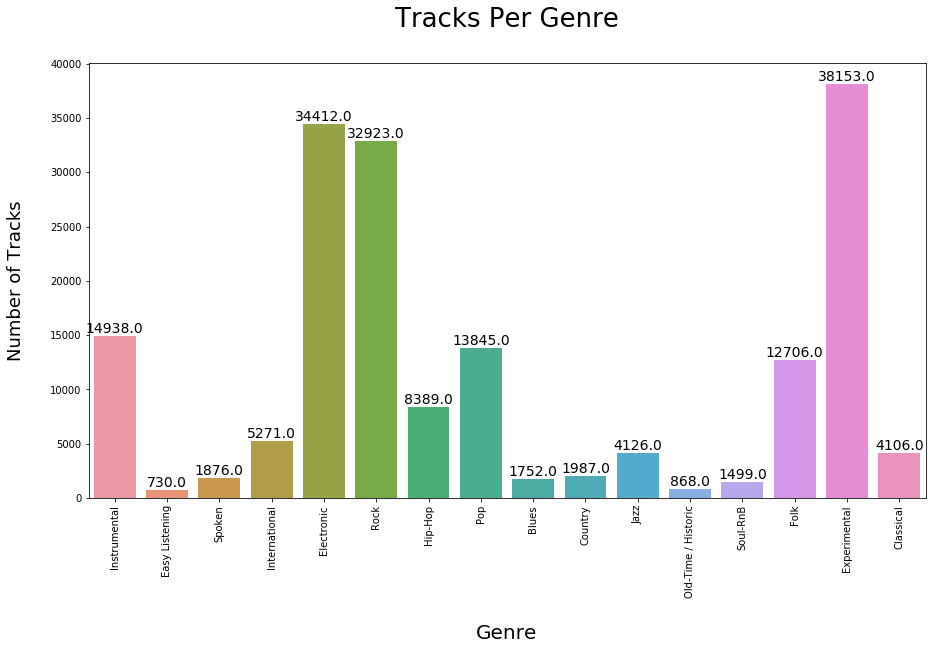

In [66]:
#Visualize genre info
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, music.iloc[:,18:].sum().values)

plt.title('Tracks Per Genre\n', fontsize=26)
plt.ylabel('Number of Tracks\n', fontsize=18)
plt.xlabel('\nGenre', fontsize=20)

#Label text
rects = ax.patches
labels = music.iloc[:,18:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
plt.show()

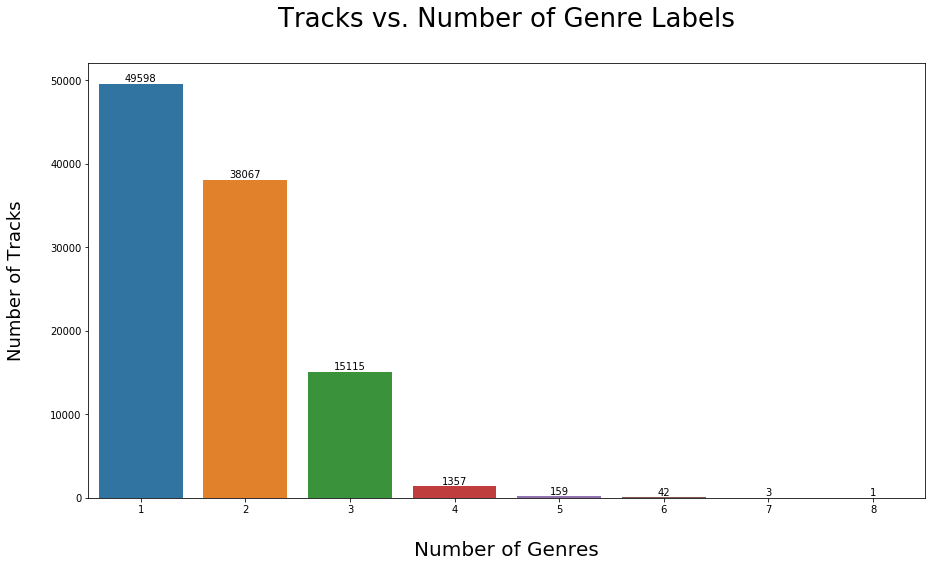

In [67]:
#Number of tracks containing multiple genre labels
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[:]

plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index.astype(int), multiLabel_counts.values)

plt.title('Tracks vs. Number of Genre Labels\n', fontsize = 26)
plt.ylabel('Number of Tracks\n', fontsize=18)
plt.xlabel('\nNumber of Genres', fontsize=20)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


### Divide the Dataset: Single-Label vs. Multi-Label
At this point in the project, we broke everything into two parts. The first was single-label classification, only analyzing tracks with one label, using a single genre dummy variable as the target feature. The second was a multi-label classification, analyzing all tracks in the dataset, using the set of 16 dummy genre features as target features.

In [79]:
onegen_df = music[pd.notnull(music['track_genre_top'])]
multigen_df = music[pd.isnull(music['track_genre_top'])]

print(len(onegen_df))
print(len(multigen_df))
print('Sum = ', len(onegen_df)+len(multigen_df))

49598
54744
Sum =  104342


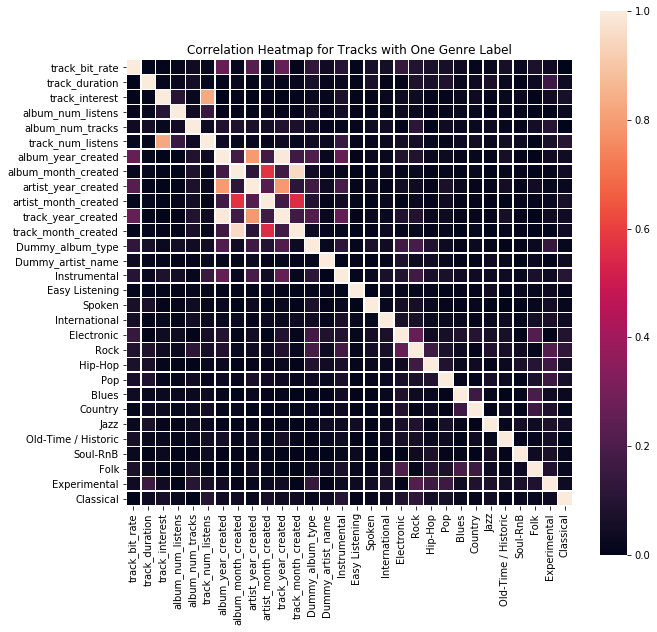

Dummy_genre             1.000000
Rock                    0.809506
Electronic              0.490391
Experimental            0.396911
Classical               0.284018
Dummy_album_type        0.270961
Pop                     0.227500
Spoken                  0.165950
Folk                    0.123821
track_duration          0.099091
Blues                   0.095992
Country                 0.095626
track_bit_rate          0.093509
Soul-RnB                0.091296
Old-Time / Historic     0.081752
Hip-Hop                 0.069685
album_num_tracks        0.064050
album_month_created     0.062242
artist_month_created    0.059315
track_month_created     0.058820
track_year_created      0.058728
track_num_listens       0.058028
album_year_created      0.057332
Jazz                    0.055489
International           0.043988
track_interest          0.035174
Easy Listening          0.027965
Dummy_artist_name       0.027613
artist_year_created     0.021209
album_num_listens       0.017855
Instrument

In [10]:
#Compare feature similarities 
#Compare the numerical categorical variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(music.corr()), square=True, linewidths=.5, annot=False)
plt.title('Correlation Heatmap for Tracks with One Genre Label')
plt.show()

abs(onegen_df.corr())['Dummy_genre'].sort_values(ascending=False)

We can see that there is a relatively high correlation between track_num_listens and track_interest, which makes sense. Additionally, there are medium to high correlations among the artist, album, and track months and years, respectively, which is also expected. However, for the dates correlation, we should probably remove some of the features to simplify our model, removing extraneous information. Let's retain the date features for the tracks and remove the ones for album and artist.

In [80]:
music = music.drop(['album_year_created', 'album_month_created', 'artist_year_created', 'artist_month_created'], axis=1)
onegen_df = onegen_df.drop(['album_year_created', 'album_month_created', 'artist_year_created', 'artist_month_created'], axis=1)
multigen_df = multigen_df.drop(['album_year_created', 'album_month_created', 'artist_year_created', 'artist_month_created'], axis=1)

### Single-Label Dataset Modeling and Analysis

In [81]:
#Convert single genre labels to dummies
#[int(str(x).strip('[').strip(']')) for x in onegen_df['track_genres']]
unique_gens = list(np.unique(list(onegen_df['track_genre_top'])))
dummy_gen = [unique_gens.index(x) for x in onegen_df['track_genre_top']]
onegen_df['Dummy_genre'] = dummy_gen

In [9]:
onegen_df.head()

album_type artist_name  track_bit_rate  track_duration track_genre_top  \
0      Album        AWOL        256000.0           168.0         Hip-Hop   
1      Album        AWOL        256000.0           237.0         Hip-Hop   
2      Album        AWOL        256000.0           206.0         Hip-Hop   
3      Album   KURT VILE        192000.0           161.0             Pop   
9      Album        AWOL        256000.0           207.0         Hip-Hop   

   track_interest  album_num_listens  album_num_tracks  track_num_listens  \
0          4656.0             6073.0               7.0             1293.0   
1          1470.0             6073.0               7.0              514.0   
2          1933.0             6073.0               7.0             1151.0   
3         54881.0            47632.0               2.0            50135.0   
9          1126.0             6073.0               7.0              943.0   

   album_year_created  ...  Pop  Blues  Country  Jazz  Old-Time / Historic  \
0              2008.0  ...  0.0    0.0      0.0   0.0                  0.0   
1              2008.0  ...  0.0    0.0      0.0   0.0                  0.0   
2              2008.0  ...  0.0    0.0      0.0   0.0                  0.0   
3              2008.0  ...  1.0    0.0      0.0   0.0                  0.0   
9              2008.0  ...  0.0    0.0      0.0   0.0                  0.0   

   Soul-RnB Folk  Experimental  Classical  Dummy_genre  
0       0.0  0.0           0.0        0.0            7  
1       0.0  0.0           0.0        0.0            7  
2       0.0  0.0           0.0        0.0            7  
3       0.0  0.0           0.0        0.0           12  
9       0.0  0.0           0.0        0.0            7  

[5 rows x 35 columns]

<Figure size 432x288 with 0 Axes>

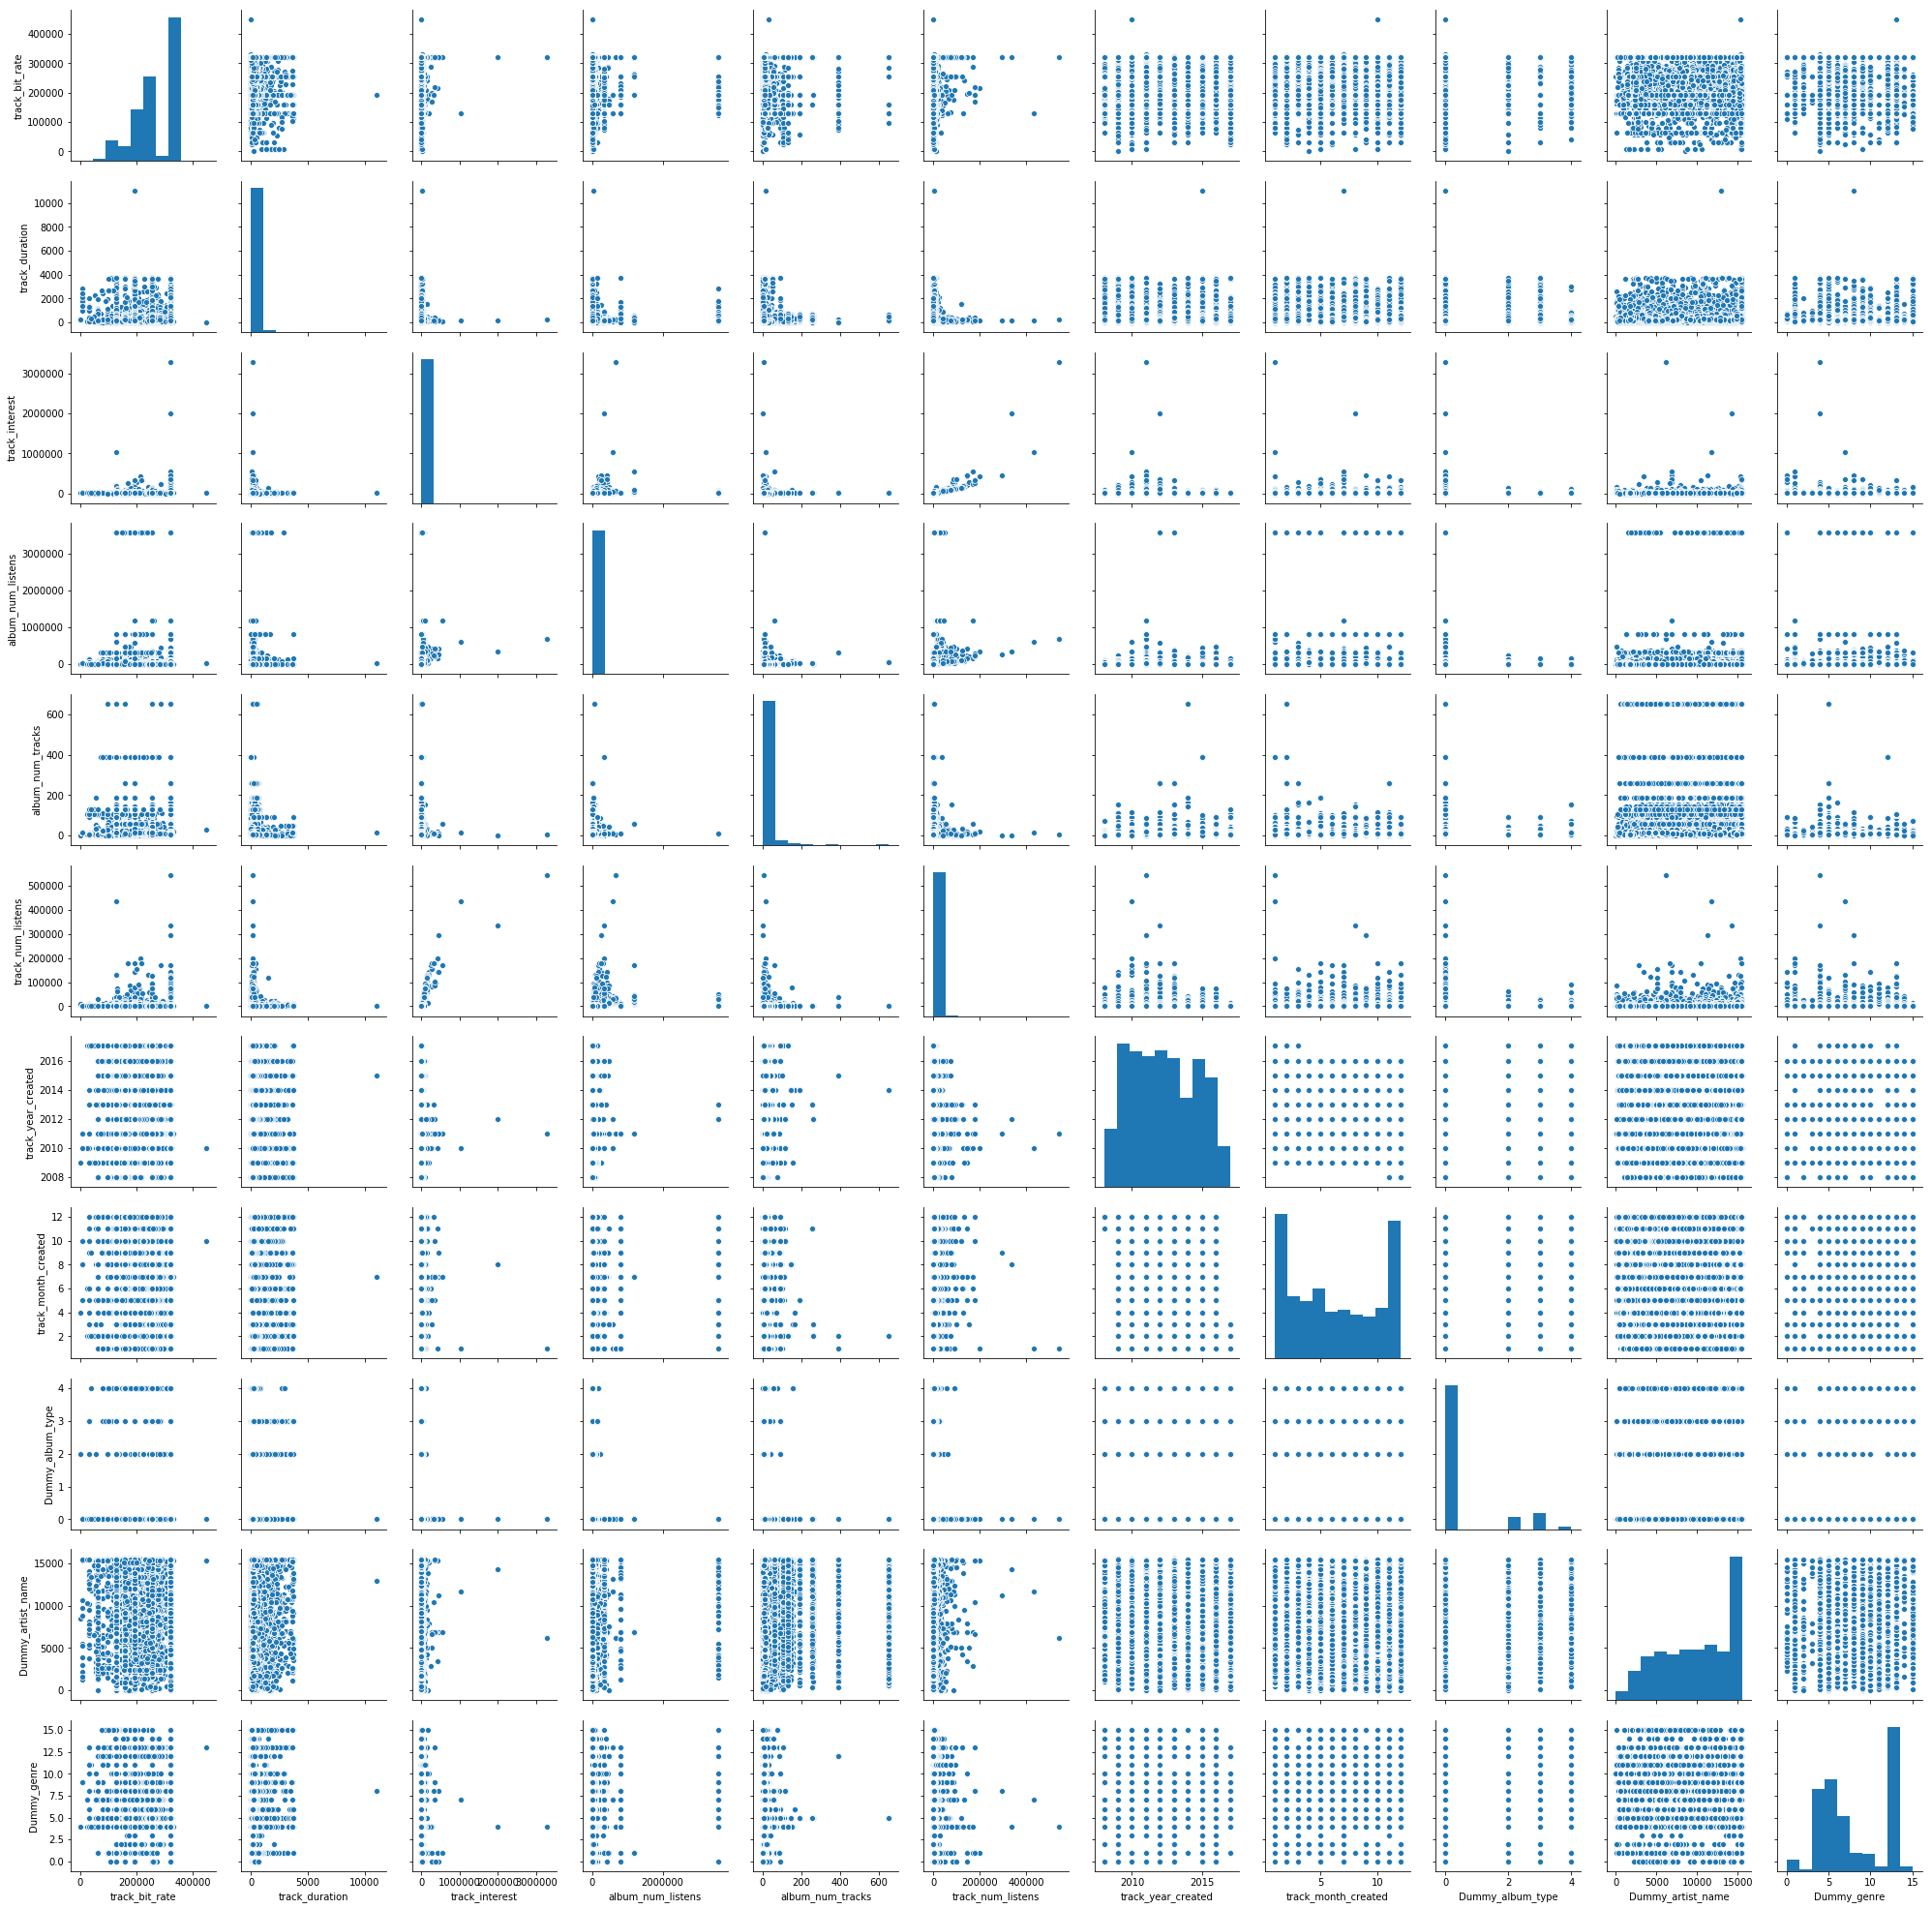

In [46]:
#Scatter Matrix
plt.figure()
sns.pairplot(onegen_df[onegen_df.columns.drop(categories)])
plt.show()

By analyzing the number of unique items within each feature, and the average difference between the values (or strings) within each unique list, we can determine what category each feature falls into (continuous, categorical, etc).

In [82]:
uniques = pd.DataFrame()
uni_col = []
num_uni = []
avgdiff_uni = []

for col in list(onegen_df.columns):
    try:
        uni_col.append(list(np.unique(onegen_df[col])))
        num_uni.append(len(np.unique(onegen_df[col])))
    except:
        uni_col.append(list((onegen_df[col]).unique()[pd.notnull(list((onegen_df[col]).unique()))]))
        num_uni.append(len((onegen_df[col]).unique()[pd.notnull(list((onegen_df[col]).unique()))]))
        
    try:
        avgdiff_uni.append(np.mean(np.diff(np.unique(onegen_df[col]))))
    except: 
        avgdiff_uni.append('N/A')
    
uniques['Category'] = list(onegen_df.columns)
uniques['Unique Values'] = uni_col
uniques['Num Uniques'] = num_uni
uniques['Avg Diff Among Uniques'] = avgdiff_uni

uniques

Category                                      Unique Values  \
0            album_type  [Album, Live Performance, Radio Program, Singl...   
1           artist_name  [$50 Trumpet, 'Gene Green, ((( vlubä ))), (-),...   
2        track_bit_rate  [192.0, 8000.0, 24000.0, 32000.0, 40000.0, 480...   
3        track_duration  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
4       track_genre_top  [Blues, Classical, Country, Easy Listening, El...   
5        track_interest  [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...   
6     album_num_listens  [40.0, 41.0, 48.0, 49.0, 52.0, 55.0, 61.0, 64....   
7      album_num_tracks  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
8     track_num_listens  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
9    track_year_created  [2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013....   
10  track_month_created  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
11     Dummy_album_type                                       [0, 2, 3, 4]   
12     str_track_genres  [[Blues], [Classical], [Country], [Easy Listen...   
13              Country                                         [0.0, 1.0]   
14              Hip-Hop                                         [0.0, 1.0]   
15        International                                         [0.0, 1.0]   
16                Blues                                         [0.0, 1.0]   
17         Instrumental                                         [0.0, 1.0]   
18             Soul-RnB                                         [0.0, 1.0]   
19            Classical                                         [0.0, 1.0]   
20  Old-Time / Historic                                         [0.0, 1.0]   
21                 Folk                                         [0.0, 1.0]   
22                  Pop                                         [0.0, 1.0]   
23       Easy Listening                                         [0.0, 1.0]   
24           Electronic                                         [0.0, 1.0]   
25                 Rock                                         [0.0, 1.0]   
26         Experimental                                         [0.0, 1.0]   
27               Spoken                                         [0.0, 1.0]   
28                 Jazz                                         [0.0, 1.0]   
29          Dummy_genre  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

    Num Uniques Avg Diff Among Uniques  
0             4                    N/A  
1          9070                    N/A  
2          5485                81.6572  
3          1734                6.36411  
4            16                    N/A  
5          8435                390.509  
6          5494                648.863  
7            88                7.48276  
8          6879                78.9839  
9            10                      1  
10           12                      1  
11            4                1.33333  
12           16                    N/A  
13            2                      1  
14            2                      1  
15            2                      1  
16            2                      1  
17            2                      1  
18            2                      1  
19            2                      1  
20            2                      1  
21            2                      1  
22            2                      1  
23            2                      1  
24            2                      1  
25            2                      1  
26            2                      1  
27            2                      1  
28            2                      1  
29           16                      1

In [83]:
#Separate features by type

#Boolean genre cols:
gen_cols = list(categories)

#String categoricals:
str_cat_cols = []
for col in list(onegen_df.columns):
    if col not in gen_cols:   
        if (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] == 'N/A'):
            str_cat_cols.append(col)

#Categorical features:
cat_cols = []
for col in list(onegen_df.columns):
    if (col not in gen_cols) and (col not in str_cat_cols):   
        if (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 3):
            cat_cols.append(col)

#Continuous features:
cont_cols = []
for col in list(onegen_df.columns):
    if ((col not in gen_cols) and (col not in cat_cols) and (col not in str_cat_cols)):
        cont_cols.append(col)
        
print('Genre Dummy Features: \n', gen_cols)

print('\nString Categorical Features: \n', str_cat_cols)

print('\nCategorical Features: \n', cat_cols)

print('\nContinuous Features: \n', cont_cols)

Genre Dummy Features: 
 ['Country', 'Hip-Hop', 'International', 'Blues', 'Instrumental', 'Soul-RnB', 'Classical', 'Old-Time / Historic', 'Folk', 'Pop', 'Easy Listening', 'Electronic', 'Rock', 'Experimental', 'Spoken', 'Jazz']

String Categorical Features: 
 ['album_type', 'artist_name', 'track_genre_top', 'str_track_genres']

Categorical Features: 
 ['track_year_created', 'track_month_created', 'Dummy_album_type', 'Dummy_genre']

Continuous Features: 
 ['track_bit_rate', 'track_duration', 'track_interest', 'album_num_listens', 'album_num_tracks', 'track_num_listens']


#### Distributions of Continuous Feature Values for Single-Label Tracks

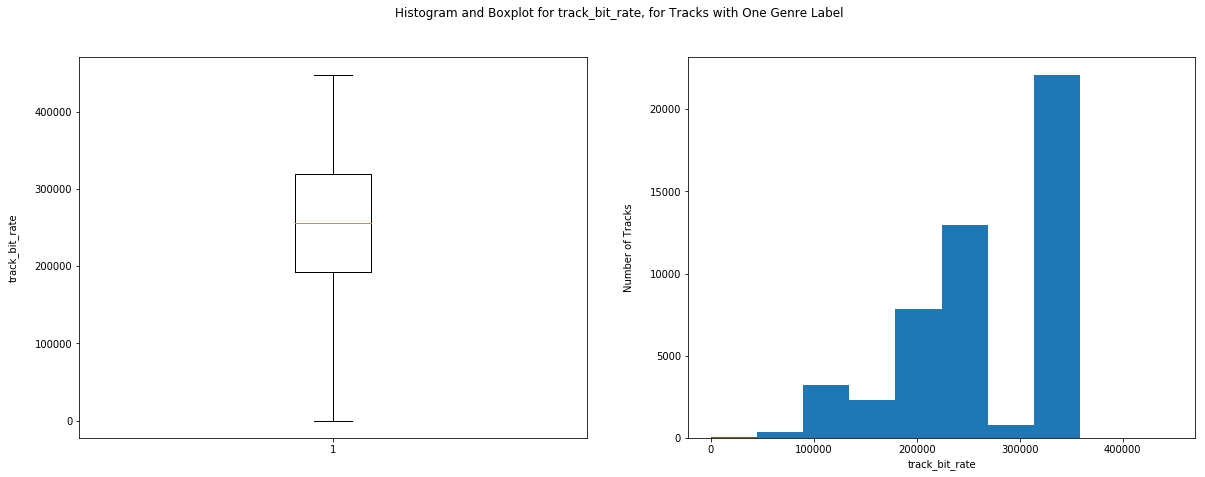

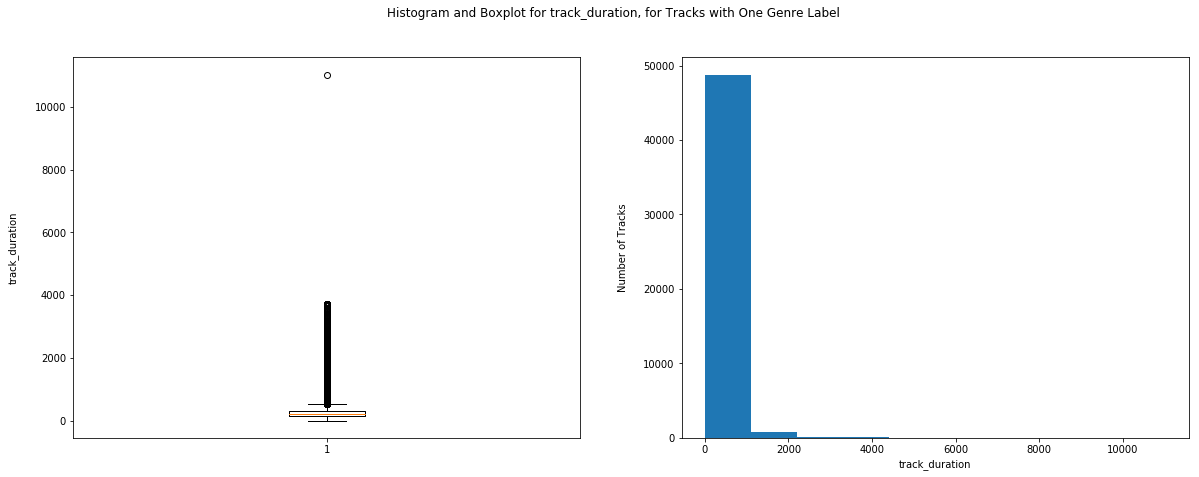

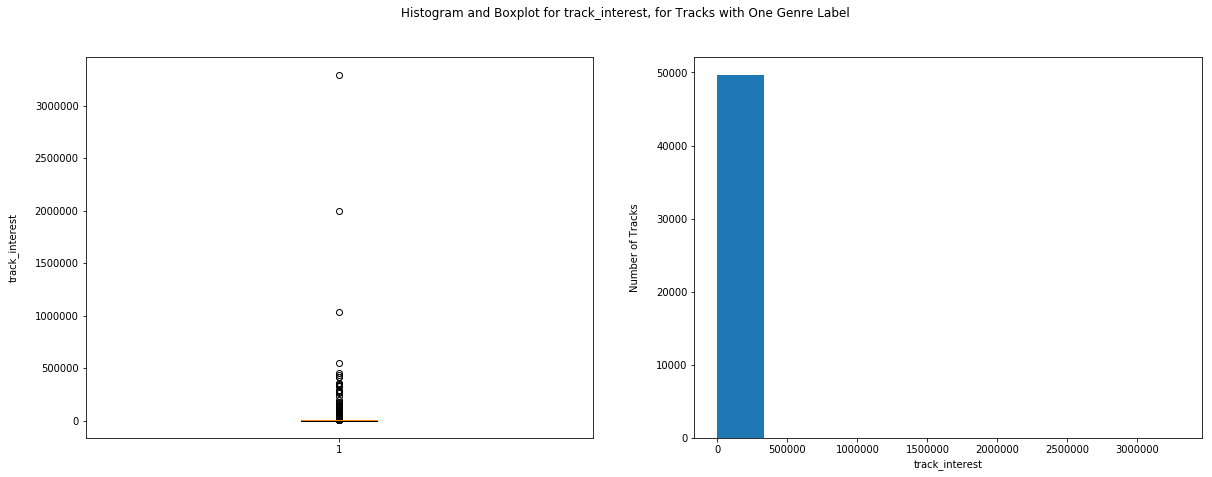

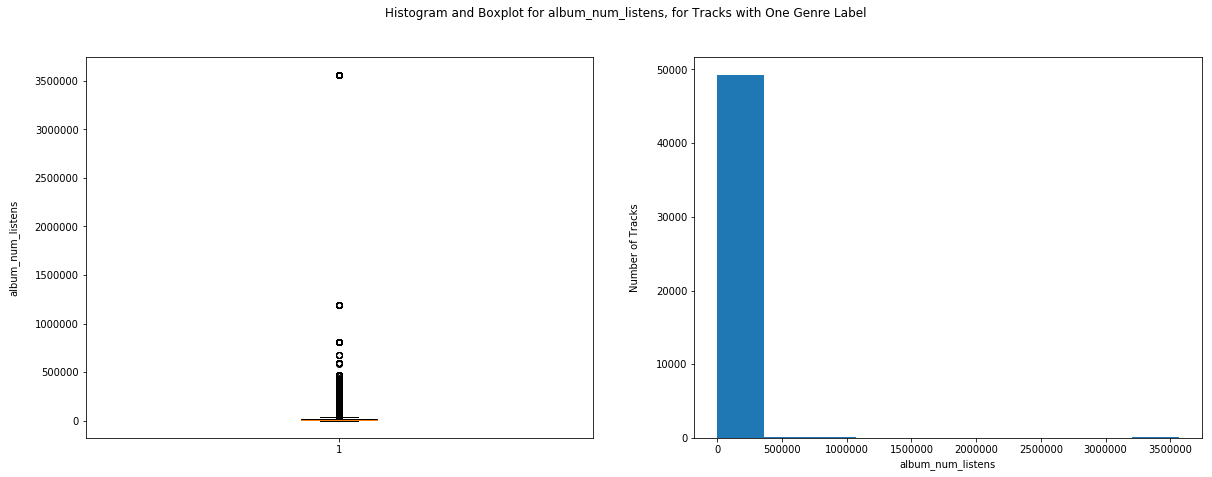

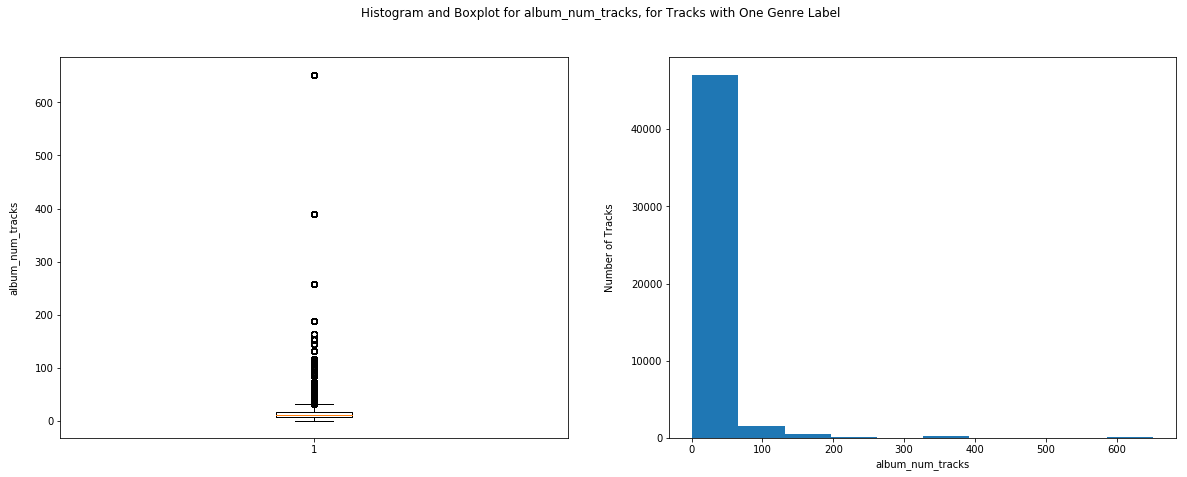

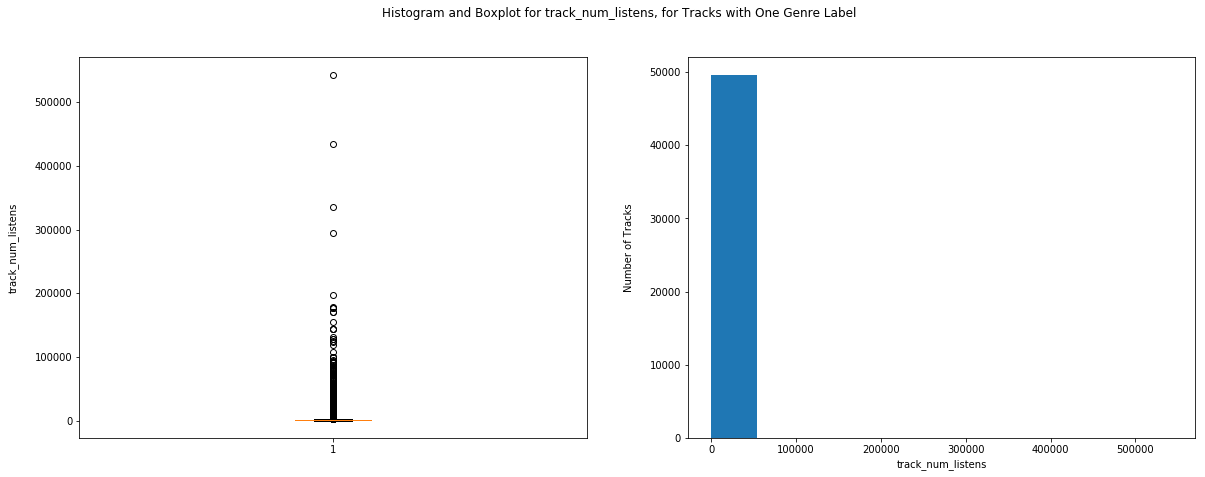

In [18]:
#Distributions of features
for col in cont_cols:
    plt.figure(figsize=(20, 7))
    
    plt.subplot(1,2,1)
    plt.boxplot(onegen_df[col])
    plt.xlabel('')
    plt.ylabel(col +'\n')
    
    plt.subplot(1,2,2)    
    plt.hist(onegen_df[col])
    plt.xlabel(col)
    plt.ylabel('Number of Tracks\n')
    
    plt.suptitle('Histogram and Boxplot for ' + col + ', for Tracks with One Genre Label\n')
    plt.show()

None of the continuous variables show a normal distribution, and almost all of them show a large range of outliers skewed toward the higher values.

#### Mode Genre for each Categorical Variable

<Figure size 3600x3600 with 0 Axes>

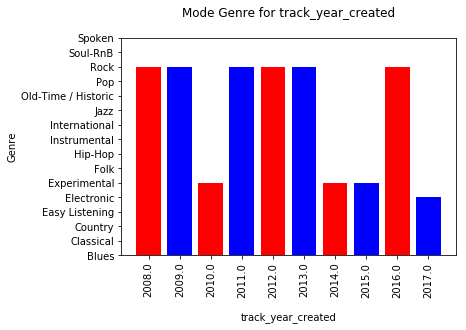

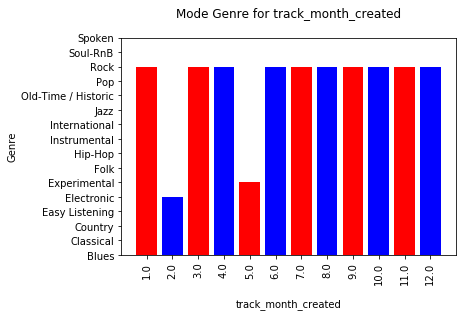

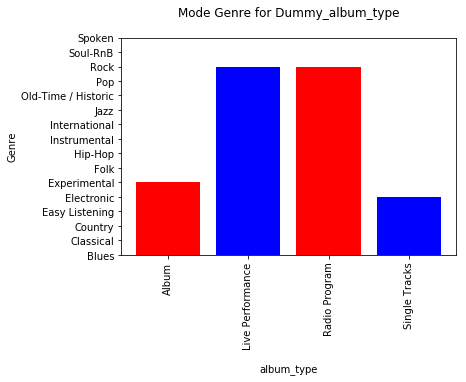

In [238]:
#Analyze all of the categorical variables, with respect to genre
cols = ['track_year_created','track_month_created','album_type', 'artist_name']
#Bar chart with dummy genre on the y-axis and categorical variable on the x-axis
plt.figure(figsize=(50, 50))

for i in range(len(cat_cols[:-1])):
    fig, ax = plt.subplots()
    inds = list(onegen_df.groupby(cat_cols[i]).Dummy_genre.apply(lambda x: x.mode()).index.codes[0])
    values = list(onegen_df.groupby(cat_cols[i]).Dummy_genre.apply(lambda x: x.mode()))
    plt.bar(inds, values, color=('red','blue'))
    plt.title('Mode Genre for ' + cat_cols[i] + '\n')
    plt.ylabel('Genre')
    ax.set_yticks(list(range(len(gen_cols))))
    ax.set_yticklabels(np.unique(gen_cols))
    plt.xlabel('\n' + cols[i])
    ax.set_xticks(list(range(len(np.unique(onegen_df[cols[i]])))))
    ax.set_xticklabels(np.unique(onegen_df[cols[i]]), rotation='vertical')
    
    plt.show()

All of the categorical variables seem to show a propensity toward the genre labels of 'Rock,' 'Experimental,' and 'Electronic.' This may cause issues with our analysis later, as those features may not provide the information we need to classify effectively. It is also important to note that this was likely caused by a class imbalance (i.e. those genre labels appear more often for each category simply because there are more of them in the set). Although we didn't investigate class imbalances as part of this preparation analysis for Dr. Playlist, that is something we will probably need to address before completing the final models.

#### Single-Label Tracks - Feature Correlations

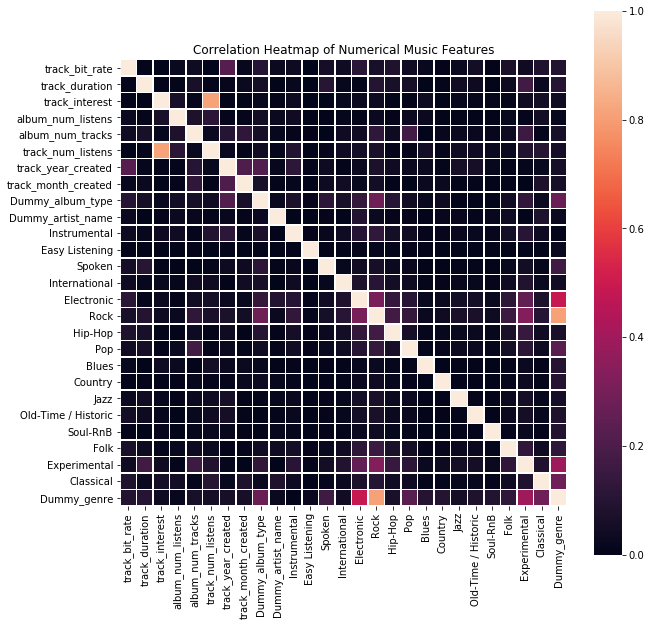

In [82]:
#Compare feature similarities 
#Compare the numerical categorical variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(onegen_df.corr()), square=True, linewidths=.5, annot=False)
plt.title('Correlation Heatmap of Numerical Music Features')
plt.show()


As noted earlier, 'Rock,' 'Experimental,' and 'Electronic' show relatively high correlations to the 'Dummy_genre' feature, which is likely due to class imbalance.

In [84]:
onegen_df.columns

Index(['album_type', 'artist_name', 'track_bit_rate', 'track_duration',
       'track_genre_top', 'track_interest', 'album_num_listens',
       'album_num_tracks', 'track_num_listens', 'track_year_created',
       'track_month_created', 'Dummy_album_type', 'str_track_genres',
       'Country', 'Hip-Hop', 'International', 'Blues', 'Instrumental',
       'Soul-RnB', 'Classical', 'Old-Time / Historic', 'Folk', 'Pop',
       'Easy Listening', 'Electronic', 'Rock', 'Experimental', 'Spoken',
       'Jazz', 'Dummy_genre'],
      dtype='object')

Most of these have many outliers and are not normally distributed. Let's transform them, and see if anything changes.

In [85]:
#Fix outliers
onegen_features = cont_cols
onegen_features

['track_bit_rate',
 'track_duration',
 'track_interest',
 'album_num_listens',
 'album_num_tracks',
 'track_num_listens']

#### Continuous Features - Outlier Removal via Winsorization

In [86]:
#Determine extent of outliers using Tukey's method
outlier_loc = []
top_outlier_percent = []
bottom_outlier_percent = []

for col in list(onegen_features):
    q75, q25 = np.percentile(onegen_df[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    if (len((np.where(onegen_df[col] > max_val))[0]) > 0):
        if (len((np.where(onegen_df[col] < min_val))[0]) > 0):
            loc_now = 'both ends'
        else:
            loc_now = 'top'
    else:
        loc_now = 'bottom'
    
    outlier_loc.append(loc_now)
    print("Percentage of outliers in {}, located at {} of range: {}".format(col, loc_now, len((np.where((onegen_df[col] > max_val) |(onegen_df[col] < min_val))[0]))/len(onegen_df)))
    
    top_percent = len((np.where((onegen_df[col] > max_val))[0]))/len(onegen_df)
    #Get values to the closest whole percent
    top_outlier_percent.append(math.ceil(top_percent*100)/100)
    
    bottom_percent = len((np.where((onegen_df[col] < min_val))[0]))/len(onegen_df)
    #Get values to the closest whole percent
    bottom_outlier_percent.append(math.ceil(bottom_percent*100)/100)


Percentage of outliers in track_bit_rate, located at bottom of range: 0.0
Percentage of outliers in track_duration, located at top of range: 0.06939795959514497
Percentage of outliers in track_interest, located at top of range: 0.10522601717811202
Percentage of outliers in album_num_listens, located at top of range: 0.11613371506915601
Percentage of outliers in album_num_tracks, located at top of range: 0.11413766684140489
Percentage of outliers in track_num_listens, located at top of range: 0.1100850840759708


In [87]:
#Show calculated outlier parameters to be used for winsorization
out_df = pd.DataFrame()

out_df['variable name'] = list(onegen_features)
out_df['top outliers'] = top_outlier_percent
out_df['bottom outliers'] = bottom_outlier_percent
out_df['outlier location'] = outlier_loc

out_df

variable name  top outliers  bottom outliers outlier location
0     track_bit_rate          0.00              0.0           bottom
1     track_duration          0.07              0.0              top
2     track_interest          0.11              0.0              top
3  album_num_listens          0.12              0.0              top
4   album_num_tracks          0.12              0.0              top
5  track_num_listens          0.12              0.0              top

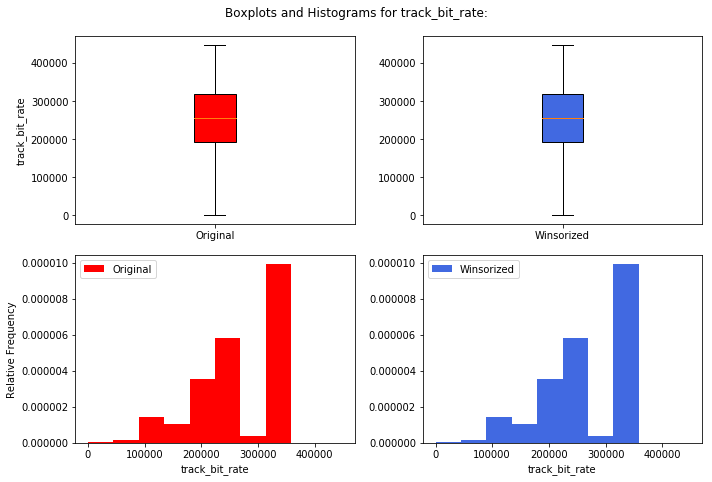

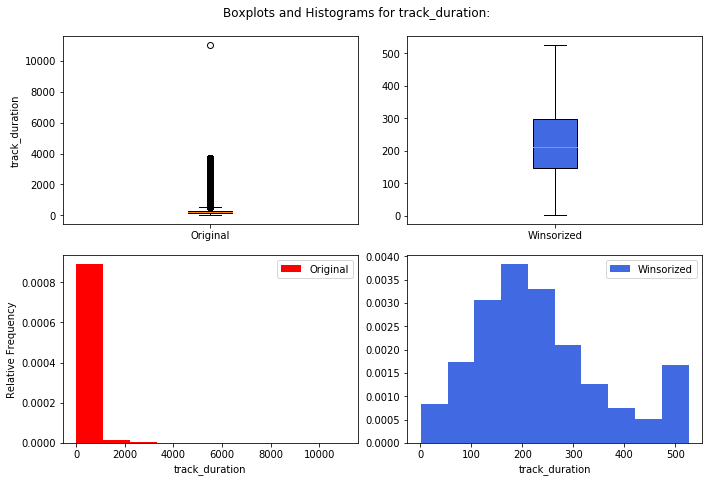

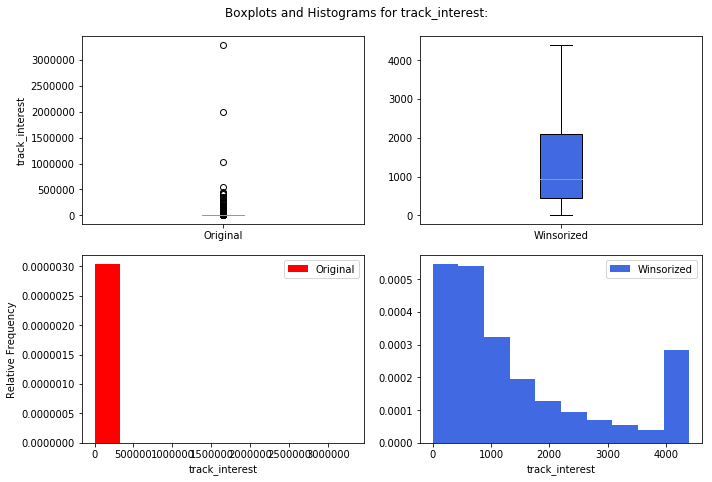

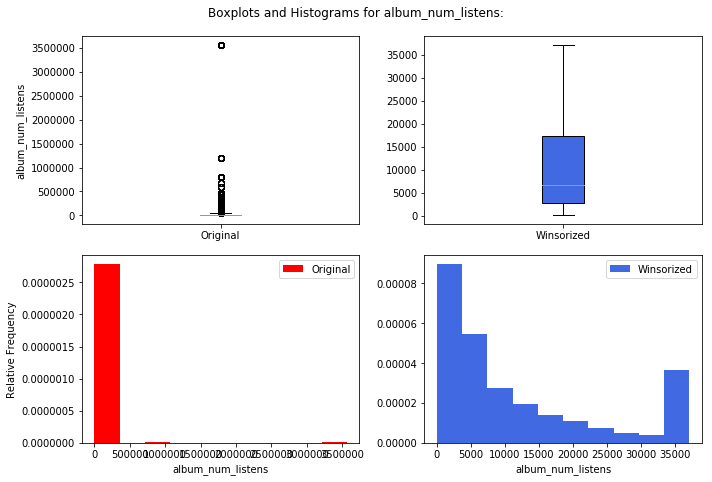

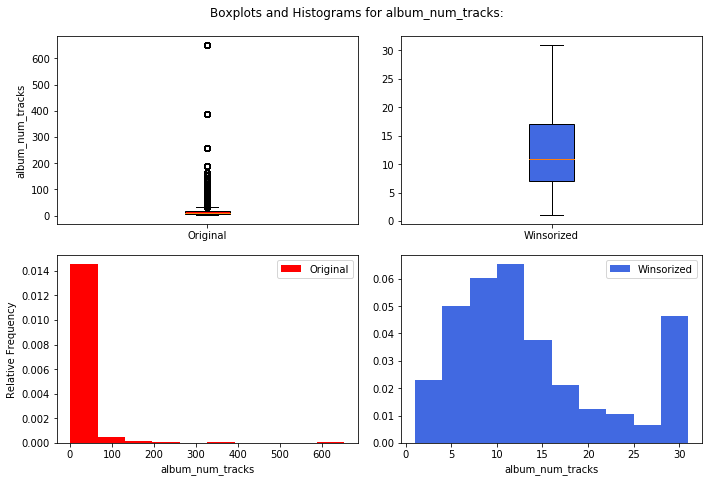

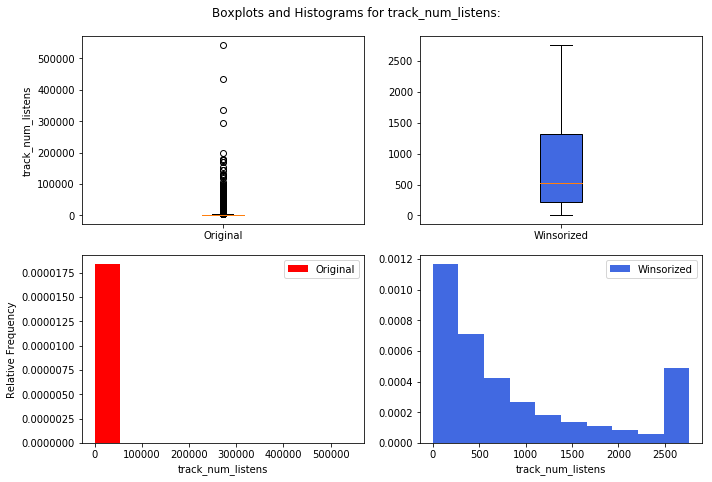

In [98]:
#Transform/remove the outliers, using winsorize()
from scipy.stats.mstats import winsorize

winsorized_cols = pd.DataFrame()

cols = onegen_features
for i in range(len(cols)):
    winsorized_cols[cols[i]] = winsorize(onegen_df[cols[i]], (bottom_outlier_percent[i], top_outlier_percent[i]))

#Analyze the effects of winsorization on boxplots/histograms:
for col in cols:
    plt.figure(figsize=(10,7))
    plt.subplot(2,2,1)
    box = plt.boxplot([onegen_df[col]], patch_artist=True, labels = ['Original'])
    plt.ylabel(col)
    colors = ['red']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.subplot(2,2,2)
    box = plt.boxplot([winsorized_cols[col]], patch_artist=True, labels = ['Winsorized'])
    colors = ['royalblue']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)


    plt.subplot(2,2,3)
    plt.hist([onegen_df[col]], color='red', label = ['Original'], normed=True)
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.legend()  

    plt.subplot(2,2,4)
    plt.hist([winsorized_cols[col]], color='royalblue', label = ['Winsorized'], normed=True)
    plt.xlabel(col)
    plt.legend()
    
    
    plt.suptitle('Boxplots and Histograms for ' + col + ':')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    

In [99]:
onegen_df = onegen_df.reset_index(drop=True)

In [55]:
onegen_2 = winsorized_cols.copy()
onegen_2.columns = [str('Winsorized ' + item) for item in list(onegen_features)]

for col in ['Dummy_album_type', 'Dummy_artist_name','Instrumental', 
            'Easy Listening', 'Spoken','International', 'Electronic', 
            'Rock', 'Hip-Hop', 'Pop', 'Blues','Country', 'Jazz', 
            'Old-Time / Historic', 'Soul-RnB', 'Folk','Experimental', 
            'Classical', 'Dummy_genre', 'track_genre_top', 
            'track_year_created', 'track_month_created']:
    onegen_2[col] = onegen_df[col]

#Description of winsorized dataframe statistics
onegen_2.describe()

Winsorized track_bit_rate  Winsorized track_duration  \
count               49598.000000               49598.000000   
mean               260498.022461                 235.251553   
std                 65226.411153                 129.412291   
min                   192.000000                   1.000000   
25%                192000.000000                 146.000000   
50%                256000.000000                 211.000000   
75%                320000.000000                 299.000000   
max                448000.000000                 526.000000   

       Winsorized track_interest  Winsorized album_num_listens  \
count               49598.000000                  49598.000000   
mean                 1487.479737                  11988.822372   
std                  1368.682223                  12089.664588   
min                     2.000000                     40.000000   
25%                   456.000000                   2812.000000   
50%                   938.000000                   6566.000000   
75%                  2091.000000                  17404.000000   
max                  4398.000000                  37161.000000   

       Winsorized album_num_tracks  Winsorized track_num_listens  \
count                 49598.000000                  49598.000000   
mean                     13.368281                    903.250857   
std                       8.752777                    900.304244   
min                       1.000000                      1.000000   
25%                       7.000000                    212.000000   
50%                      11.000000                    520.000000   
75%                      17.000000                   1321.000000   
max                      31.000000                   2762.000000   

       Dummy_album_type  Dummy_artist_name  Instrumental  Easy Listening  ...  \
count      49598.000000       49598.000000  49598.000000    49598.000000  ...   
mean           0.452821        9928.004879      0.041917        0.000484  ...   
std            1.032030        4366.468890      0.200402        0.021992  ...   
min            0.000000           4.000000      0.000000        0.000000  ...   
25%            0.000000        6236.000000      0.000000        0.000000  ...   
50%            0.000000       10380.000000      0.000000        0.000000  ...   
75%            0.000000       14261.000000      0.000000        0.000000  ...   
max            4.000000       15495.000000      1.000000        1.000000  ...   

            Country          Jazz  Old-Time / Historic      Soul-RnB  \
count  49598.000000  49598.000000         49598.000000  49598.000000   
mean       0.003911      0.011513             0.011170      0.003528   
std        0.062420      0.106678             0.105096      0.059296   
min        0.000000      0.000000             0.000000      0.000000   
25%        0.000000      0.000000             0.000000      0.000000   
50%        0.000000      0.000000             0.000000      0.000000   
75%        0.000000      0.000000             0.000000      0.000000   
max        1.000000      1.000000             1.000000      1.000000   

               Folk  Experimental     Classical   Dummy_genre  \
count  49598.000000  49598.000000  49598.000000  49598.000000   
mean       0.056514      0.213880      0.024799      7.983830   
std        0.230915      0.410047      0.155515      3.921259   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      5.000000   
50%        0.000000      0.000000      0.000000      7.000000   
75%        0.000000      0.000000      0.000000     13.000000   
max        1.000000      1.000000      1.000000     15.000000   

       track_year_created  track_month_created  
count        49598.000000         49598.000000  
mean          2012.241764             6.293903  
std              2.563585             3.638937  
min           2008.000000             1.000000  
25%           2010.00

In [56]:
onegen_2.head()

Winsorized track_bit_rate  Winsorized track_duration  \
0                   256000.0                      168.0   
1                   256000.0                      237.0   
2                   256000.0                      206.0   
3                   192000.0                      161.0   
4                   256000.0                      207.0   

   Winsorized track_interest  Winsorized album_num_listens  \
0                     4398.0                        6073.0   
1                     1470.0                        6073.0   
2                     1933.0                        6073.0   
3                     4398.0                       37161.0   
4                     1126.0                        6073.0   

   Winsorized album_num_tracks  Winsorized track_num_listens  \
0                          7.0                        1293.0   
1                          7.0                         514.0   
2                          7.0                        1151.0   
3                          2.0                        2762.0   
4                          7.0                         943.0   

   Dummy_album_type  Dummy_artist_name  Instrumental  Easy Listening  ...  \
0                 0              15199           0.0             0.0  ...   
1                 0              15199           0.0             0.0  ...   
2                 0              15199           0.0             0.0  ...   
3                 0              11304           0.0             0.0  ...   
4                 0              15199           0.0             0.0  ...   

   Jazz  Old-Time / Historic  Soul-RnB  Folk  Experimental  Classical  \
0   0.0                  0.0       0.0   0.0           0.0        0.0   
1   0.0                  0.0       0.0   0.0           0.0        0.0   
2   0.0                  0.0       0.0   0.0           0.0        0.0   
3   0.0                  0.0       0.0   0.0           0.0        0.0   
4   0.0                  0.0       0.0   0.0           0.0        0.0   

   Dummy_genre  track_genre_top  track_year_created  track_month_created  
0            7          Hip-Hop              2008.0                 11.0  
1            7          Hip-Hop              2008.0                 11.0  
2            7          Hip-Hop              2008.0                 11.0  
3           12              Pop              2008.0                 11.0  
4            7          Hip-Hop              2008.0                 11.0  

[5 rows x 28 columns]

#### Post-Winsorization Feature Correlations

In [26]:
#Determine highest correlations to 'Life expectancy'
abs(onegen_2.corr())['Dummy_genre'].sort_values(ascending=False)

Dummy_genre                     1.000000
Rock                            0.809506
Electronic                      0.490391
Experimental                    0.396911
Classical                       0.284018
Dummy_album_type                0.270961
Pop                             0.227500
Winsorized album_num_listens    0.178294
Spoken                          0.165950
Winsorized album_num_tracks     0.151193
Winsorized track_duration       0.148785
Folk                            0.123821
Winsorized track_interest       0.111395
Blues                           0.095992
Country                         0.095626
Winsorized track_bit_rate       0.093509
Soul-RnB                        0.091296
Winsorized track_num_listens    0.084423
Old-Time / Historic             0.081752
Hip-Hop                         0.069685
track_month_created             0.058820
track_year_created              0.058728
Jazz                            0.055489
International                   0.043988
Easy Listening  

#### Continuous Variable Distributions - Separated by Genre Label

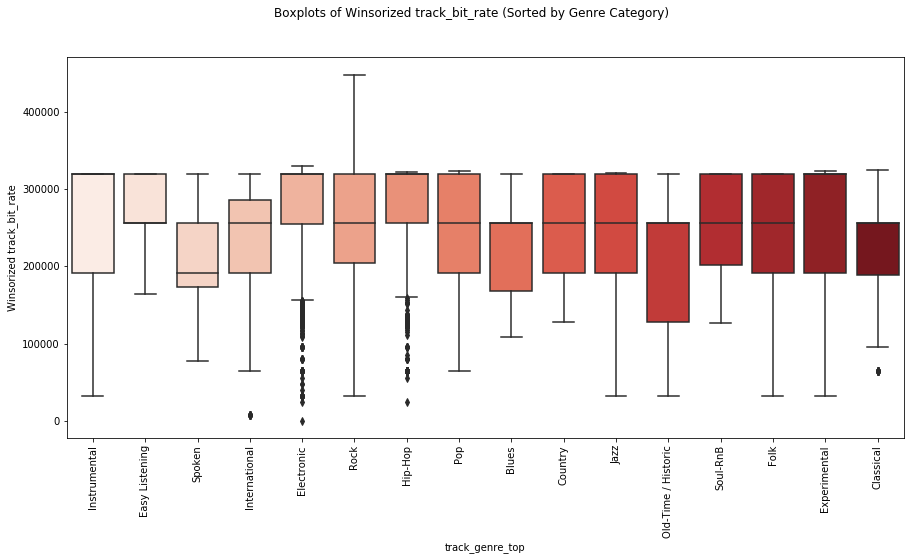

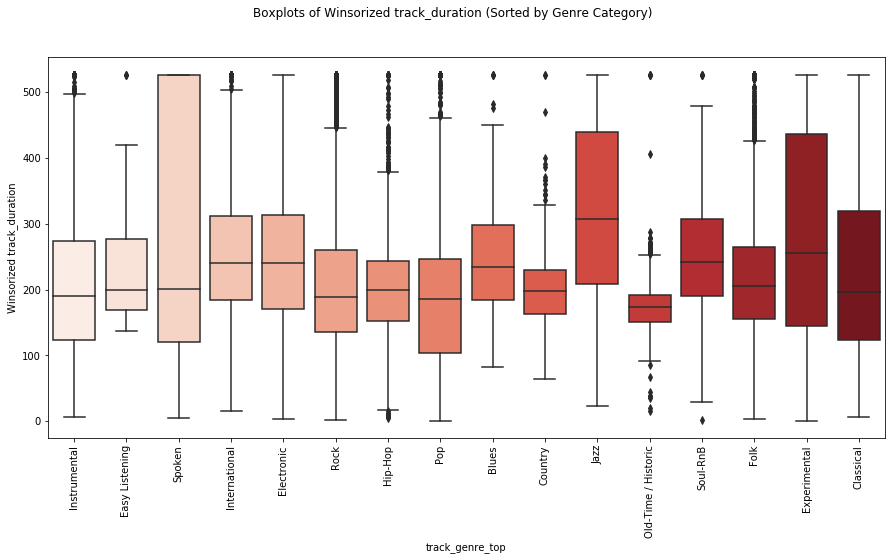

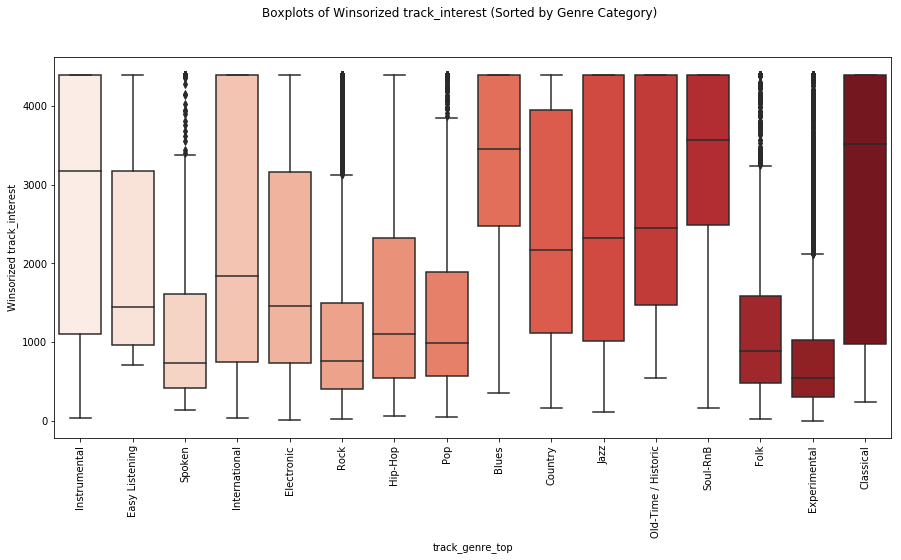

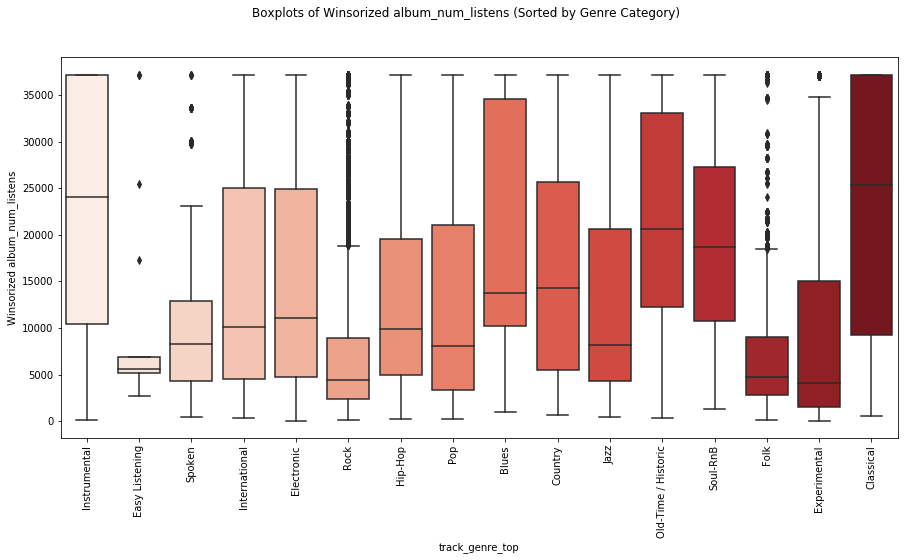

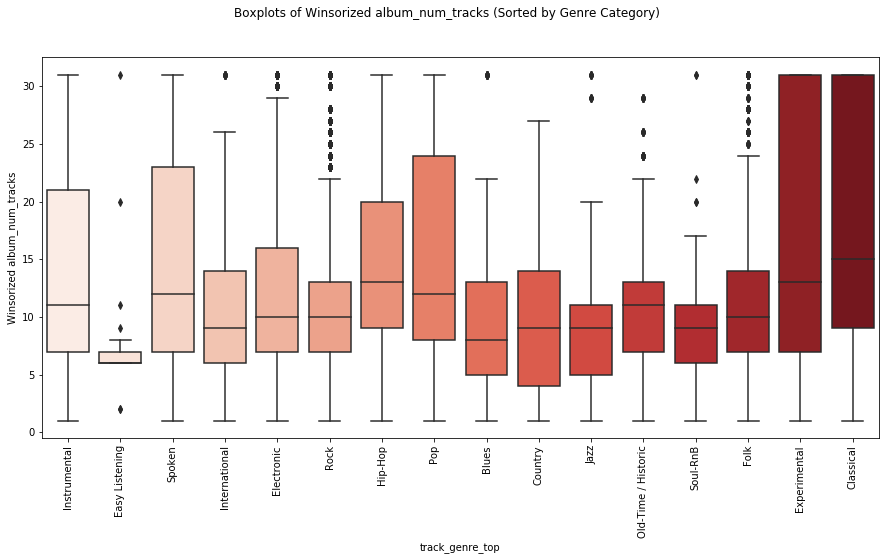

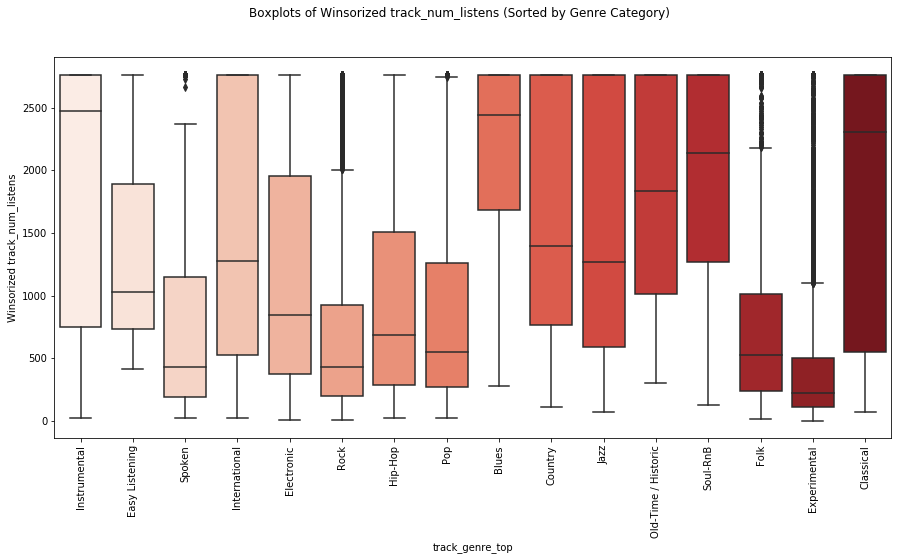

In [211]:
#Boxplot Distributions of Continuous Variables by Category
win_conts = onegen_2.columns.drop(gen_cols).drop(cat_cols).drop('track_genre_top')

for col in win_conts:
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='track_genre_top', y=col, data=onegen_2, palette='Reds', order = gen_cols)
    plt.xticks(rotation=90)

    plt.suptitle('Boxplots of ' + col + ' (Sorted by Genre Category)')
    plt.show()

#### Quantifying Class Imbalance

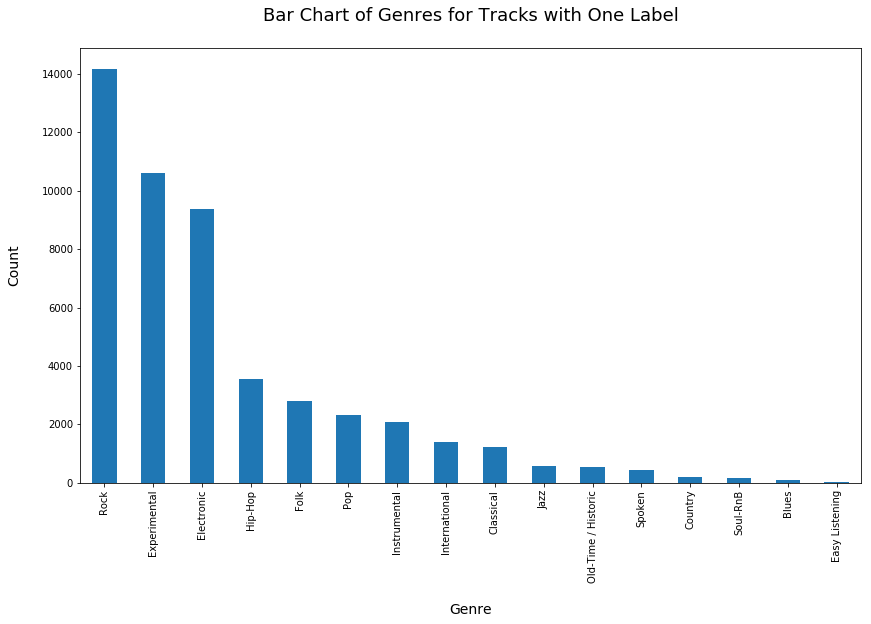

In [213]:
ax = onegen_df['track_genre_top'].value_counts().plot(kind='bar', figsize=(14,8), fontsize = 10)
ax.set_title("Bar Chart of Genres for Tracks with One Label\n", fontsize=18)
ax.set_xlabel("\nGenre", fontsize=14)
ax.set_ylabel("Count\n", fontsize=14)
plt.show()

### Train-Test Split for Single-Label Track Modeling
20% of the single-label dataset will be saved as a test set, and 80% will be used to train each model.

In [164]:
from sklearn.model_selection import train_test_split

features = onegen_2.columns.drop(['track_genre_top', 'Dummy_genre']).drop(gen_cols)
target = 'track_genre_top'

X = onegen_2[features]
Y = onegen_2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [165]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In order to improve performance of our models, we need to scale our continuous variables so that they exist in identical ranges (0 to 1 in this case). This min-max scaling is done after the split so that the training set values are not skewed by testing set values.

In [166]:
#Normalize data
for df in [X_train, X_test]: 
    norm_df = pd.DataFrame()
    for cat in win_conts:
        normed = []
        for item in df[cat]:
            xmax = df[cat].max()
            xmin = df[cat].min()
            normed.append((item-xmin)/(xmax-xmin))

        norm_df[cat] = normed

    for col in norm_df.columns:
        df[col] = norm_df[col]

### Import Libraries and Define Functions

In [167]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# For evaluating our ML results
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc

In [168]:
# Making the Confusion Matrix
def confusion_matrix_c(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_label = gen_cols
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.show()
    
def binary_confusion_matrix_c(y_test,y_pred, col):
    yt = [1 if x==col else 0 for x in y_test]
    yp = [1 if x==col else 0 for x in y_pred]
    
    cm = confusion_matrix(yt, yp)
    class_label = ['Not ' + col, col]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.show()
    
def feature_importance_plt(classifier, X, str_classifier):
    feature_importance = classifier.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importances for ' + str_classifier)
    plt.show()


### Multinomial Logistic Regression Classifier

Logistic Regression Train Accuracy:  0.3894097484752256
Logistic Regression Test Accuracy:  0.3814516129032258


Multinomial Logistic Regression Train Accuracy:  0.41607439891123543
Multinomial Logistic Regression Test Accuracy:  0.403125


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        21
          Classical       0.20      0.19      0.20       244
            Country       0.00      0.00      0.00        47
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.38      0.31      0.34      1910
       Experimental       0.42      0.59      0.49      2083
               Folk       0.00      0.00      0.00       569
            Hip-Hop       0.00      0.00      0.00       688
       Instrumental       0.33      0.03      0.06       421
      International       0.04      0.00      0.01       265
               Jazz       0.00      0.00      0.00       120
Old-Time / Historic       

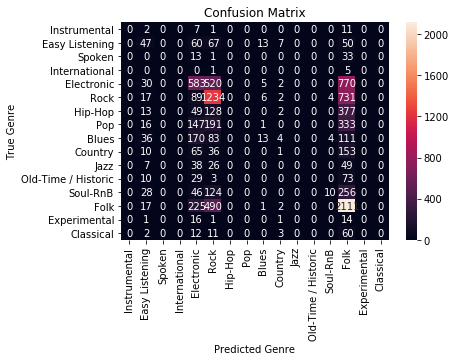

Binary Confusion Matrix for Instrumental:


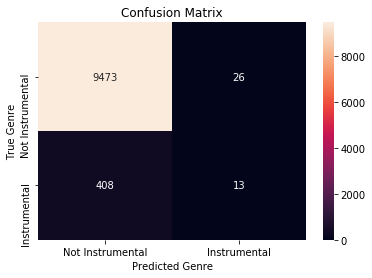

Binary Confusion Matrix for Easy Listening:


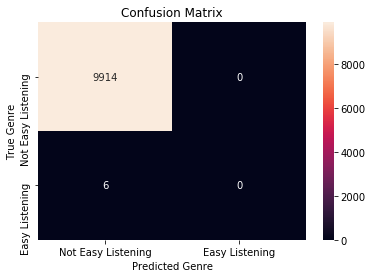

Binary Confusion Matrix for Spoken:


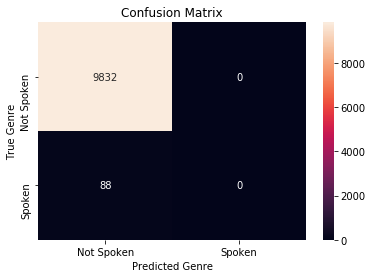

Binary Confusion Matrix for International:


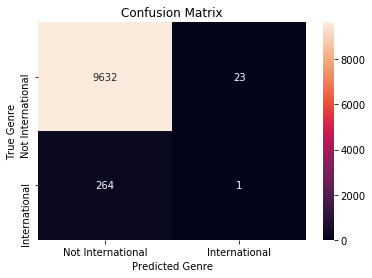

Binary Confusion Matrix for Electronic:


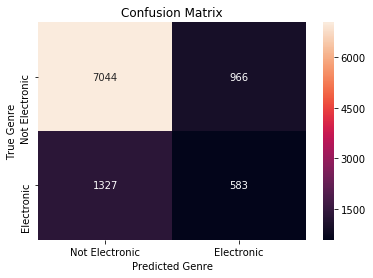

Binary Confusion Matrix for Rock:


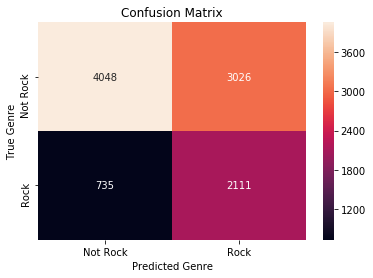

Binary Confusion Matrix for Hip-Hop:


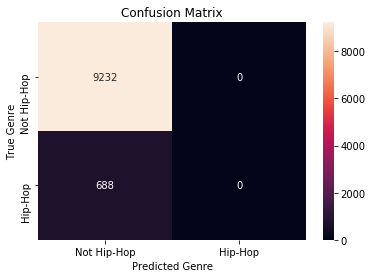

Binary Confusion Matrix for Pop:


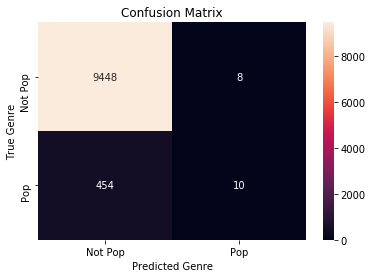

Binary Confusion Matrix for Blues:


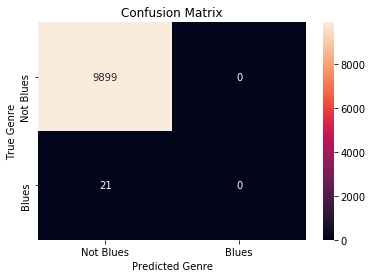

Binary Confusion Matrix for Country:


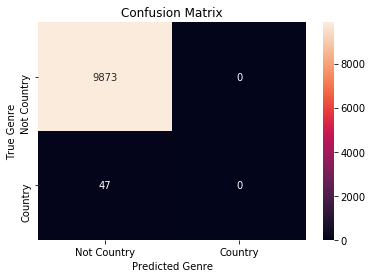

Binary Confusion Matrix for Jazz:


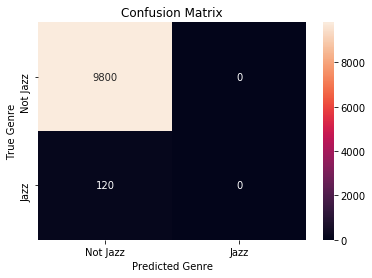

Binary Confusion Matrix for Old-Time / Historic:


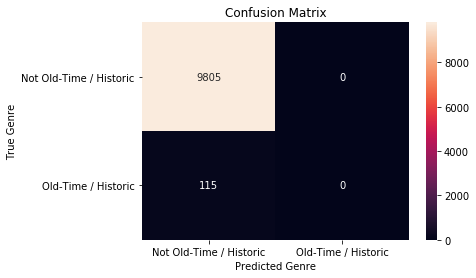

Binary Confusion Matrix for Soul-RnB:


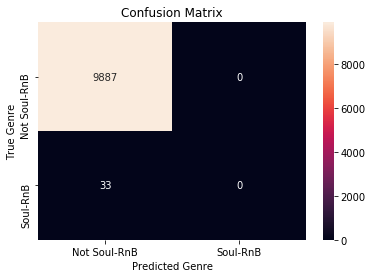

Binary Confusion Matrix for Folk:


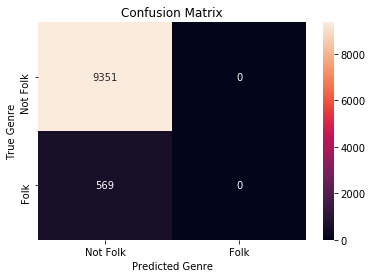

Binary Confusion Matrix for Experimental:


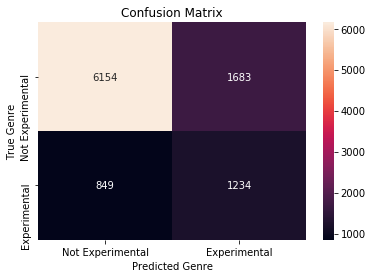

Binary Confusion Matrix for Classical:


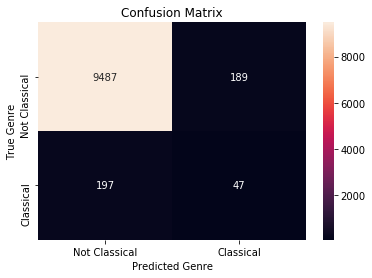

Wall time: 2min 50s


In [107]:
%%time
#Logistic Regression Classifier
from sklearn import linear_model

# Train multi-classification model with logistic regression
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)

# Train multinomial logistic regression
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
mul_lr.fit(X_train, y_train)

#y_pred_lr= lr.predict(X_test)
print ('Logistic Regression Train Accuracy: ', metrics.accuracy_score(y_train, lr.predict(X_train)))
print ('Logistic Regression Test Accuracy: ', metrics.accuracy_score(y_test, lr.predict(X_test)))
print('\n')

y_pred_mullr= mul_lr.predict(X_test)
print ('Multinomial Logistic Regression Train Accuracy: ', metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print ('Multinomial Logistic Regression Test Accuracy: ', metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

#Stats
print('\n')
print(classification_report(y_test, y_pred_mullr))

# Confusion Matrix
confusion_matrix_c(y_test, y_pred_mullr)

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_mullr, col)


### Multinomial Naive-Bayes Classifier

Train Accuracy: 0.07916225616210494
Test Accuracy: 0.08024193548387097


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        21
          Classical       0.05      0.78      0.10       244
            Country       0.00      0.00      0.00        47
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.28      0.18      0.22      1910
       Experimental       0.31      0.04      0.07      2083
               Folk       0.09      0.04      0.05       569
            Hip-Hop       0.17      0.00      0.00       688
       Instrumental       0.07      0.00      0.01       421
      International       0.00      0.00      0.00       265
               Jazz       0.03      0.03      0.03       120
Old-Time / Historic       0.00      0.00      0.00       115
                Pop       0.00      0.00      0.00       464
               Rock       0.34      0.04      0.08      2846
           

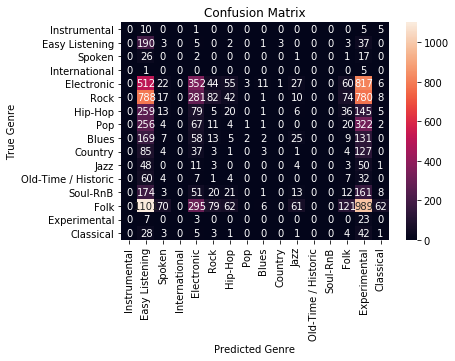

Binary Confusion Matrix for Instrumental:


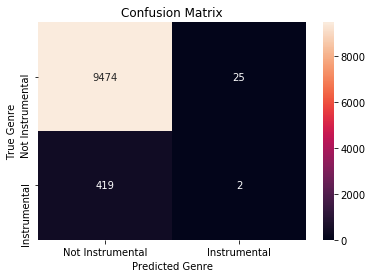

Binary Confusion Matrix for Easy Listening:


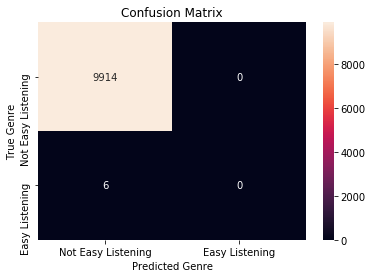

Binary Confusion Matrix for Spoken:


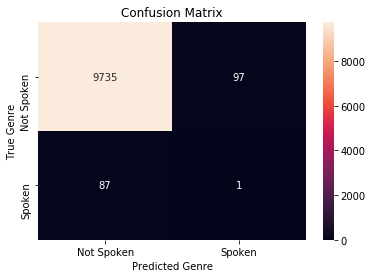

Binary Confusion Matrix for International:


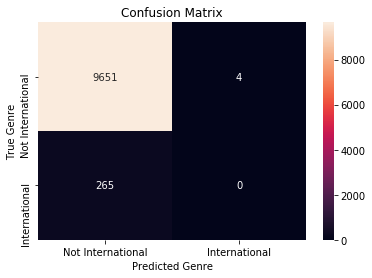

Binary Confusion Matrix for Electronic:


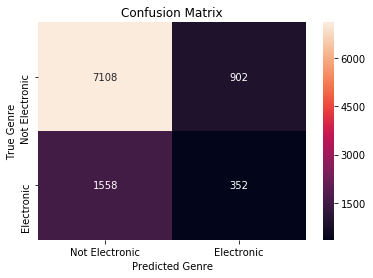

Binary Confusion Matrix for Rock:


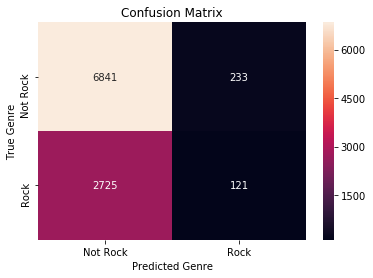

Binary Confusion Matrix for Hip-Hop:


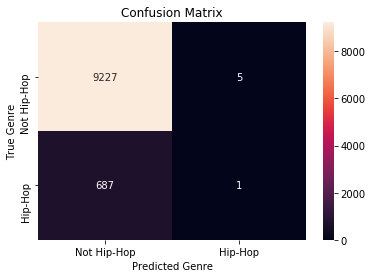

Binary Confusion Matrix for Pop:


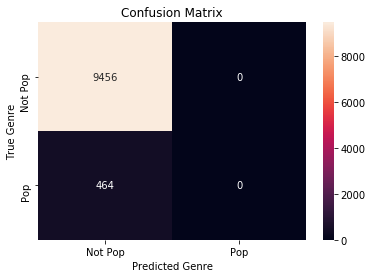

Binary Confusion Matrix for Blues:


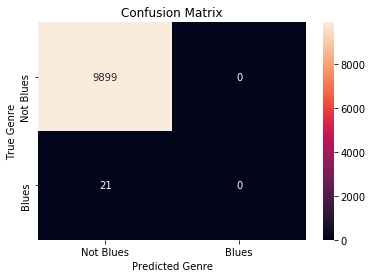

Binary Confusion Matrix for Country:


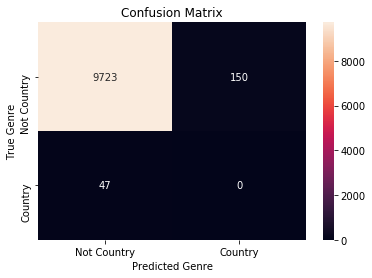

Binary Confusion Matrix for Jazz:


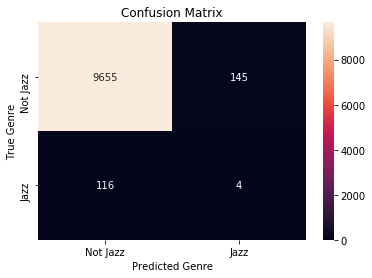

Binary Confusion Matrix for Old-Time / Historic:


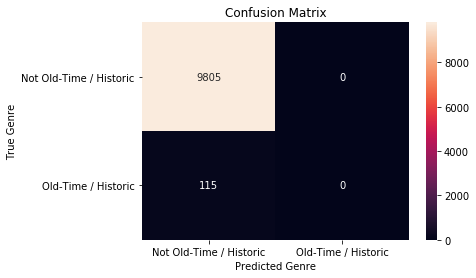

Binary Confusion Matrix for Soul-RnB:


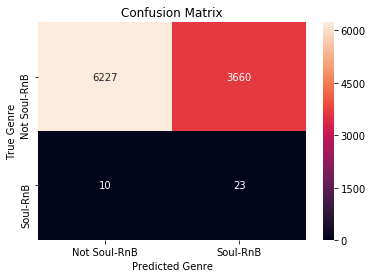

Binary Confusion Matrix for Folk:


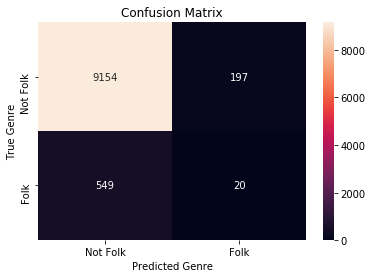

Binary Confusion Matrix for Experimental:


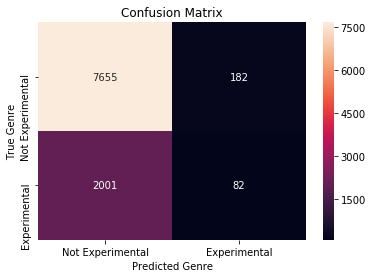

Binary Confusion Matrix for Classical:


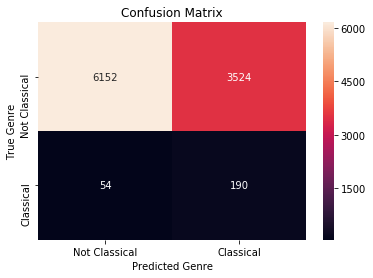

Wall time: 13 s


In [336]:
%%time
#Multinomial Naive Bayes Classifier

#Import Multinomial Naive Bayes model (used for categorical predictions)
from sklearn.naive_bayes import MultinomialNB

#Create a Multinomial Classifier
mnb = MultinomialNB()

#Train the model using the training sets
mnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_mnb = mnb.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, mnb.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_mnb))

#Stats
print('\n')
print(classification_report(y_test, y_pred_mnb))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_mnb) 

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_mnb, col)

### KNN Classifier

#### Parameter Tuning

In [69]:
# try K=1 through K=25 and record testing accuracy
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred_knn))

print(scores)

[0.9013104838709678, 0.8872983870967742, 0.875, 0.8640120967741935, 0.8492943548387096, 0.8340725806451613, 0.818649193548387, 0.8009072580645161, 0.7851814516129032, 0.7653225806451613, 0.7469758064516129, 0.7372983870967742, 0.726008064516129, 0.7123991935483871, 0.7006048387096774, 0.6819556451612904, 0.6710685483870967, 0.6595766129032258, 0.6524193548387097, 0.6432459677419354, 0.6373991935483871, 0.6298387096774194, 0.6238911290322581, 0.6171370967741936, 0.6108870967741935]


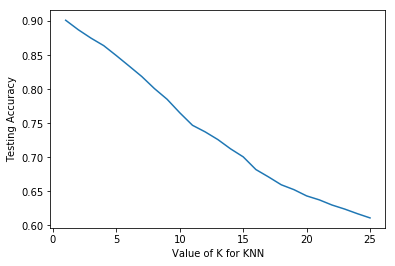

In [70]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.figure()
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

#### Optimized Model (n_neighbors = 1)

Train Accuracy: 1.0
Test Accuracy: 0.9013104838709678
                     precision    recall  f1-score   support

              Blues       0.80      0.76      0.78        21
          Classical       0.90      0.92      0.91       244
            Country       0.92      0.96      0.94        47
     Easy Listening       0.71      0.83      0.77         6
         Electronic       0.90      0.88      0.89      1910
       Experimental       0.90      0.89      0.90      2083
               Folk       0.89      0.94      0.92       569
            Hip-Hop       0.93      0.95      0.94       688
       Instrumental       0.89      0.86      0.88       421
      International       0.82      0.84      0.83       265
               Jazz       0.81      0.87      0.84       120
Old-Time / Historic       0.65      0.41      0.50       115
                Pop       0.86      0.88      0.87       464
               Rock       0.92      0.95      0.94      2846
           Soul-RnB       0.97

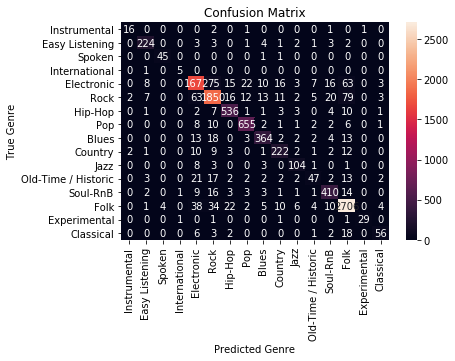

Binary Confusion Matrix for Instrumental:


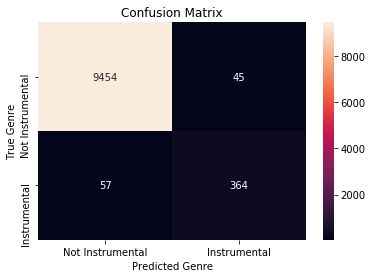

Binary Confusion Matrix for Easy Listening:


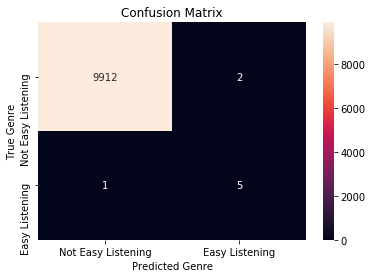

Binary Confusion Matrix for Spoken:


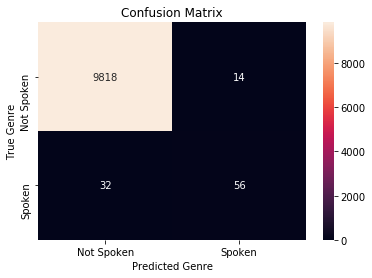

Binary Confusion Matrix for International:


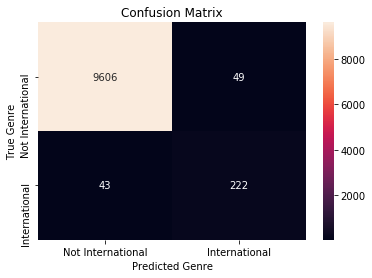

Binary Confusion Matrix for Electronic:


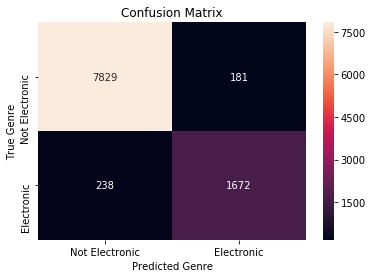

Binary Confusion Matrix for Rock:


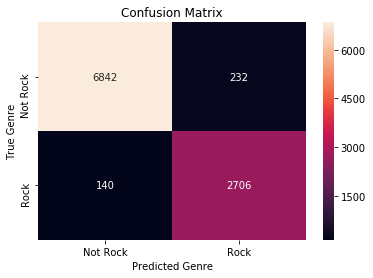

Binary Confusion Matrix for Hip-Hop:


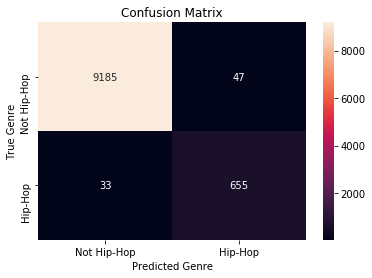

Binary Confusion Matrix for Pop:


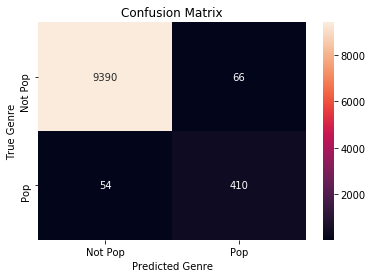

Binary Confusion Matrix for Blues:


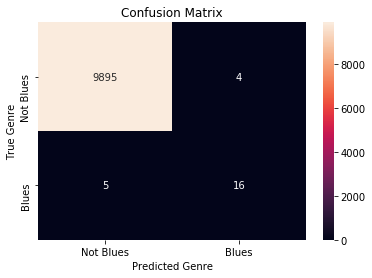

Binary Confusion Matrix for Country:


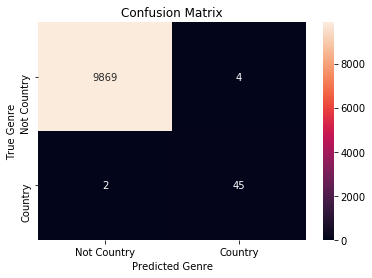

Binary Confusion Matrix for Jazz:


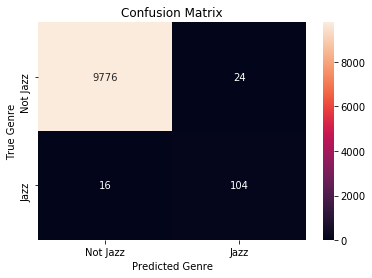

Binary Confusion Matrix for Old-Time / Historic:


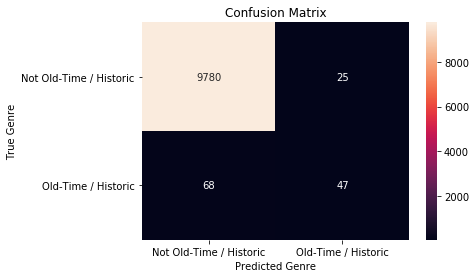

Binary Confusion Matrix for Soul-RnB:


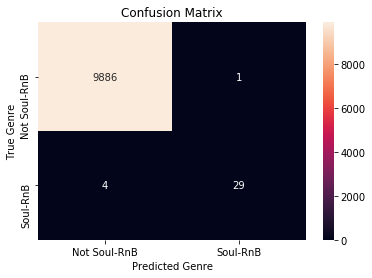

Binary Confusion Matrix for Folk:


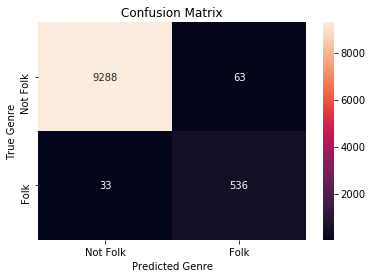

Binary Confusion Matrix for Experimental:


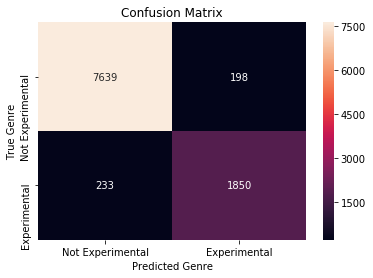

Binary Confusion Matrix for Classical:


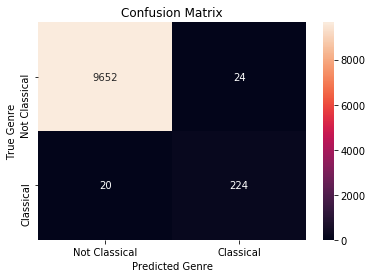

Wall time: 17.2 s


In [339]:
%%time
#KNN Classifier (K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Train Accuracy:", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred_knn))

#Stats
print(classification_report(y_test, y_pred_knn))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_knn) 

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_knn, col)

### SVM and Kernel SVM

In [ ]:
%%time
#Support Vector Machine
from sklearn.svm import SVC
svc = SVC(kernel = 'linear',random_state = 42,probability=True)
svc.fit(X_train,y_train)

# Predicting the Test set results 
y_pred_svc= svc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svc))

#Stats
print(classification_report(y_test,y_pred_svc))
 
#Confusion Matrix
confusion_matrix_c(y_test, y_pred_svc) 

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_svc, col)

In [ ]:
%%time
# Kernel SVM
ksvc = SVC(kernel = 'rbf',random_state = 42,probability=True)
ksvc.fit(X_train,y_train)

# Predicting the Test set results
y_pred_ksvc= ksvc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_ksvc))

#Stats
print(classification_report(y_test,y_pred_ksvc))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_ksvc) 

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_ksvc, col)

Both Support Vector Machine (SVM) and Kernel SVM have very high time complexity for large datasets. We tried running both models and they ran for several hours without producing any results, so they were not useful for the purposes of this project.

### Decision Tree Classifier

#### Parameter Tuning

In [85]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid={'max_depth':range(1,len(X.columns),2) ,
            'max_features':range(1,len(X.columns),2)}
dt_g=DecisionTreeClassifier(random_state = 42)
dt_cv=GridSearchCV(dt_g,param_grid,cv=10,scoring='accuracy',n_jobs=-1)
dt_cv.fit(X_train,y_train)

print("Best parameters:",dt_cv.best_params_)
print("Accuracy :",dt_cv.best_score_)

Best parameters: {'max_depth': 9, 'max_features': 7}
Accuracy : 0.5101567619335652


#### Optimized Model - {'max_depth' = 9, 'max_features' = 7}

Train Accuracy: 0.5332930087201976
Test Accuracy: 0.459375


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        21
          Classical       0.30      0.60      0.40       244
            Country       0.00      0.00      0.00        47
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.47      0.34      0.40      1910
       Experimental       0.58      0.55      0.57      2083
               Folk       0.33      0.07      0.11       569
            Hip-Hop       0.30      0.09      0.14       688
       Instrumental       0.58      0.20      0.30       421
      International       0.68      0.16      0.26       265
               Jazz       0.50      0.03      0.06       120
Old-Time / Historic       0.80      0.10      0.18       115
                Pop       0.87      0.19      0.31       464
               Rock       0.42      0.79      0.55      2846
           Soul-RnB    

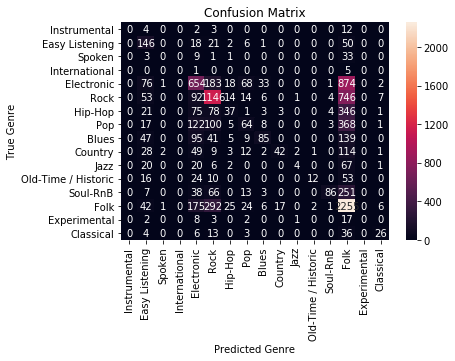

Binary Confusion Matrix for Instrumental:


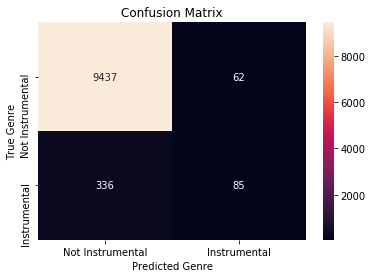

Binary Confusion Matrix for Easy Listening:


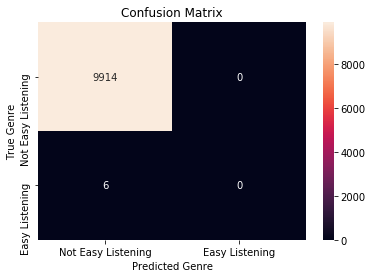

Binary Confusion Matrix for Spoken:


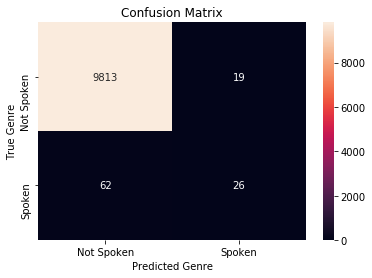

Binary Confusion Matrix for International:


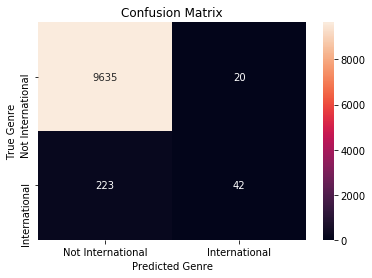

Binary Confusion Matrix for Electronic:


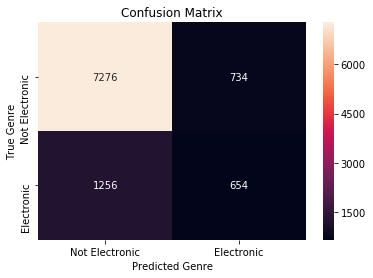

Binary Confusion Matrix for Rock:


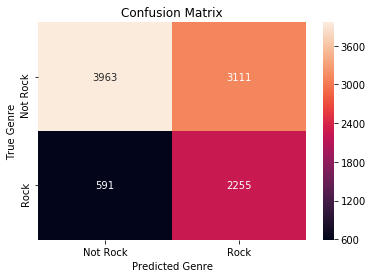

Binary Confusion Matrix for Hip-Hop:


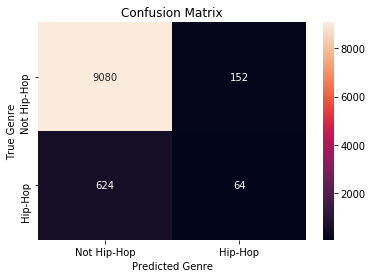

Binary Confusion Matrix for Pop:


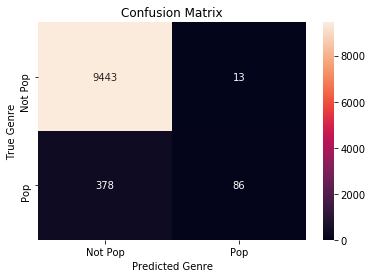

Binary Confusion Matrix for Blues:


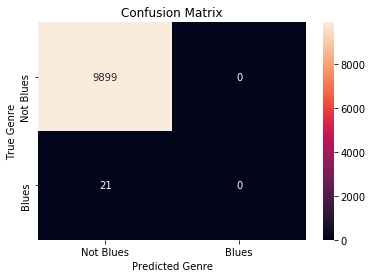

Binary Confusion Matrix for Country:


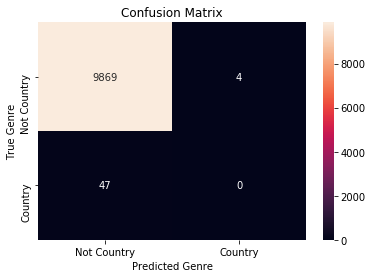

Binary Confusion Matrix for Jazz:


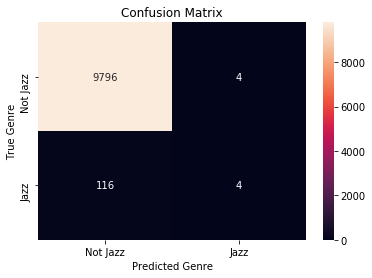

Binary Confusion Matrix for Old-Time / Historic:


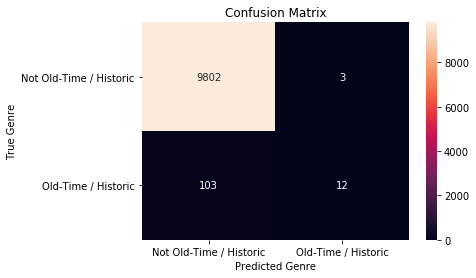

Binary Confusion Matrix for Soul-RnB:


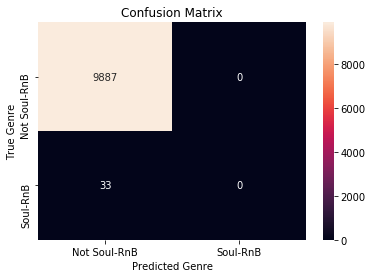

Binary Confusion Matrix for Folk:


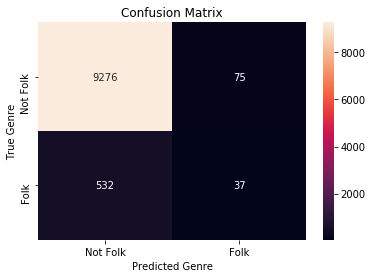

Binary Confusion Matrix for Experimental:


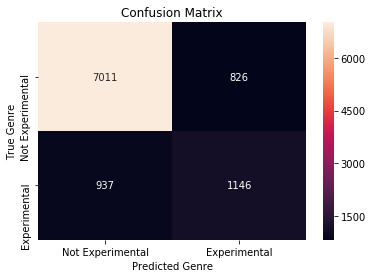

Binary Confusion Matrix for Classical:


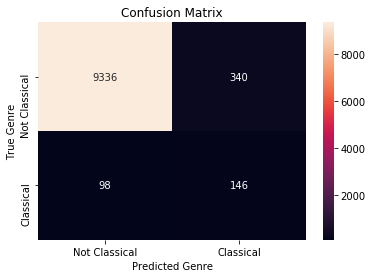

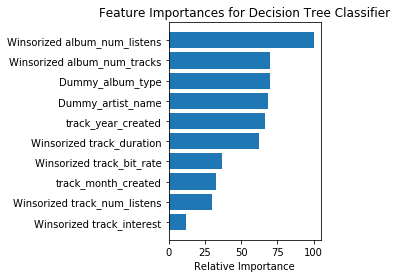

Wall time: 12.8 s


In [169]:
%%time
# Logistic Regression
dt = DecisionTreeClassifier(max_depth=dt_cv.best_params_['max_depth'],max_features=dt_cv.best_params_['max_features'],random_state = 42)
dt.fit(X_train,y_train)

# Predicting the Test set results
y_pred_dt= dt.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, dt.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_dt))
print('\n')

#Stats
print(classification_report(y_test,y_pred_dt))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_dt) 

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_dt, col)
        
# Plot of relative feature importances
feature_importance_plt(dt, X_train, 'Decision Tree Classifier')

### Random Forest Classifier

#### Parameter Tuning

In [346]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# GridSearchCV
param_grid={'max_depth':range(1,len(X.columns),2),
            'max_features':range(1,len(X.columns),2)}
rf_g=RandomForestClassifier(random_state=42)
rf_cv=GridSearchCV(rf_g,param_grid,cv=10,scoring='f1_micro',n_jobs=-1)
rf_cv.fit(X_train,y_train)

print("Best parameters:",rf_cv.best_params_)
print("Accuracy :",rf_cv.best_score_)

Best parameters: {'max_depth': 9, 'max_features': 5}
Accuracy : 0.5470033771863502


#### Optimized Model - {'max_depth' = 9, 'max_features' = 5}

Train Accuracy: 0.5782297494833409
Test Accuracy: 0.5034274193548387


                     precision    recall  f1-score   support

              Blues       1.00      0.05      0.09        21
          Classical       0.51      0.57      0.54       244
            Country       0.00      0.00      0.00        47
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.49      0.44      0.47      1910
       Experimental       0.60      0.67      0.63      2083
               Folk       0.90      0.03      0.06       569
            Hip-Hop       0.96      0.04      0.08       688
       Instrumental       0.85      0.22      0.35       421
      International       0.80      0.11      0.19       265
               Jazz       0.80      0.03      0.06       120
Old-Time / Historic       1.00      0.17      0.28       115
                Pop       1.00      0.16      0.27       464
               Rock       0.44      0.82      0.57      2846
           So

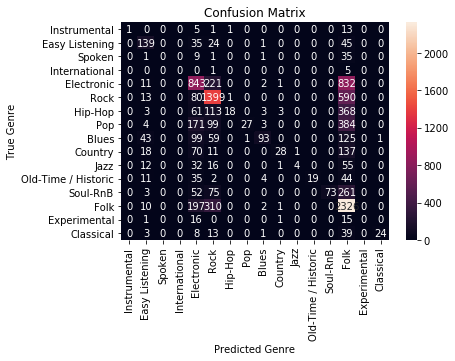

Binary Confusion Matrix for Instrumental:


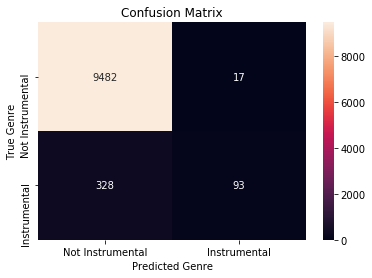

Binary Confusion Matrix for Easy Listening:


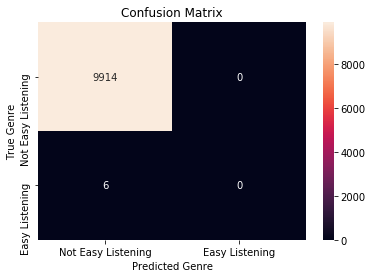

Binary Confusion Matrix for Spoken:


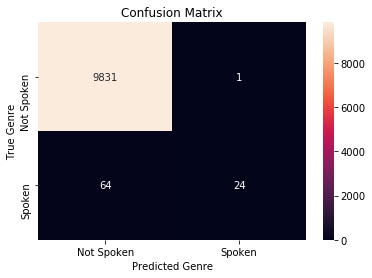

Binary Confusion Matrix for International:


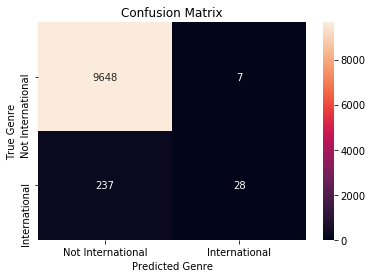

Binary Confusion Matrix for Electronic:


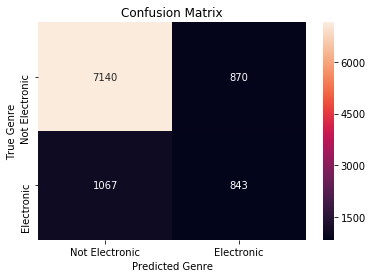

Binary Confusion Matrix for Rock:


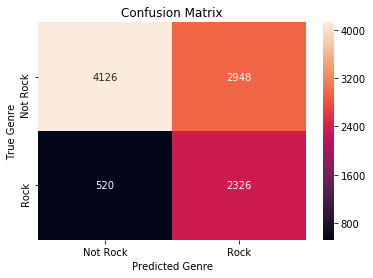

Binary Confusion Matrix for Hip-Hop:


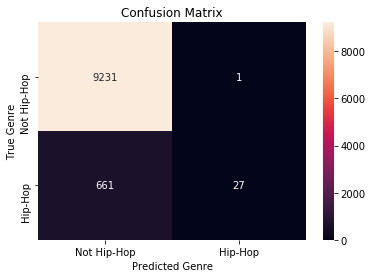

Binary Confusion Matrix for Pop:


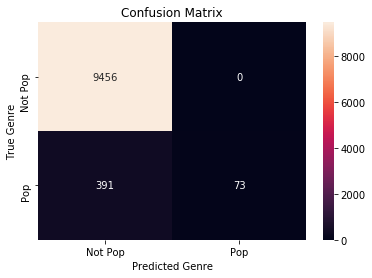

Binary Confusion Matrix for Blues:


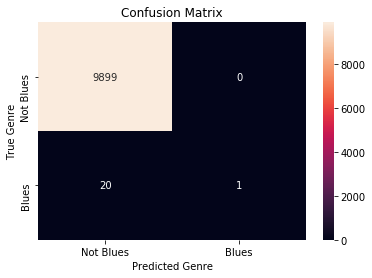

Binary Confusion Matrix for Country:


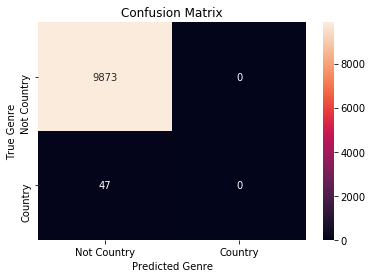

Binary Confusion Matrix for Jazz:


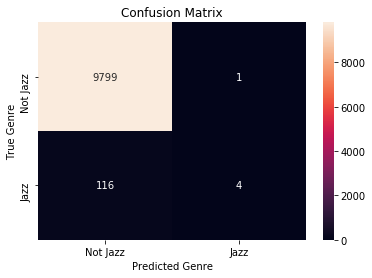

Binary Confusion Matrix for Old-Time / Historic:


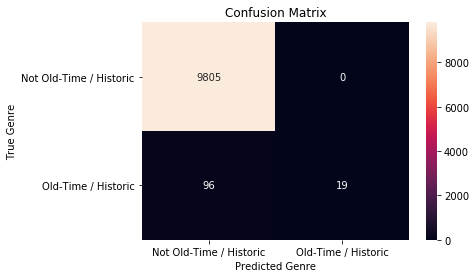

Binary Confusion Matrix for Soul-RnB:


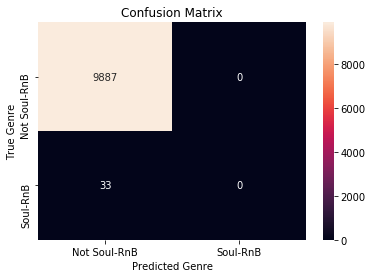

Binary Confusion Matrix for Folk:


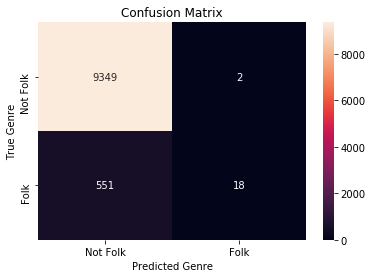

Binary Confusion Matrix for Experimental:


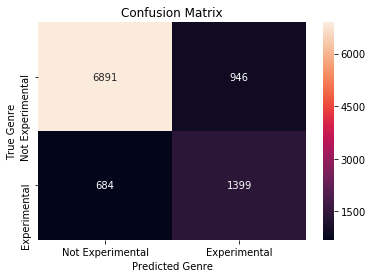

Binary Confusion Matrix for Classical:


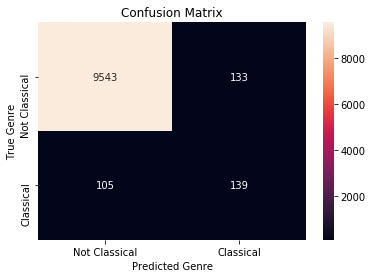

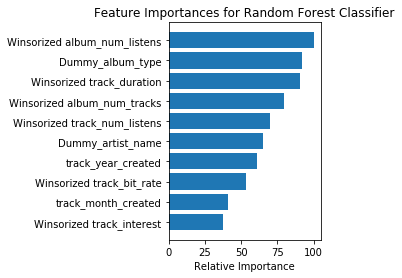

Wall time: 1min 3s


In [112]:
%%time
# Logistic Regression
rf = RandomForestClassifier(max_depth=rf_cv.best_params_['max_depth'],max_features=rf_cv.best_params_['max_features'],n_estimators=250,random_state=42)
rf.fit(X_train,y_train)

# Predicting the Test set results
y_pred_rf = rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print('\n')

#Stats
print(classification_report(y_test,y_pred_rf))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_rf) 

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_rf, col)
    
# Plot of relative feature importances
feature_importance_plt(rf, X_train, 'Random Forest Classifier')

### Gradient Boosting Classifier

#### Parameter Tuning

In [115]:
#Gradient Boosting Classifier 
from sklearn.ensemble import GradientBoostingClassifier

# GridSearchCV
param_grid={'max_depth':range(1,len(X_train.columns),2) }
gb_g = GradientBoostingClassifier(random_state=42)
gb_cv = GridSearchCV(gb_g,param_grid,cv=10,scoring='accuracy',n_jobs=-1)
gb_cv.fit(X_train,y_train)

print("Best parameters:", gb_cv.best_params_)
print("Accuracy :", gb_cv.best_score_)

Best parameters: {'max_depth': 9}
Accuracy : 0.9261303493119613


#### Optimized Model - {'max_depth' = 9}

Train Accuracy: 0.9993447250365441
Test Accuracy: 0.8262096774193548


                     precision    recall  f1-score   support

              Blues       1.00      0.71      0.83        21
          Classical       0.86      0.91      0.88       244
            Country       0.93      0.91      0.92        47
     Easy Listening       1.00      0.83      0.91         6
         Electronic       0.83      0.83      0.83      1910
       Experimental       0.80      0.93      0.86      2083
               Folk       0.77      0.67      0.72       569
            Hip-Hop       0.93      0.51      0.66       688
       Instrumental       0.94      0.80      0.87       421
      International       0.88      0.74      0.80       265
               Jazz       0.91      0.49      0.64       120
Old-Time / Historic       1.00      0.62      0.76       115
                Pop       0.94      0.78      0.85       464
               Rock       0.80      0.90      0.85      2846
           So

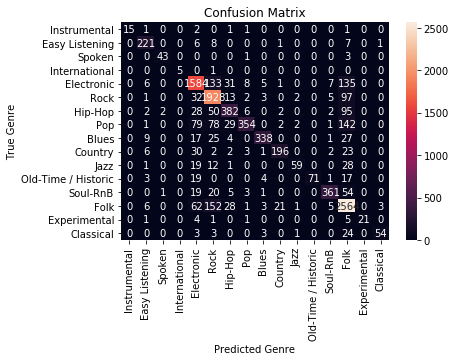

Binary Confusion Matrix for Instrumental:


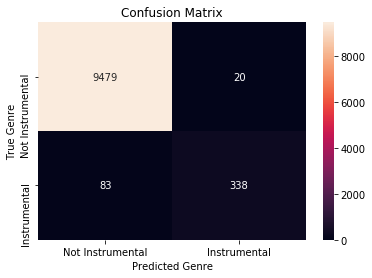

Binary Confusion Matrix for Easy Listening:


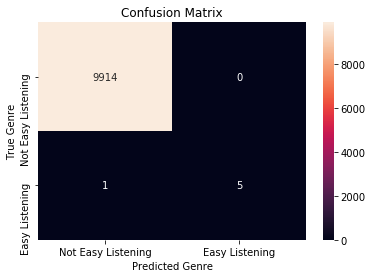

Binary Confusion Matrix for Spoken:


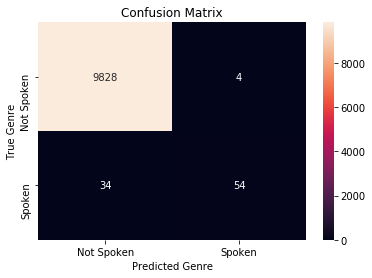

Binary Confusion Matrix for International:


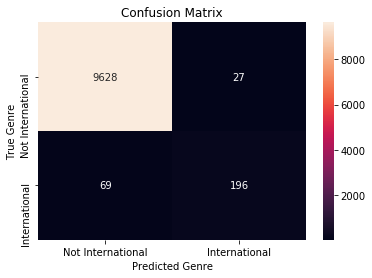

Binary Confusion Matrix for Electronic:


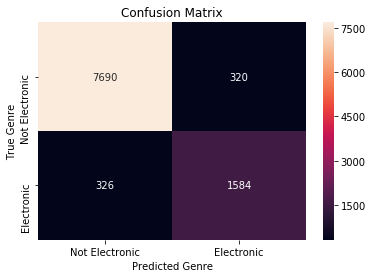

Binary Confusion Matrix for Rock:


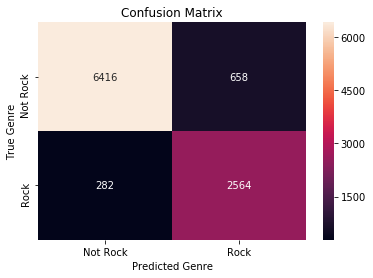

Binary Confusion Matrix for Hip-Hop:


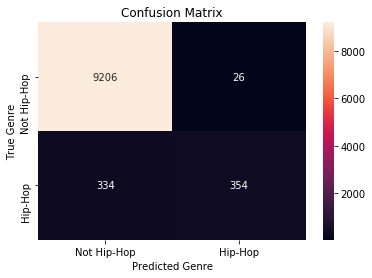

Binary Confusion Matrix for Pop:


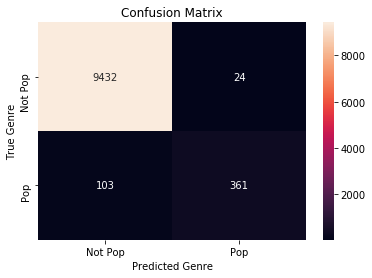

Binary Confusion Matrix for Blues:


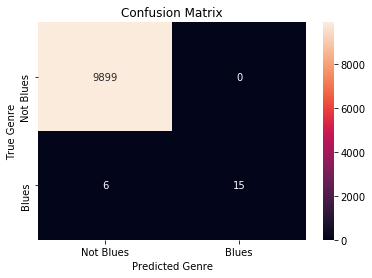

Binary Confusion Matrix for Country:


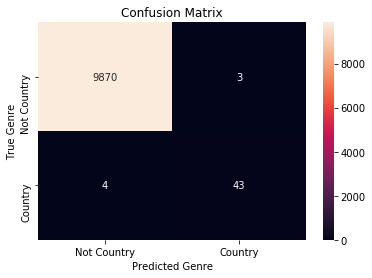

Binary Confusion Matrix for Jazz:


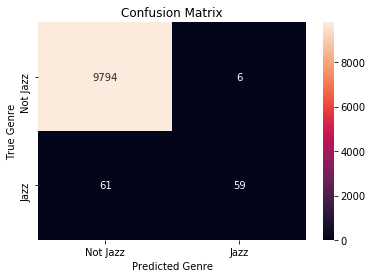

Binary Confusion Matrix for Old-Time / Historic:


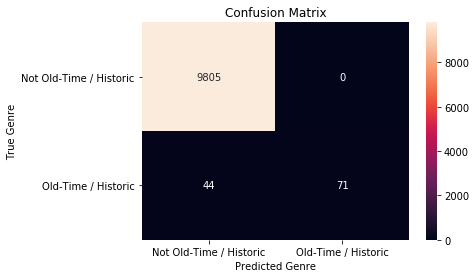

Binary Confusion Matrix for Soul-RnB:


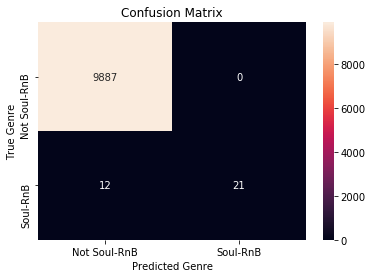

Binary Confusion Matrix for Folk:


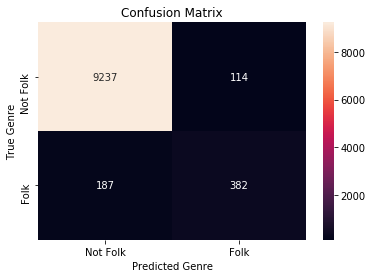

Binary Confusion Matrix for Experimental:


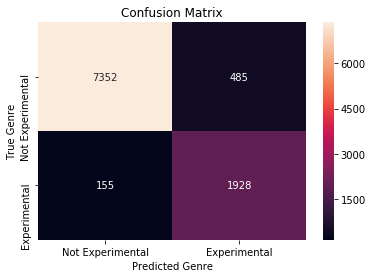

Binary Confusion Matrix for Classical:


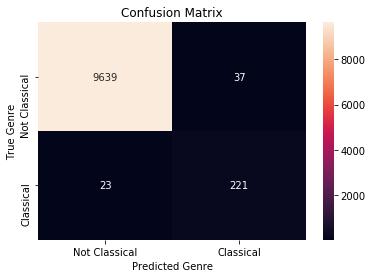

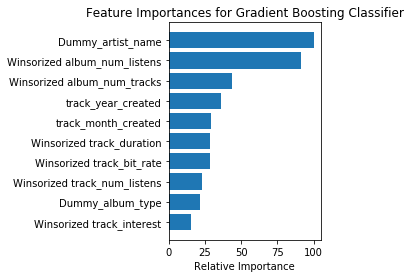

Wall time: 12min 24s


In [117]:
%%time
# Logistic Regression
gbc = GradientBoostingClassifier(max_depth=gb_cv.best_params_['max_depth'], random_state=42)
gbc.fit(X_train,y_train)

# Predicting the Test set results
y_pred_gbc= gbc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy:",metrics.accuracy_score(y_train, gbc.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_gbc))
print('\n')

#Stats
print(classification_report(y_test,y_pred_gbc))

#Confusion Matrix
confusion_matrix_c(y_test, y_pred_gbc) 

# Individual Confusion Matrices
for col in gen_cols:
    print('Binary Confusion Matrix for ' + col + ':')
    binary_confusion_matrix_c(y_test,y_pred_gbc, col)
    
# Plot of relative feature importances
feature_importance_plt(gbc, X_train, 'Gradient Boosting Classifier')

## Single-Label Dataset Conclusions:
In the analysis of all tracks that were labeled with only one genre, we tested a total of 9 machine learning classification models, utilizing a single dummy variable to represent our target feature, genre label. The Dummy_genre feature took on values between 0 and 15, each value representing one of the unique genre labels. Two of the models, SVM and Kernel SVM, proved to have too high a time-complexity to realistically use for the analysis of the 50,000ish track single-label dataset, so they were discarded. Logistic Regression and Multinomial Logistic Regression classification models obtained accuracy scores of 38% and 40%, respectively, and took approximately 3 minutes to run both models consecutively. Therefore, the logistic regression models did well from a time-complexity standpoint, but had too low accuracy to be considered useful.  
The Multinomial Naive-Bayes Classifier, while it had a very low runtime (13 seconds), it also had one of the lowest accuracy scores of the models tested (8%). On the other end of the spectrum, the k-Nearest Neighbor Classification model, with an optimized n_neighbors value of 1, produced an accuracy of 90% in only 17 seconds of runtime. Although KNN provided very good accuracy results, three additional models were tested to see if we could improve accuracy or runtime even more. 

Even after iterating through many possibilities to determine the optimal parameters for each model, the highest accuracy scores produced by the Decision Tree Classifier and Random Forest Classifier were 46% and 50%, respectively. The Decision Tree had a relatively low time complexity (12 seconds), while the Random Forest had a higher runtime (1 minute), and it's interesting to note that both of those models had album_num_listens as their 'most important' feature. The final model was a Gradient Boosting Classifier, which had relatively high accuracy (between 80 and 90%), but had an extremely high runtime (12+ minutes.

So, overall, we found that the best model for predicting a single genre label, when provided with all of the other relevant features as inputs, was a KNN Classifier, using 1 neighbor as the main parameter. However, it's important to note that the under-represented genre labels had higher Type I and Type II error rates than the other labels, so it may be necessary to perform undersampling or oversampling in future experiments to correct for the dataset's significant class imbalances.

### Multi-Label Dataset Modeling and Analysis

In [100]:
multigen_df.columns

Index(['album_type', 'artist_name', 'track_bit_rate', 'track_duration',
       'track_genre_top', 'track_interest', 'album_num_listens',
       'album_num_tracks', 'track_num_listens', 'track_year_created',
       'track_month_created', 'Dummy_album_type', 'str_track_genres',
       'Country', 'Hip-Hop', 'International', 'Blues', 'Instrumental',
       'Soul-RnB', 'Classical', 'Old-Time / Historic', 'Folk', 'Pop',
       'Easy Listening', 'Electronic', 'Rock', 'Experimental', 'Spoken',
       'Jazz'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

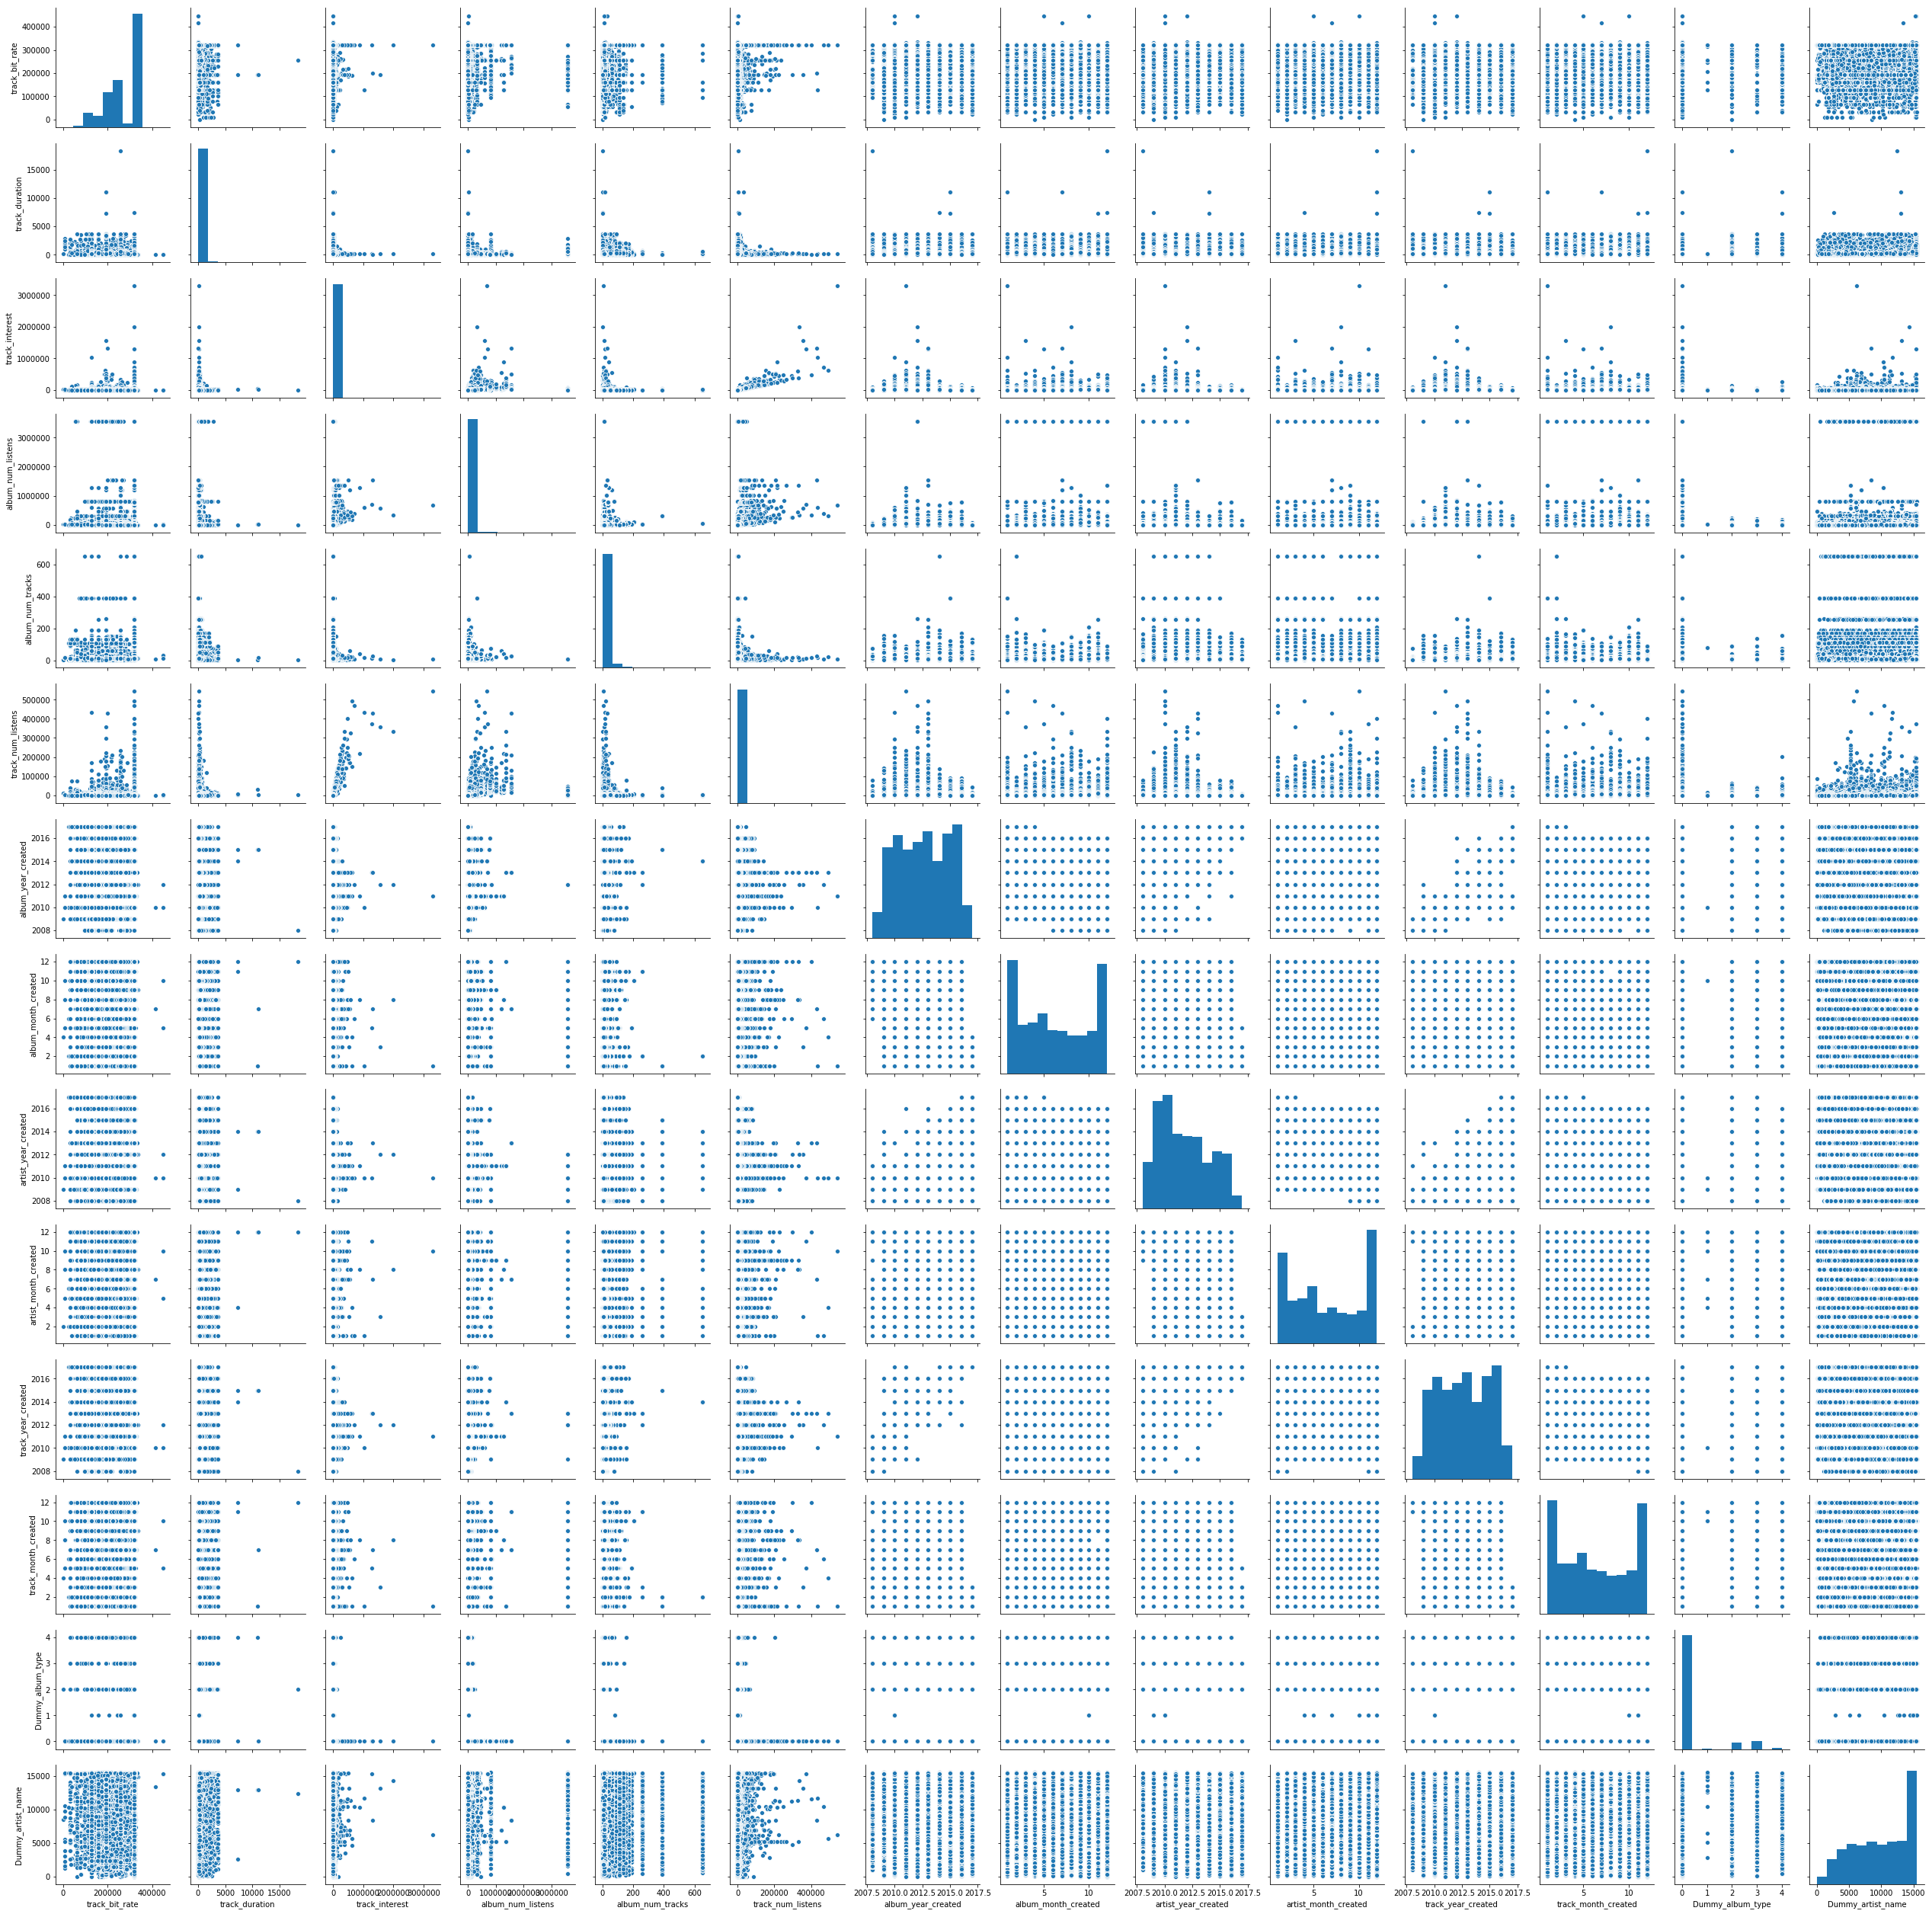

In [42]:
#Scatter Matrix
plt.figure()
sns.pairplot(multigen_df[multigen_df.columns.drop(categories)])
plt.show()

In [101]:
uniques = pd.DataFrame()
uni_col = []
num_uni = []
avgdiff_uni = []

for col in list(multigen_df.columns):
    try:
        uni_col.append(list(np.unique(multigen_df[col])))
        num_uni.append(len(np.unique(multigen_df[col])))
    except:
        uni_col.append(list((multigen_df[col]).unique()[pd.notnull(list((multigen_df[col]).unique()))]))
        num_uni.append(len((multigen_df[col]).unique()[pd.notnull(list((multigen_df[col]).unique()))]))
        
    try:
        avgdiff_uni.append(np.mean(np.diff(np.unique(multigen_df[col]))))
    except: 
        avgdiff_uni.append('N/A')
    
uniques['Category'] = list(multigen_df.columns)
uniques['Unique Values'] = uni_col
uniques['Num Uniques'] = num_uni
uniques['Avg Diff Among Uniques'] = avgdiff_uni

uniques

Category                                      Unique Values  \
0            album_type  [Album, Contest, Live Performance, Radio Progr...   
1           artist_name  ["Blue" Gene Tyranny, #CCmixtape, ( Early ) Sa...   
2        track_bit_rate  [31281.0, 31742.0, 32000.0, 34441.0, 37617.0, ...   
3        track_duration  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
4       track_genre_top  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
5        track_interest  [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0...   
6     album_num_listens  [108.0, 128.0, 130.0, 134.0, 136.0, 142.0, 154...   
7      album_num_tracks  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
8     track_num_listens  [1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...   
9    track_year_created  [2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013....   
10  track_month_created  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
11     Dummy_album_type                                    [0, 1, 2, 3, 4]   
12     str_track_genres  [[Blues, Classical], [Blues, Classical, Electr...   
13              Country                                         [0.0, 1.0]   
14              Hip-Hop                                         [0.0, 1.0]   
15        International                                         [0.0, 1.0]   
16                Blues                                         [0.0, 1.0]   
17         Instrumental                                         [0.0, 1.0]   
18             Soul-RnB                                         [0.0, 1.0]   
19            Classical                                         [0.0, 1.0]   
20  Old-Time / Historic                                         [0.0, 1.0]   
21                 Folk                                         [0.0, 1.0]   
22                  Pop                                         [0.0, 1.0]   
23       Easy Listening                                         [0.0, 1.0]   
24           Electronic                                         [0.0, 1.0]   
25                 Rock                                         [0.0, 1.0]   
26         Experimental                                         [0.0, 1.0]   
27               Spoken                                         [0.0, 1.0]   
28                 Jazz                                         [0.0, 1.0]   

    Num Uniques Avg Diff Among Uniques  
0             5                    N/A  
1          8084                    N/A  
2          6632                62.8441  
3          1759                10.4374  
4         54744                    NaN  
5         12259                127.554  
6          6265                568.987  
7            90                2.30337  
8         10292                47.7343  
9            10                      1  
10           12                      1  
11            5                      1  
12          441                    N/A  
13            2                      1  
14            2                      1  
15            2                      1  
16            2                      1  
17            2                      1  
18            2                      1  
19            2                      1  
20            2                      1  
21            2                      1  
22            2                      1  
23            2                      1  
24            2                      1  
25            2                      1  
26            2                      1  
27            2                      1  
28            2                      1

In [111]:
#Separate features by type

#Boolean genre cols:
gen_cols = list(categories)

#String categoricals:
str_cat_cols = []
for col in list(multigen_df.columns):
    if col not in gen_cols:   
        if (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] == 'N/A') or pd.isnull(list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0]):
            str_cat_cols.append(col)

#Categorical features:
cat_cols = []
for col in list(multigen_df.columns):
    if (col not in gen_cols) and (col not in str_cat_cols):   
        if (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 3):
            cat_cols.append(col)

#Continuous features:
cont_cols = []
for col in list(multigen_df.columns):
    if ((col not in gen_cols) and (col not in cat_cols) and (col not in str_cat_cols)):
        cont_cols.append(col)
        
print('Genre Dummy Features: \n', gen_cols)

print('\nString Categorical Features: \n', str_cat_cols)

print('\nCategorical Features: \n', cat_cols)

print('\nContinuous Features: \n', cont_cols)

Genre Dummy Features: 
 ['Country', 'Hip-Hop', 'International', 'Blues', 'Instrumental', 'Soul-RnB', 'Classical', 'Old-Time / Historic', 'Folk', 'Pop', 'Easy Listening', 'Electronic', 'Rock', 'Experimental', 'Spoken', 'Jazz']

String Categorical Features: 
 ['album_type', 'artist_name', 'track_genre_top', 'str_track_genres']

Categorical Features: 
 ['album_num_tracks', 'track_year_created', 'track_month_created', 'Dummy_album_type']

Continuous Features: 
 ['track_bit_rate', 'track_duration', 'track_interest', 'album_num_listens', 'track_num_listens']


This split of types of features is identical to the single-label analysis except the multi-label analysis doesn't contain the categorical feature 'Dummy_genre.'

#### Distributions of Continuous Feature Values for Multi-Label Tracks

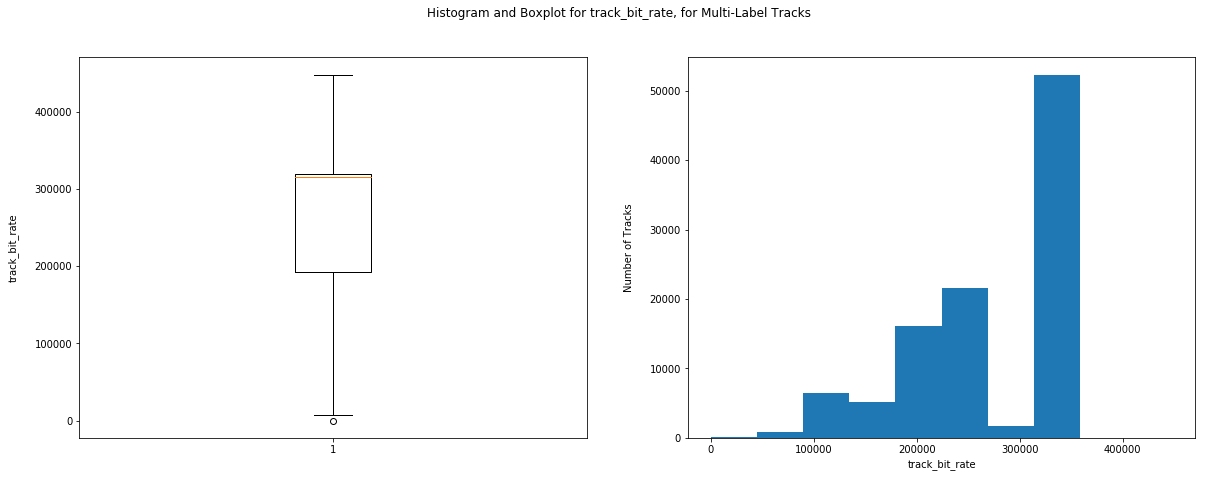

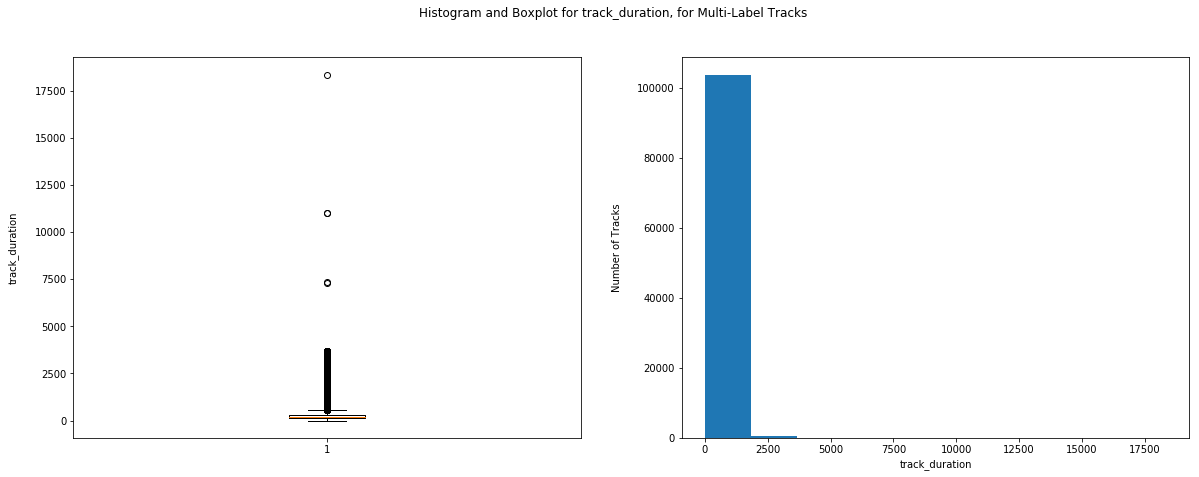

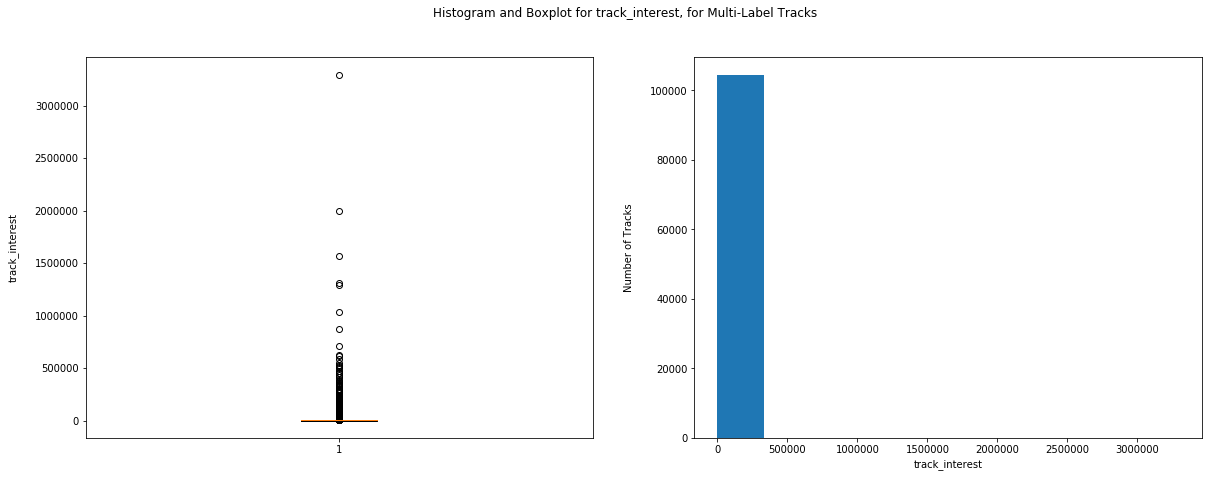

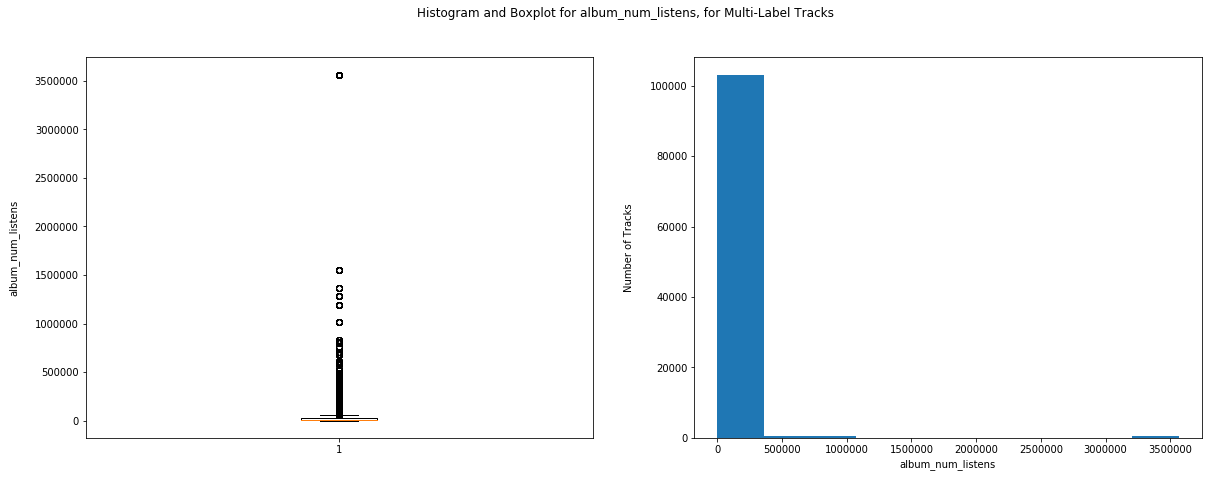

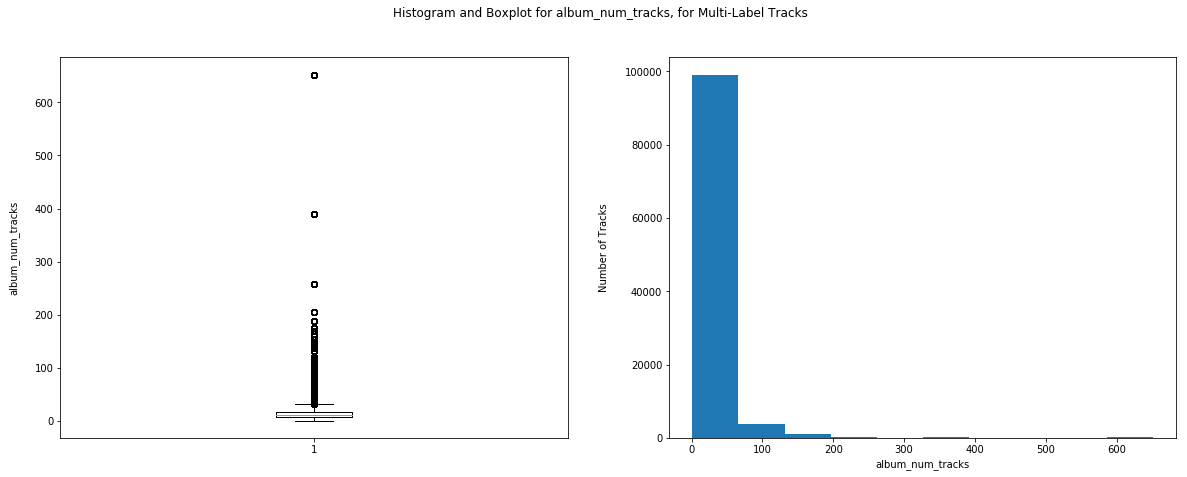

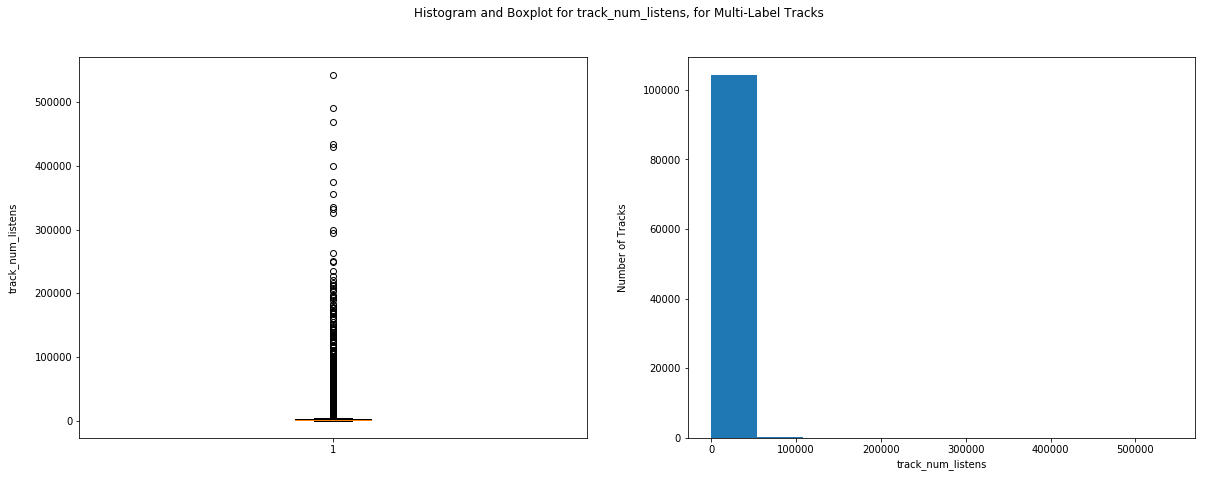

In [51]:
#Distributions of features
for col in cont_cols:
    plt.figure(figsize=(20, 7))
    
    plt.subplot(1,2,1)
    plt.boxplot(multigen_df[col])
    plt.xlabel('')
    plt.ylabel(col +'\n')
    
    plt.subplot(1,2,2)    
    plt.hist(multigen_df[col])
    plt.xlabel(col)
    plt.ylabel('Number of Tracks\n')
    
    plt.suptitle('Histogram and Boxplot for ' + col + ', for Multi-Label Tracks\n')
    plt.show()

As with the single-label analysis, this multi-label dataset has issues with outliers skewing toward high values and non-normal distributions.

#### Mode Genres for Multi-Label Tracks, with respect to Categorical Features

In [112]:
cat_cols

['album_num_tracks',
 'track_year_created',
 'track_month_created',
 'Dummy_album_type']

<Figure size 3600x3600 with 0 Axes>

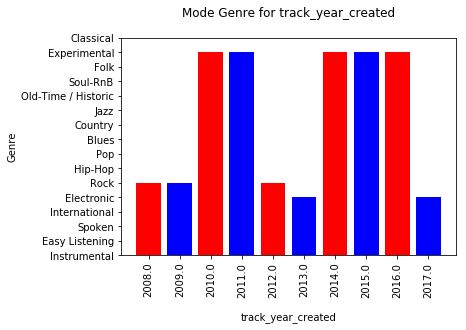

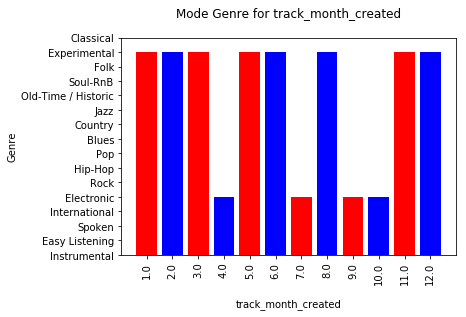

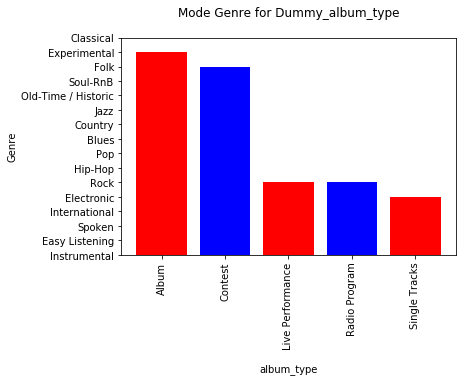

In [182]:
#Analyze all of the categorical variables, with respect to genre
cols = ['track_year_created','track_month_created','album_type']
#Bar chart with genre on the y-axis and categorical variable on the x-axis
plt.figure(figsize=(50, 50))

for i in range(len(cat_cols[:-1])):
    fig, ax = plt.subplots()
    inds = range(len(np.unique(multigen_df[cat_cols[i]])))
    lsts = [([item for sublist in [[j for j, x in enumerate((list(multigen_df.groupby(cat_cols[i]))[y][1][gen_cols].iloc[row])) if x == 1] for row in range(len(list(multigen_df.groupby(cat_cols[i]))[y][1][gen_cols]))] for item in sublist]) for y in range(len(np.unique(multigen_df[cat_cols[i]])))]
    values = [max(set(lst), key=lst.count) for lst in lsts]
    plt.bar(inds, values, color=('red','blue'))
    plt.title('Mode Genre for ' + cat_cols[i] + '\n')
    plt.ylabel('Genre')
    ax.set_yticks(list(range(len(gen_cols))))
    ax.set_yticklabels(gen_cols)
    plt.xlabel('\n' + cols[i])
    ax.set_xticks(list(range(len(np.unique(multigen_df[cols[i]])))))
    ax.set_xticklabels(np.unique(multigen_df[cols[i]]), rotation='vertical')
    
    plt.show()

The mode genres for each category tend to be 'Experimental,' 'Electronic,' and 'Rock,' just as with the single-label dataset. The main difference is that in the multi-label dataset, 'Folk' is a common genre for the 'Contest' category of album_type.

#### Multi-Label Tracks - Feature Correlations

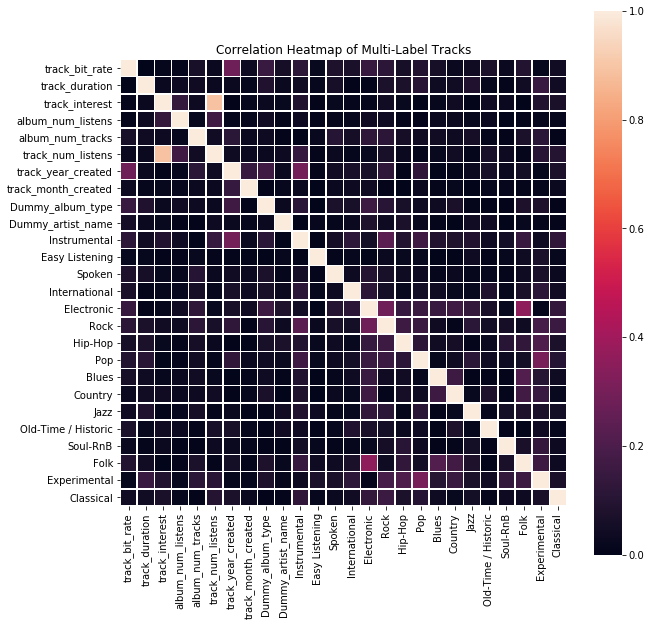

In [270]:
#Compare feature similarities 
#Compare the numerical categorical variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(multigen_df.corr()), square=True, linewidths=.5, annot=False)
plt.title('Correlation Heatmap of Multi-Label Tracks')
plt.show()


In [113]:
multigen_features = cont_cols

In [114]:
multigen_df.columns

Index(['album_type', 'artist_name', 'track_bit_rate', 'track_duration',
       'track_genre_top', 'track_interest', 'album_num_listens',
       'album_num_tracks', 'track_num_listens', 'track_year_created',
       'track_month_created', 'Dummy_album_type', 'str_track_genres',
       'Country', 'Hip-Hop', 'International', 'Blues', 'Instrumental',
       'Soul-RnB', 'Classical', 'Old-Time / Historic', 'Folk', 'Pop',
       'Easy Listening', 'Electronic', 'Rock', 'Experimental', 'Spoken',
       'Jazz'],
      dtype='object')

#### Continuous Features - Outlier Removal via Winsorization

In [115]:
#Determine extent of outliers using Tukey's method
outlier_loc = []
top_outlier_percent = []
bottom_outlier_percent = []

for col in list(multigen_features):
    q75, q25 = np.percentile(multigen_df[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    if (len((np.where(multigen_df[col] > max_val))[0]) > 0):
        if (len((np.where(multigen_df[col] < min_val))[0]) > 0):
            loc_now = 'both ends'
        else:
            loc_now = 'top'
    else:
        loc_now = 'bottom'
    
    outlier_loc.append(loc_now)
    print("Percentage of outliers in {}, located at {} of range: {}".format(col, loc_now, len((np.where((multigen_df[col] > max_val) |(multigen_df[col] < min_val))[0]))/len(multigen_df)))
    
    top_percent = len((np.where((multigen_df[col] > max_val))[0]))/len(multigen_df)
    #Get values to the closest whole percent
    top_outlier_percent.append(math.ceil(top_percent*100)/100)
    
    bottom_percent = len((np.where((multigen_df[col] < min_val))[0]))/len(multigen_df)
    #Get values to the closest whole percent
    bottom_outlier_percent.append(math.ceil(bottom_percent*100)/100)


Percentage of outliers in track_bit_rate, located at bottom of range: 0.0
Percentage of outliers in track_duration, located at top of range: 0.071368551804764
Percentage of outliers in track_interest, located at top of range: 0.09520678065176093
Percentage of outliers in album_num_listens, located at top of range: 0.10132617273125823
Percentage of outliers in track_num_listens, located at top of range: 0.09977349115884845


In [116]:
#Show calculated outlier parameters to be used for winsorization
out_df = pd.DataFrame()

out_df['variable name'] = list(multigen_features)
out_df['top outliers'] = top_outlier_percent
out_df['bottom outliers'] = bottom_outlier_percent
out_df['outlier location'] = outlier_loc

out_df

variable name  top outliers  bottom outliers outlier location
0     track_bit_rate          0.00              0.0           bottom
1     track_duration          0.08              0.0              top
2     track_interest          0.10              0.0              top
3  album_num_listens          0.11              0.0              top
4  track_num_listens          0.10              0.0              top

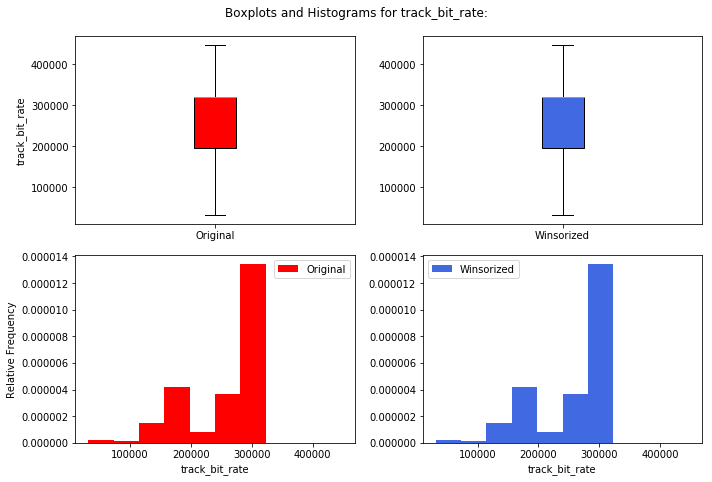

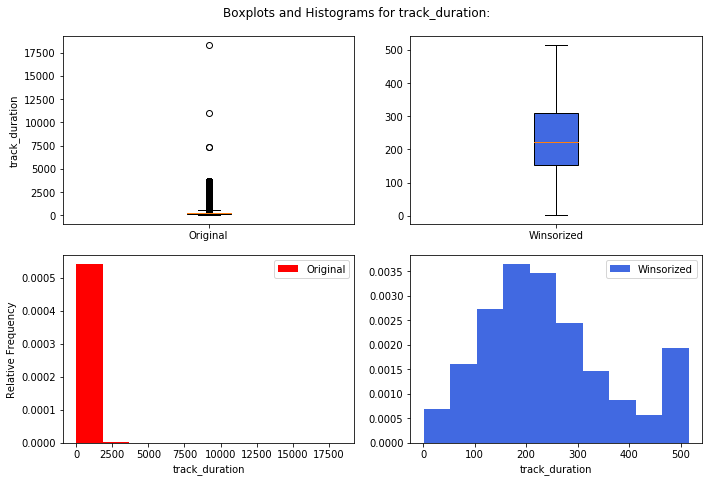

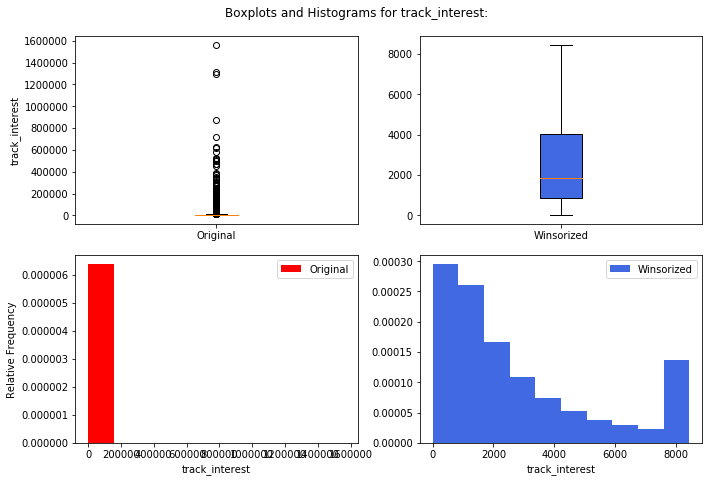

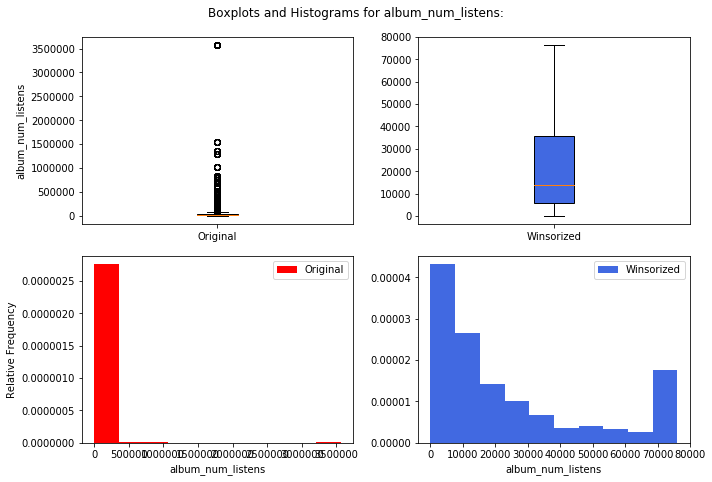

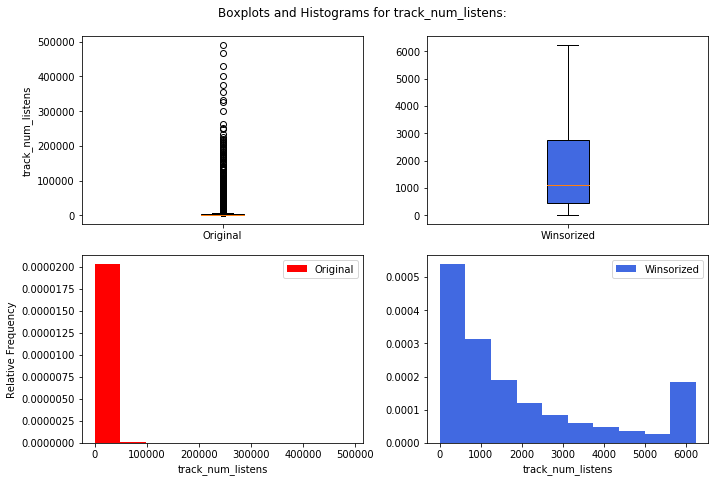

In [117]:
#Transform/remove the outliers, using winsorize()
from scipy.stats.mstats import winsorize

winsorized_cols = pd.DataFrame()

cols = multigen_features
for i in range(len(cols)):
    winsorized_cols[cols[i]] = winsorize(multigen_df[cols[i]], (bottom_outlier_percent[i], top_outlier_percent[i]))

#Analyze the effects of winsorization on boxplots/histograms:
for col in cols:
    plt.figure(figsize=(10,7))
    plt.subplot(2,2,1)
    box = plt.boxplot([multigen_df[col]], patch_artist=True, labels = ['Original'])
    plt.ylabel(col)
    colors = ['red']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.subplot(2,2,2)
    box = plt.boxplot([winsorized_cols[col]], patch_artist=True, labels = ['Winsorized'])
    colors = ['royalblue']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)


    plt.subplot(2,2,3)
    plt.hist([multigen_df[col]], color='red', label = ['Original'], normed=True)
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.legend()  

    plt.subplot(2,2,4)
    plt.hist([winsorized_cols[col]], color='royalblue', label = ['Winsorized'], normed=True)
    plt.xlabel(col)
    plt.legend()
    
    
    plt.suptitle('Boxplots and Histograms for ' + col + ':')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [118]:
multigen_df = multigen_df.reset_index(drop=True)

In [278]:
#Correlation analysis after outlier removal
multigen_2 = winsorized_cols.copy()
multigen_2.columns = [str('Winsorized ' + item) for item in list(multigen_features)]

for col in ['Dummy_album_type', 'Dummy_artist_name','Instrumental', 
            'Easy Listening', 'Spoken','International', 'Electronic', 
            'Rock', 'Hip-Hop', 'Pop', 'Blues','Country', 'Jazz', 
            'Old-Time / Historic', 'Soul-RnB', 'Folk','Experimental', 
            'Classical', 'track_genre_top', 'track_year_created', 
            'track_month_created']:
    multigen_2[col] = multigen_df[col]

#Description of winsorized dataframe statistics
multigen_2.describe()

Winsorized track_bit_rate  Winsorized track_duration  \
count               54744.000000               54744.000000   
mean               267222.299120                 243.204725   
std                 68145.219052                 128.265067   
min                 31281.000000                   1.000000   
25%                195216.750000                 153.000000   
50%                320000.000000                 221.000000   
75%                320000.000000                 310.000000   
max                448000.000000                 516.000000   

       Winsorized track_interest  Winsorized album_num_listens  \
count               54744.000000                  54744.000000   
mean                 2837.033958                  24732.197136   
std                  2594.958697                  24839.279469   
min                     3.000000                    108.000000   
25%                   850.000000                   5713.500000   
50%                  1844.000000                  13900.000000   
75%                  4011.000000                  35612.000000   
max                  8447.000000                  76096.000000   

       Winsorized album_num_tracks  Winsorized track_num_listens  \
count                 54744.000000                  54744.000000   
mean                     13.214690                   1928.129329   
std                       7.662002                   1960.020668   
min                       1.000000                      1.000000   
25%                       8.000000                    439.750000   
50%                      11.000000                   1122.000000   
75%                      17.000000                   2760.000000   
max                      28.000000                   6233.000000   

       Dummy_album_type  Dummy_artist_name  Instrumental  Easy Listening  ...  \
count      54744.000000       54744.000000  54744.000000    54744.000000  ...   
mean           0.190377        9847.826246      0.234893        0.012896  ...   
std            0.704576        4380.689823      0.423936        0.112829  ...   
min            0.000000          16.000000      0.000000        0.000000  ...   
25%            0.000000        6150.000000      0.000000        0.000000  ...   
50%            0.000000       10134.000000      0.000000        0.000000  ...   
75%            0.000000       14117.000000      0.000000        0.000000  ...   
max            4.000000       15495.000000      1.000000        1.000000  ...   

              Blues       Country          Jazz  Old-Time / Historic  \
count  54744.000000  54744.000000  54744.000000         54744.000000   
mean       0.029994      0.032752      0.064939             0.005736   
std        0.170573      0.177990      0.246420             0.075518   
min        0.000000      0.000000      0.000000             0.000000   
25%        0.000000      0.000000      0.000000             0.000000   
50%        0.000000      0.000000      0.000000             0.000000   
75%        0.000000      0.000000      0.000000             0.000000   
max        1.000000      1.000000      1.000000             1.000000   

           Soul-RnB          Folk  Experimental     Classical  \
count  54744.000000  54744.000000  54744.000000  54744.000000   
mean       0.024185      0.180897      0.503160      0.052535   
std        0.153626      0.384936      0.499995      0.223106   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       track_year_created  track_month_created  
count        54744.000000         54744.000000  
mean          2013.016933             6.360295  
std              2.429952             3.522858  
min           2008.000000             1.000000  
25%           2011.00

In [279]:
multigen_2.head()

Winsorized track_bit_rate  Winsorized track_duration  \
0                   256000.0                      311.0   
1                   256000.0                      181.0   
2                   256000.0                      174.0   
3                   256000.0                      104.0   
4                   256000.0                      205.0   

   Winsorized track_interest  Winsorized album_num_listens  \
0                      978.0                        2710.0   
1                     1060.0                        2710.0   
2                      718.0                        2710.0   
3                      252.0                        2710.0   
4                      247.0                        2710.0   

   Winsorized album_num_tracks  Winsorized track_num_listens  \
0                         13.0                         361.0   
1                         13.0                         193.0   
2                         13.0                         612.0   
3                         13.0                         171.0   
4                         13.0                         173.0   

   Dummy_album_type  Dummy_artist_name  Instrumental  Easy Listening  ...  \
0                 0              10134           0.0             0.0  ...   
1                 0              10134           0.0             0.0  ...   
2                 0              10134           0.0             0.0  ...   
3                 0              10134           0.0             0.0  ...   
4                 0              10134           0.0             0.0  ...   

   Country  Jazz  Old-Time / Historic  Soul-RnB  Folk  Experimental  \
0      0.0   0.0                  0.0       0.0   1.0           0.0   
1      0.0   0.0                  0.0       0.0   1.0           0.0   
2      0.0   0.0                  0.0       0.0   1.0           0.0   
3      0.0   0.0                  0.0       0.0   1.0           0.0   
4      0.0   0.0                  0.0       0.0   1.0           0.0   

   Classical  track_genre_top  track_year_created  track_month_created  
0        0.0              NaN              2008.0                 11.0  
1        0.0              NaN              2008.0                 11.0  
2        0.0              NaN              2008.0                 11.0  
3        0.0              NaN              2008.0                 11.0  
4        0.0              NaN              2008.0                 11.0  

[5 rows x 27 columns]

#### Continuous Variable Distributions - Separated by Genre Label

<Figure size 1080x504 with 0 Axes>

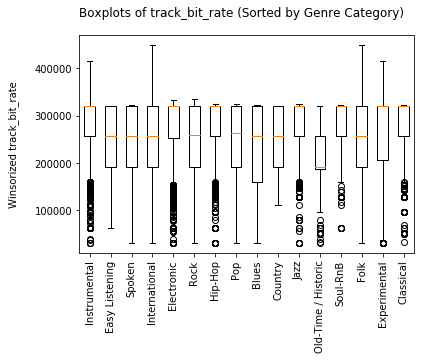

<Figure size 1080x504 with 0 Axes>

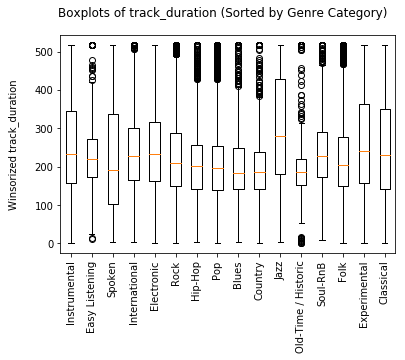

<Figure size 1080x504 with 0 Axes>

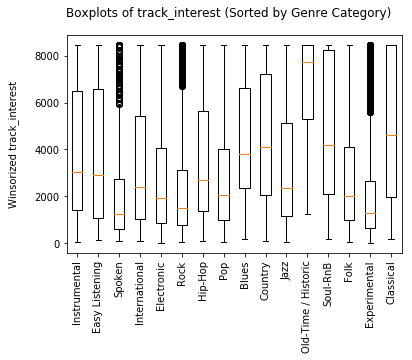

<Figure size 1080x504 with 0 Axes>

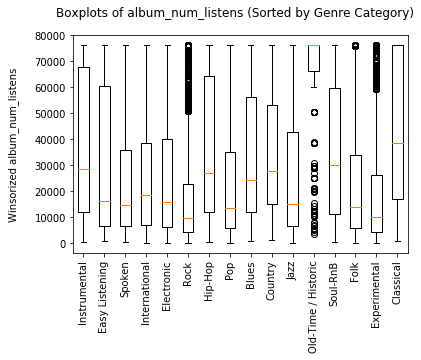

<Figure size 1080x504 with 0 Axes>

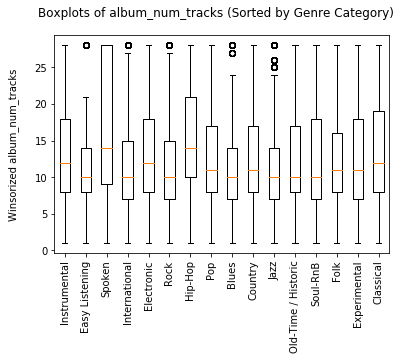

<Figure size 1080x504 with 0 Axes>

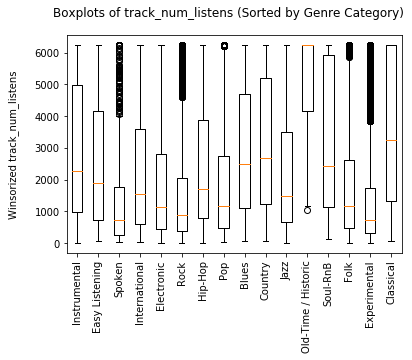

In [300]:
#Boxplot Distributions of Continuous Variables by Category
win_conts = multigen_2.columns.drop(gen_cols).drop(cat_cols).drop('track_genre_top')

for col in win_conts:
    plt.figure(figsize=(15, 7))
    
    boxes = []
    for j in range(len(gen_cols)):
        boxes.append(multigen_2[multigen_2[gen_cols[j]]==1][col])
    
    fig, ax = plt.subplots()
    plt.boxplot(boxes)
    ax.set_xticklabels(gen_cols)
    plt.xticks(rotation=90)
    plt.ylabel(col + '\n')

    plt.suptitle('Boxplots of ' + col.split(' ')[1] + ' (Sorted by Genre Category)')
    plt.show()

### Train-Test Split for Multi-Label Track Modeling

In [119]:
from sklearn.model_selection import train_test_split

features = multigen_2.columns.drop(['track_genre_top']).drop(gen_cols)
target = gen_cols

X = multigen_2[features]
Y = multigen_2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [120]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

As with the single-label dataset, min-max scaling of the multi-label dataset for the purpose of normalization happens after the 20%-80% train-test split.

In [121]:
#Normalize data
for df in [X_train, X_test]: 
    norm_df = pd.DataFrame()
    for cat in win_conts:
        normed = []
        for item in df[cat]:
            xmax = df[cat].max()
            xmin = df[cat].min()
            normed.append((item-xmin)/(xmax-xmin))

        norm_df[cat] = normed

    for col in norm_df.columns:
        df[col] = norm_df[col]

### Multi-Label Classification Libraries

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

### Multinomial Naive-Bayes Classification Pipeline

In [326]:
%%time
# MultinomialNB Classification
# Define a pipeline using Multinomial Naive-Bayes, One vs Rest Classification

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
tot_acc = 0

for category in gen_cols:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    tot_acc = tot_acc + accuracy_score(y_test[category], prediction)

print('\n')
print('Average test accuracy among genres is {}'.format(tot_acc/len(gen_cols)))
print('\n')


... Processing Instrumental
Test accuracy is 0.5819709562517125
... Processing Easy Listening
Test accuracy is 0.5616037994337383
... Processing Spoken
Test accuracy is 0.6091880537035346
... Processing International
Test accuracy is 0.5178555119188967
... Processing Electronic
Test accuracy is 0.5439766188693032
... Processing Rock
Test accuracy is 0.5226961366334825
... Processing Hip-Hop
Test accuracy is 0.5343867019819162
... Processing Pop
Test accuracy is 0.5520138825463513
... Processing Blues
Test accuracy is 0.5205954881724358
... Processing Country
Test accuracy is 0.8158735957621701
... Processing Jazz
Test accuracy is 0.5575851675952141
... Processing Old-Time / Historic
Test accuracy is 0.6156726641702439
... Processing Soul-RnB
Test accuracy is 0.7237190611014704
... Processing Folk
Test accuracy is 0.5433372910768106
... Processing Experimental
Test accuracy is 0.5188601698785277
... Processing Classical
Test accuracy is 0.5588638231801991


Average test accuracy among g

### Linear Support Vector Classification Pipeline

In [315]:
%%time
#LinearSVC Classification
from sklearn.svm import LinearSVC
SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(),n_jobs=1)),])
tot_acc = 0

for category in gen_cols:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    tot_acc = tot_acc + accuracy_score(y_test[category], prediction)

print('\n')
print('Average test accuracy among genres is {}'.format(tot_acc/len(gen_cols)))
print('\n')


... Processing Instrumental
Test accuracy is 0.7692026669102201
... Processing Easy Listening
Test accuracy is 0.985112795689104
... Processing Spoken
Test accuracy is 0.9740615581331629
... Processing International
Test accuracy is 0.929125947575121
... Processing Electronic
Test accuracy is 0.5471732578317654
... Processing Rock
Test accuracy is 0.6533016713855146
... Processing Hip-Hop
Test accuracy is 0.9124120924285323
... Processing Pop
Test accuracy is 0.7902091515206868
... Processing Blues
Test accuracy is 0.9689469357932231
... Processing Country
Test accuracy is 0.9663896246232533
... Processing Jazz
Test accuracy is 0.9325965841629372
... Processing Old-Time / Historic
Test accuracy is 0.995707370536122
... Processing Soul-RnB
Test accuracy is 0.9764362042195635
... Processing Folk
Test accuracy is 0.8149602703443237
... Processing Experimental
Test accuracy is 0.5043382957347703
... Processing Classical
Test accuracy is 0.9495844369348799


Average test accuracy among genr

### Multinomial Logistic Regression Pipeline

In [316]:
%%time
#Logistic Regression Pipeline
from sklearn.linear_model import LogisticRegression
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
tot_acc = 0

for category in gen_cols:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    tot_acc = tot_acc + accuracy_score(y_test[category], prediction)

print('\n')
print('Average test accuracy among genres is {}'.format(tot_acc/len(gen_cols)))
print('\n')


... Processing Instrumental
Test accuracy is 0.7692026669102201
... Processing Easy Listening
Test accuracy is 0.985112795689104
... Processing Spoken
Test accuracy is 0.9740615581331629
... Processing International
Test accuracy is 0.929125947575121
... Processing Electronic
Test accuracy is 0.5360306877340396
... Processing Rock
Test accuracy is 0.6533016713855146
... Processing Hip-Hop
Test accuracy is 0.9124120924285323
... Processing Pop
Test accuracy is 0.7902091515206868
... Processing Blues
Test accuracy is 0.9689469357932231
... Processing Country
Test accuracy is 0.9663896246232533
... Processing Jazz
Test accuracy is 0.9325965841629372
... Processing Old-Time / Historic
Test accuracy is 0.995707370536122
... Processing Soul-RnB
Test accuracy is 0.9764362042195635
... Processing Folk
Test accuracy is 0.8149602703443237
... Processing Experimental
Test accuracy is 0.5216914786738515
... Processing Classical
Test accuracy is 0.9495844369348799


Average test accuracy among genr

### Binary Relevance Pipeline - Gaussian Naive-Bayes

In [320]:
%%time
#Binary Relevance - Gaussian NB
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# Initialize binary relevance multi-label classifier with a gaussian naive bayes base classifier
classifier_brgnb = BinaryRelevance(GaussianNB())

# Train
classifier_brgnb.fit(X_train, y_train)

# Predict
predictions_brgnb = classifier_brgnb.predict(X_test)

# Check Accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_brgnb))
print("\n")

Accuracy =  0.11224769385331994


Wall time: 1.09 s


### Binary Relevance Pipeline - Random Forest

In [18]:
%%time
#Binary Relevance - Random Forest
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

# initialize binary relevance multi-label classifier
# with a random forest base classifier
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)
# train
classifier_brrf.fit(X_train, y_train)

# predict
predictions_brrf = classifier_brrf.predict(X_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_brrf))
print("\n")

Accuracy =  0.5227874691752672


Wall time: 2min 22s


### Chain Classification 

In [122]:
%%time
from skmultilearn.problem_transform import ClassifierChain

#Classifier Chain
chain = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
chain.fit(X_train, y_train)

# predict
predictions = chain.predict(X_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.11644899077541328


Wall time: 15.2 s
Parser   : 111 ms


### Label Powerset Classification

In [321]:
%%time
#Label Powerset
from skmultilearn.problem_transform import LabelPowerset

# initialize label powerset classifier
classifier_lp = LabelPowerset(LogisticRegression())

# train
classifier_lp.fit(X_train, y_train)

# predict
predictions_lp = classifier_lp.predict(X_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_lp))
print("\n")

Accuracy =  0.14987670106859075


Wall time: 9min 54s


### MLkNN Adapted Algorithm

In [353]:
%%time
#Adapted Algorithm
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

classifier_mlk = MLkNN(k=10)

#the classifier can throw up errors when handling sparse matrices.
X_train = lil_matrix(X_train).toarray()
y_train = lil_matrix(y_train).toarray()
X_test = lil_matrix(X_test).toarray()
y_test = lil_matrix(y_test).toarray()

# train
classifier_mlk.fit(X_train, y_train)

# predict
predictions_mlk = classifier_mlk.predict(X_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_mlk))
print("\n")

Accuracy =  0.675678144122751


Wall time: 7min 41s


### Multinomial KNN Classification Pipeline

#### Parameter Tuning

... Processing Instrumental
[0.9573477029865741, 0.9579870307790666, 0.9524157457302037, 0.9497671020184492, 0.9437391542606631, 0.9378938715864462, 0.9343319024568454, 0.9319572563704448, 0.9262033062380126, 0.9207233537309343, 0.9163393917252717, 0.9114987670106859, 0.9068408073796693, 0.9044661612932688, 0.8988035437026213, 0.8981642159101287, 0.891040277650927, 0.8891222942734496, 0.8839163393917253, 0.8820896885560325, 0.8791670472189241, 0.8779797241757238, 0.874417755046123, 0.871860443876153, 0.86884646999726]


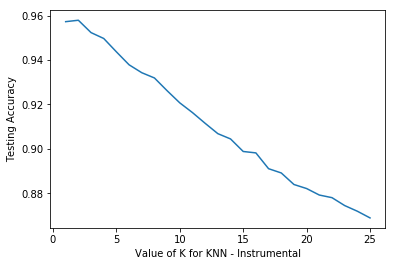

Best Score at k =  2 

... Processing Easy Listening
[0.9950680427436296, 0.9955247054525528, 0.994976710201845, 0.9948853776600602, 0.9941547173257832, 0.9941547173257832, 0.9936067220750754, 0.9928760617407982, 0.992693396657229, 0.991688738697598, 0.9909580783633208, 0.9905014156543976, 0.9903187505708284, 0.9886747648187049, 0.9884920997351356, 0.9883094346515664, 0.9880354370262124, 0.9873047766919353, 0.9873047766919353, 0.9875787743172892, 0.9875787743172892, 0.9873047766919353, 0.9873047766919353, 0.9873047766919353, 0.9872134441501507]


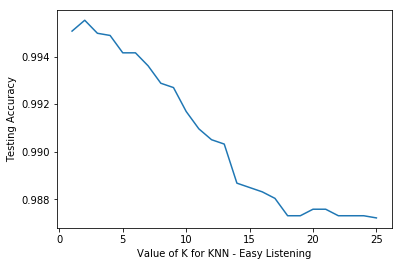

Best Score at k =  2 

... Processing Spoken
[0.9953420403689834, 0.995433372910768, 0.9955247054525528, 0.994702712576491, 0.99369805461686, 0.991688738697598, 0.9913234085304594, 0.9913234085304594, 0.9905014156543976, 0.9897707553201206, 0.9892227600694127, 0.9876701068590739, 0.9868481139830122, 0.9855694583980272, 0.9838341401041191, 0.9841994702712576, 0.9833774773951959, 0.9822814868937803, 0.9818248241848571, 0.982098821810211, 0.9809114987670107, 0.9809114987670107, 0.9801808384327336, 0.9803635035163029, 0.9801808384327336]


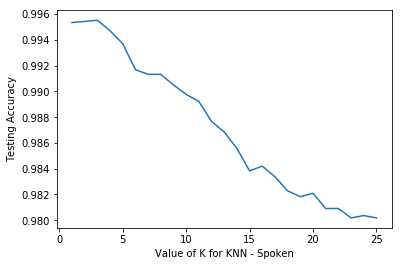

Best Score at k =  3 

... Processing International
[0.9840168051876884, 0.9844734678966116, 0.9819161567266417, 0.9807288336834414, 0.9778975248881177, 0.9747008859256553, 0.9728742350899625, 0.9704995890035619, 0.9670289524157457, 0.9652023015800529, 0.9620969951593753, 0.9602703443236825, 0.9585350260297744, 0.9581696958626359, 0.9563430450269431, 0.9554297196090967, 0.9538770663987579, 0.9512284226870034, 0.9500410996438031, 0.9497671020184492, 0.9483971138916796, 0.9479404511827564, 0.947301123390264, 0.9465704630559868, 0.9457484701799251]


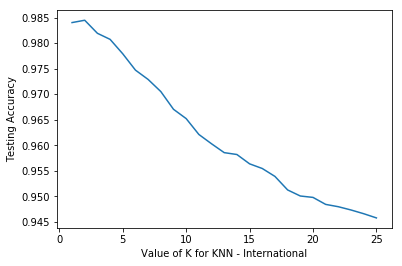

Best Score at k =  2 

... Processing Electronic
[0.9452004749292173, 0.9369805461685998, 0.9385331993789388, 0.9253813133619508, 0.9210886838980729, 0.9093067860078546, 0.9036441684172071, 0.8934149237373276, 0.8877523061466801, 0.8783450543428624, 0.8705817882911682, 0.8634578500319664, 0.8578865649831035, 0.8490273084299936, 0.8391633939172527, 0.8335007763266051, 0.8258288428166956, 0.8193442323499863, 0.8134989496757695, 0.8050963558315828, 0.8018997168691204, 0.7974244223216732, 0.7931317928577952, 0.7892958261028404, 0.7874691752671477]


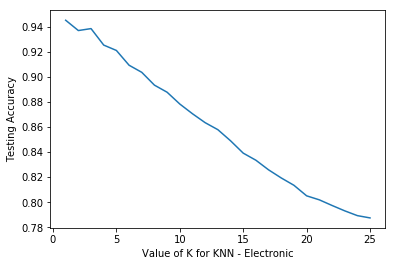

Best Score at k =  1 

... Processing Rock
[0.9519590830212805, 0.9469357932231254, 0.9419125034249703, 0.9371632112521692, 0.9270252991140744, 0.9186227052698877, 0.9093067860078546, 0.9009955247054525, 0.8906749474837885, 0.8819983560142479, 0.8750570828386154, 0.867111151703352, 0.8620878619051968, 0.8538679331445794, 0.8506712941821171, 0.8424513654214997, 0.8388893962918988, 0.8320394556580509, 0.8272901634852498, 0.8198922276006941, 0.8152342679696776, 0.808840990044753, 0.8040003653301672, 0.8036350351630286, 0.7990684080737966]


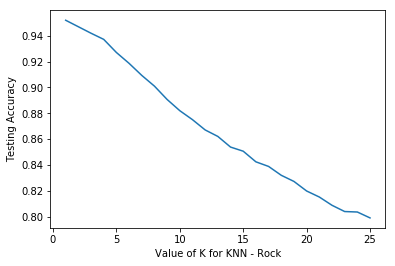

Best Score at k =  1 

... Processing Hip-Hop
[0.9842908028130423, 0.9858434560233811, 0.9836514750205498, 0.9827381496027034, 0.9801808384327336, 0.978810850305964, 0.9759795415106403, 0.9731482327153165, 0.9722349072974701, 0.9708649191707005, 0.9679422778335921, 0.9664809571650379, 0.9639236459950681, 0.9647456388711297, 0.9620056626175907, 0.9587176911133437, 0.9562517124851585, 0.9539683989405425, 0.9524157457302037, 0.9529637409809115, 0.9500410996438031, 0.9494931043930953, 0.9485797789752489, 0.9476664535574025, 0.9455658050963558]


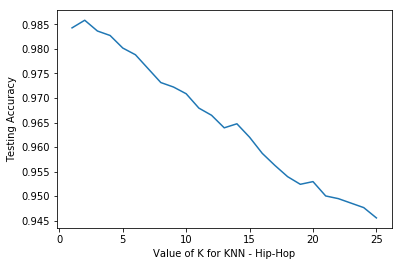

Best Score at k =  2 

... Processing Pop
[0.9682162754589461, 0.9659329619143301, 0.9617316649922367, 0.9549730569001735, 0.9487624440588182, 0.9441958169695862, 0.9373458763357384, 0.9332359119554298, 0.9265686364051512, 0.9204493561055804, 0.9133254178463787, 0.9094894510914239, 0.9037355009589917, 0.8991688738697597, 0.8961548999908667, 0.8903096173166499, 0.887021645812403, 0.8824550187231711, 0.8787103845100009, 0.8773403963832314, 0.8727737692939994, 0.8717691113343684, 0.8695771303315372, 0.8690291350808294, 0.8663804913690748]


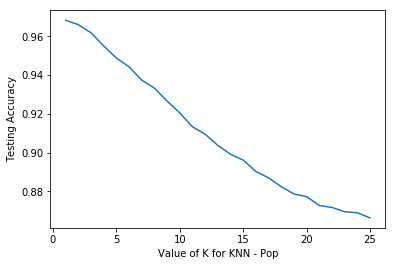

Best Score at k =  1 

... Processing Blues
[0.9945200474929218, 0.9937893871586446, 0.9931500593661522, 0.9926020641154444, 0.9910494109051055, 0.9890400949858434, 0.98739610923372, 0.9863001187323043, 0.9856607909398118, 0.9841994702712576, 0.9827381496027034, 0.9832861448534113, 0.983103479769842, 0.9822814868937803, 0.9818248241848571, 0.9811854963923646, 0.9806375011416568, 0.9793588455566719, 0.9780801899716869, 0.9780801899716869, 0.9784455201388255, 0.9783541875970408, 0.9783541875970408, 0.9783541875970408, 0.9780801899716869]


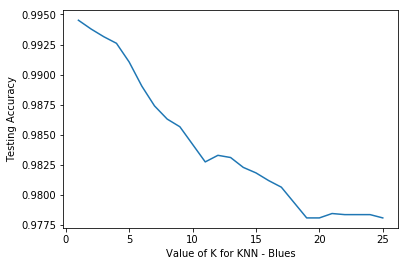

Best Score at k =  1 

... Processing Country
[0.9940633847839986, 0.9937893871586446, 0.9928760617407982, 0.9920540688647365, 0.990410083112613, 0.9887660973604896, 0.9879441044844278, 0.9860261211069504, 0.9850214631473194, 0.9827381496027034, 0.9815508265595031, 0.9818248241848571, 0.9804548360580875, 0.9785368526806101, 0.9770755320120559, 0.9774408621791945, 0.9769841994702713, 0.9757968764270709, 0.9756142113435017, 0.9751575486345785, 0.9742442232167321, 0.9726915700063933, 0.9726915700063933, 0.971504246963193, 0.9714129144214083]


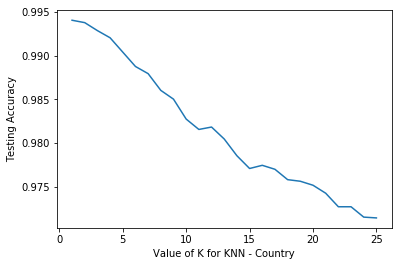

Best Score at k =  1 

... Processing Jazz
[0.9898620878619052, 0.9883094346515664, 0.9860261211069504, 0.9833774773951959, 0.9822814868937803, 0.9795415106402411, 0.9767102018449173, 0.9730569001735319, 0.9718695771303315, 0.9697689286692849, 0.9688556032514385, 0.9664809571650379, 0.9657502968307607, 0.9627363229518677, 0.9614576673668829, 0.9603616768654671, 0.9596310165311901, 0.9577130331537127, 0.9578956982372819, 0.9560690474015892, 0.9561603799433738, 0.9559777148598045, 0.9547903918166043, 0.9541510640241118, 0.9538770663987579]


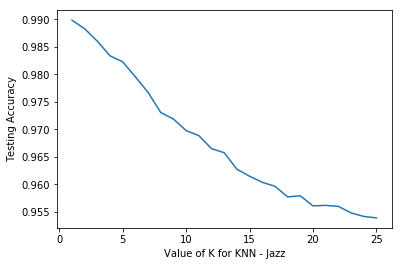

Best Score at k =  1 

... Processing Old-Time / Historic
[0.9961640332450452, 0.9972600237464608, 0.9965293634121838, 0.9972600237464608, 0.9971686912046762, 0.9968946935793224, 0.996712028495753, 0.9968946935793224, 0.9965293634121838, 0.9965293634121838, 0.9965293634121838, 0.9964380308703992, 0.9963466983286144, 0.9965293634121838, 0.9964380308703992, 0.9964380308703992, 0.9962553657868298, 0.9961640332450452, 0.9961640332450452, 0.9960727007032606, 0.9953420403689834, 0.9952507078271988, 0.9952507078271988, 0.994976710201845, 0.994976710201845]


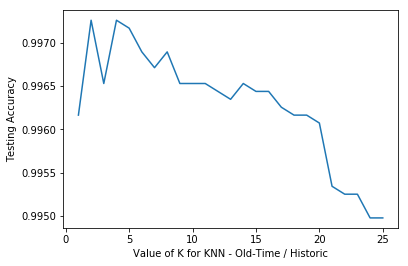

Best Score at k =  2 

... Processing Soul-RnB
[0.9945200474929218, 0.993424056991506, 0.992419399031875, 0.9921454014065212, 0.9910494109051055, 0.9893140926111974, 0.9882181021097817, 0.9882181021097817, 0.9875787743172892, 0.9865741163576582, 0.9852041282308887, 0.985112795689104, 0.9841994702712576, 0.9829208146862727, 0.9820074892684263, 0.9823728194355649, 0.9815508265595031, 0.9820074892684263, 0.98109416385058, 0.9813681614759339, 0.9810028313087953, 0.9818248241848571, 0.9809114987670107, 0.980820166225226, 0.9806375011416568]


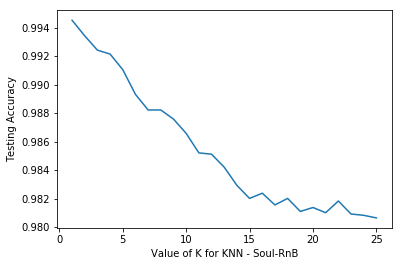

Best Score at k =  1 

... Processing Folk
[0.9729655676317472, 0.9720522422139009, 0.9678509452918075, 0.9644716412457759, 0.9576217006119281, 0.9532377386062654, 0.94702712576491, 0.9415471732578318, 0.9356105580418304, 0.9302219380765366, 0.9257466435290894, 0.9230979998173349, 0.9176180473102566, 0.9136907480135172, 0.9084847931317929, 0.9068408073796693, 0.9037355009589917, 0.9004475294547447, 0.8965202301580053, 0.8946935793223125, 0.8925015983194813, 0.8896702895241575, 0.8878436386884647, 0.8840076719335099, 0.8823636861813864]


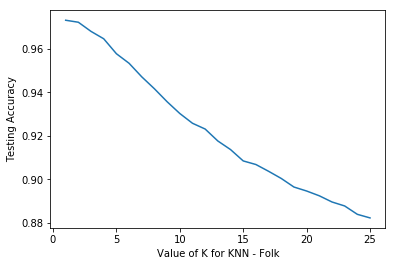

Best Score at k =  1 

... Processing Experimental
[0.9481231162663257, 0.939994520047493, 0.938989862087862, 0.9267513014887204, 0.9226413371084117, 0.9120467622613937, 0.9029135080829299, 0.8905836149420039, 0.8841903370170792, 0.8743264225043383, 0.8674764818704904, 0.8620878619051968, 0.855237921271349, 0.8480226504703626, 0.840350716960453, 0.8351447620787287, 0.8307608000730661, 0.8208968855603251, 0.8159649283039547, 0.8093889852954608, 0.8054616859987214, 0.8000730660334278, 0.7960544341949036, 0.7921271348981642, 0.7879258379760709]


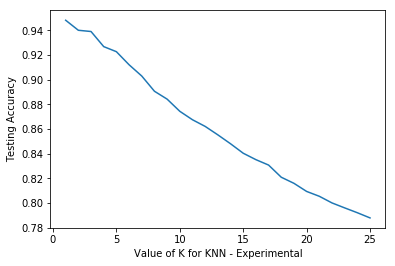

Best Score at k =  1 

... Processing Classical
[0.9912320759886748, 0.9905927481961823, 0.9891314275276281, 0.9888574299022742, 0.9876701068590739, 0.9865741163576582, 0.9849301306055348, 0.9837428075623345, 0.9821901543519956, 0.9813681614759339, 0.9806375011416568, 0.9799068408073797, 0.9795415106402411, 0.979815508265595, 0.9795415106402411, 0.9789935153895333, 0.9780801899716869, 0.977806192346333, 0.9759795415106403, 0.9757055438852863, 0.9752488811763631, 0.9750662160927939, 0.9745182208420861, 0.9731482327153165, 0.973513562882455]


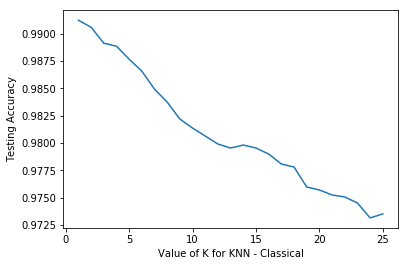

Best Score at k =  1 



In [39]:
#KNN Classification
# try K=1 through K=25 and record testing accuracy
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1, 26)
best_k = []

for category in gen_cols:
    print('... Processing {}'.format(category))
    # We can create Python dictionary using [] or dict()
    scores = []

    # We use a loop through the range 1 to 26
    # We append the scores in the dictionary
    for k in k_range:
        mknn = KNeighborsClassifier(n_neighbors=k)
        mknn.fit(X_train, y_train[category])
        y_pred_mknn = mknn.predict(X_test)
        scores.append(metrics.accuracy_score(y_test[category], y_pred_mknn))

    print(scores)


    # plot the relationship between K and testing accuracy
    # plt.plot(x_axis, y_axis)
    plt.figure()
    plt.plot(k_range, scores)
    plt.xlabel('Value of K for KNN - ' + category)
    plt.ylabel('Testing Accuracy')
    plt.show()

    print('Best Score at k = ', scores.index(max(scores))+1, '\n')
    best_k.append(scores.index(max(scores))+1)


#### Optimized Model for Each Genre

In [40]:
%%time
#KNN Pipeline
tot_acc = 0

for i in range(len(gen_cols)):
    print('... Processing {}'.format(gen_cols[i]))
    mKNN = KNeighborsClassifier(n_neighbors=best_k[i])
    # train the model using X_dtm & y
    mKNN.fit(X_train, y_train[gen_cols[i]])
    # compute the testing accuracy
    prediction = mKNN.predict(X_test)
    print('Test accuracy is {}\n'.format(accuracy_score(y_test[gen_cols[i]], prediction)))
    tot_acc = tot_acc + accuracy_score(y_test[gen_cols[i]], prediction)

print('\n')
print('Average test accuracy among genres is {}'.format(tot_acc/len(gen_cols)))
print('\n')


... Processing Instrumental
Test accuracy is 0.9579870307790666

... Processing Easy Listening
Test accuracy is 0.9955247054525528

... Processing Spoken
Test accuracy is 0.9955247054525528

... Processing International
Test accuracy is 0.9844734678966116

... Processing Electronic
Test accuracy is 0.9452004749292173

... Processing Rock
Test accuracy is 0.9519590830212805

... Processing Hip-Hop
Test accuracy is 0.9858434560233811

... Processing Pop
Test accuracy is 0.9682162754589461

... Processing Blues
Test accuracy is 0.9945200474929218

... Processing Country
Test accuracy is 0.9940633847839986

... Processing Jazz
Test accuracy is 0.9898620878619052

... Processing Old-Time / Historic
Test accuracy is 0.9972600237464608

... Processing Soul-RnB
Test accuracy is 0.9945200474929218

... Processing Folk
Test accuracy is 0.9729655676317472

... Processing Experimental
Test accuracy is 0.9481231162663257

... Processing Classical
Test accuracy is 0.9912320759886748



Average test 

## Multi-Label Dataset Conclusions:
Although we have labeled this portion of the analysis as 'multi-label,' it would really be more accurately described as 'all-label,' since this dataset contains both single-label and multi-label tracks. The difference, in terms of the included single-label tracks, is that this analysis uses 16 binary dummy features, one for each genre label, instead of the single nominal categorical dummy variable of genre used in the previous analysis. In this section of the project, the target features (16 dummy features) were modeled against the descriptive features for each track, and 9 machine learning models were developed.

A significant difference between this analysis and the single-label analysis is that each model splits the problem into a pipeline of 16 seperate classifications (one for each genre) and independently determines accuracy for the respective genre labels, then finally averages the accuracy scores to produce an overall accuracy score. This is commonly called a 'One vs. Rest Classifier.' 

The fastest classifiers were Multinomial Naive-Bayes and Binary Relevance Gaussian Naive-Bayes, which ran in 1.4 and 1.09 seconds, respectively. However, these didn't produce very high accuracy scores across all genre label predictions, at averages of 58% and 11%, respectively. Both Chain Classification and Label Powerset Classification had very low accuracy scores (12% and 15%, respectively), and the latter took nearly 10 minutes to run, not very good in either aspect of performance. Binary Relevance Random Forest only produced accuracy of approximately 52% and took over 2 minutes to run. 

On the other hand, Multinomial Logistic Regression scored an average accuracy of 85% in about 1.5 minutes of runtime. The downside to that model is that some genre labels had very high accuracy and others had very low accuracy. Something important to note is that the labels with high accuracy (Old-Fashioned, Easy Listening, etc.) were very under-represented in the dataset and the low accuracy genre labels were ones that matched with many tracks in the dataset (Electronic, Rock, etc). Linear SVC performed much the same as Multinomial Logistic Regression, with an average accuracy of 85% and a runtime of 4 minutes. The same trends of high- and low-accuracy labels held true for Linear SVC as with the Logistic Regression. 

I expected the final two models, a KNN adapted algorithm from the SKMultilearn library, and a Multinomial KNN Pipeline, to produce similar results, but that wasn't what we produced. MLkNN Adapted Algorithm had an accuracy of 67% and a runtime of 7ish minutes, while the Multinomial KNN Pipeline had an average accuracy of 98% and a runtime of 26 seconds. 

Overall, the best model for this section of the analysis was the Multinomial k-Nearest Neighbors Pipeline Classification. It had the highest average accuracy of all the models, by far, and each genre label had high prediction accuracy (all were ~95% or higher). It also had very low runtime, even after iterating through 26 k-values for each genre label, which makes it the obvious choice for future classification models. 

## Overall Conclusions:
We split this analysis into two categories, single-label and multi-label, to see if the different types of usable machine learning models might produce significantly different results, and that was found to be the case. Although we initially planned to only analyze the tracks with multiple genre labels in the second half of the project, we decided to retain as much of the dataset as possible by analyzing all of the tracks, but using binary dummy features instead of the single dummy genre feature. 

This decision paid off. we found that a __KNN Classification Pipeline__, with optimized parameters for each genre label being analyzed, was the best option for overall prediction accuracy. Using this model, we should be able to assign genre labels at an accuracy of at least 95%.

As mentioned earlier, class imbalances seemed to cause issues for many of the models. We didn't oversample/undersample the genres to even out the imbalance, because if we had, the size of our usable dataset would have had to be reduced by over 90%, since some of the under-represented labels appeared a few hundred times compared to the thousands of times the over-represented labels appeared. Fortunately, the class imbalances didn't seem to significantly affect the Multinomial KNN Classification Pipeline, so it's not something that needs to be worried about for the time being.